# Variability of V1, V2, and V3 in a large sample of human observers: Supplemental Notebook

**Author**: Noah C. Benson &lt;[nben@uw.edu](mailto:nben@uw.edu)&gt;  
**OSF Page**: [https://osf.io/knb5g/](https://osf.io/knb5g/)


## Introduction

This notebook describes the "HCP Lines" project, a reserach effort to augment the [Human Connectome Project](https://humanconnectome.org/) (HPC) [7T Retinotopy Dataset](https://doi.org/10.1167/18.13.23) by annotating the maps in each subject by hand. The goal of this project is to better understand the organization of human retinotopic maps in a large population and to provide a database which can be used for future analysis and training.

This notebook demonstrates how to leverage the HCP-lines dataset, as interpreted using [`neuropythy`](https://github.com/noahbenson/neuropythy), to perform the analyses and generate the plots that went into the associated paper. The code that generates the dataset and performs the various preprocessing of the lines is in [`neuropythy/datasets/hcp_lines.py`](https://github.com/noahbenson/neuropythy/blob/master/neuropythy/datasets/hcp_lines.py).

The **Configuration** section contains a small set of variables whose values the user may need to or want to change. For example, the path in which to store the HCP-lines dataset, as it is auto-downloaded, can be set.

The **Initialization** section contains code that prepares the `python` engine and the dataset for analysis and visualization.

The **Analysis** section contains code that performs various analyses or produces components of the figures in the paper.

The **Quality Control** section contains various checks of the underlying algorithms used to calculate the various values.

## Configuration

---

**hcp_lines_path**. The path of the HCP-lines data.

If you are auto-downloading this dataset from the OSF using an internet connection (recommended), then this should be the location in which to store the local cache of the dataset.

If you have obtained the dataset via some other means (such as downloading it from the OSF), then this should be the path to the directory that resembles the OSF root (i.e., the directory that contains files such as the `normalized/` directory and the `surface_area/` directory). This is equivalent to telling neuropythy that the given directory is the cache directory--because the files are already downloaded, neuropythy will not need to download any data from the OSF

If `hcp_lines_path` is set to `None`, neuropythy will use the value configured via the [`neuropythy.config`](https://github.com/noahbenson/neuropythy/wiki/Configuration) interface (`ny.config['hcp_lines_path']`). If no such value has been configured, then a temporary directory is created for the cache. This directory is deleted when the Python instance exits.

If you are running this notebook using Docker and you wish to save the cache data between sessions, you do not need to change this value (it is by default configured to use `/data/hcp/lines` as the cache directory inside the docker-image), but you do need to mount your cache directory inside the docker. If you want to use the local directory `/home/nben/cache/hcplines` as the cache directory, then you should start the docker using the command `docker-compose run -V /home/nben/cache/hcplines:/data/hcp/lines`. This goes for all paths that must be provided to the docker-image.

In [1]:
hcp_lines_path = None

---

**genetic_data_path**. The genetic data path is the path of the restricted genetic information for the HCP retinotopy dataset. The file is part of the HCP restricted data and must be downloaded with the name 'RESTRICTED_hcpfamilystructure.csv'. Set this variable to either the directory that contains this file or the name of the file itself. If set to `None`, this value will default to `os.path.join(ny.config['hcp_lines_path'], 'metadata', 'RESTRICTED_hcpfamilystructure.csv')`.

In [2]:
genetic_data_path = None

---

**behavioral_data_path**. The behavioral data path is the path to the HCP behavioral data CSV file; this can be downloaded from the HCP's `db.humanconnectome.org` website. This path should be a path to the file itself. If `None`, then the default value is `os.path.join(ny.config['hcp_lines_path'], 'metadata', 'behavioral_data_1200_subjects.csv')`.

In [3]:
behavioral_data_path = None

---

**log_level**. The `log_level` can be `'DEBUG'`, `'INFO'`, `'WARNING'`, `'ERROR'`, or `'CRITICAL'`, listed in order from the most permissive (most messages) log-level to the least permissive (fewest messages). You can set this to a value like `'DEBUG'` if you wish to see more logging messages.

In [4]:
log_level = 'INFO'

---

**figures_path**. The `figures_path` controls where figures will be exported. If left as `None`, then no figures will be saved to disk. To make sure that figures get saved to disk, set this to a directory path (the directory will get automatically created if it does not exist).

In [5]:
figures_path = '/data/hcp/lines/figures'

---

**Colors**

Various colors and style are used in the figures throughout this notebook. This cell defines these colors. Colors should be given as RGB or RGBA tuples with values ranging from 0 to 1.

In [6]:
# The colos we give to twin types.
twin_colors = {'MZ': [220/255,  75/255,  75/255, 1],
               'DZ': [ 75/255, 175/255, 210/255, 1],
               'UR': [    0.7,     0.7,     0.7, 1]}
# The colors for hemispheres.
hemi_colors = {'lh': [ 90/255,  25/255, 115/255, 1],
               'rh': [      0, 150/255,  60/255, 1]}
# The colormap we use for intensity plots.
intensity_cmap = 'hot'

## Initialization

The initialization section contains code that (1) imports libraries, (2) declares utility functions for plotting and analysis, and (3) loads the dataset and performs any pre-processing that is necessary.

### Dependencies

In [7]:
import logging
logging.basicConfig(level=log_level)

import os, sys, six, pimms, pandas, warnings
import numpy as np
import scipy as sp, scipy.stats as stats, scipy.sparse as sps, scipy.spatial as space
import matplotlib as mpl, matplotlib.pyplot as plt
import ipyvolume  as ipv
import pyrsistent as pyr
import neuropythy as ny

# #TODO Later this will be removed when hcp-lines is integrated with
# neuropythy's datasets
if 'hcp_lines' not in ny.data:
    hcppath = '/home/nben/code/hcp-lines'
    if hcppath not in sys.path:
        sys.path.append(hcppath)
    import hcp_lines

In [8]:
%matplotlib inline
#%gui qt

In [9]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

### General Plotting Utilities

These cells all define utilities for plotting. They are inteded to supplement plots, but are not intended to put together a figure on their own or to know about the HCP data in any specific way.

---

**`quantile_polygon`**

This first function is a for use in trend-plots where one wants to plot a trend-line as well as min-max, standard-deviation, or ± 95% quantile trend-lines. This is most useful where the number of points to be plotted is infeasible, and instead a sense of the density of points `(x,y)` points wants to be give, or when the distribution of the points in the `y`-dimension wants to be shown continuously across values of `x`.

In [10]:
def quantile_polygon(x, y, q, xlim=None, x_transform=None, bin_width=None, bin_count=None,
                     plot_x=None):
    '''
    quantile_polygon(x, y, [minq,maxq]) yields the boundary coordinates for a polygon that
      outlines the given min and max quantiles of (x, y) in terms of x in which 5% of all
      items in x are considered as part of the quantile calculation of each value; in other
      words, the bin for a point x0 always includes exactly the n/20 points nearest x0 in
      the vector x.
    quantile_polygon(x, y, q) yields a single matrix of points for the line tracing the
      quantile q.
    '''
    import scipy.spatial as space
    # parse args
    x = np.asarray(x)
    y = np.asarray(y)
    ii = np.where(np.isfinite(x) & np.isfinite(y))
    (x,y) = [u[ii] for u in (x,y)]
    if xlim is not None:
        (xmn,xmx) = xlim
        ii = np.where((x >= xmn) & (x < xmx))[0]
        (x,y) = [u[ii] for u in (x,y)]
    x0 = x
    if x_transform is None: x_transform = lambda x:x
    else: x = x_transform(x0)
    try:              sh = space.cKDTree(np.reshape(x, (-1,1)))
    except Exception: sh = space.KDTree(np.reshape(x, (-1,1)))
    if bin_count is None: bin_count = 0.05 if bin_width is None else 0.35
    if bin_count < 1: bin_count *= len(x)
    bin_count = int(np.ceil(bin_count))
    if plot_x is None:         plot_x = np.linspace(np.min(x0), np.max(x0), 200)
    elif pimms.is_int(plot_x): plot_x = np.linspace(np.min(x0), np.max(x0), plot_x)
    xt = np.reshape(x_transform(plot_x), (-1,1))
    if bin_width is None: kw = dict(k=bin_count)
    else:                 kw = dict(k=bin_count, distance_upper_bound=bin_width)
    ii = sh.query(xt, **kw)[1]
    yy = np.concatenate([y, [np.nan]])[ii]
    q0 = q
    if pimms.is_vector(q, 'number') or pimms.is_number(q): q = [q]
    res = []
    for qq in q:
        qq = np.asarray(qq)
        plty = np.nanpercentile(yy, 100*qq, axis=1)
        if len(qq.shape) == 0: res.append([plot_x, plty])
        else: res.append([np.concatenate([plot_x,  np.flip(plot_x)]),
                          np.concatenate([plty[0], np.flip(plty[1])])])
    res = tuple([np.transpose(r) for r in res])
    if pimms.is_number(q0): return res[0]
    elif pimms.is_vector(q0, 'number'): return res[0]
    else: return res

---

**`lwplot`**

There is not a good way in pyplot to set the line-width in terms of axes coordinates instead of in terms of figure points. This function remedies this by interpreting the `lw` (linewidth) argument and converting the plot into a polygon. Note that this function is not intended to be iron-clad, but will work in most simple instances.

In [11]:
def lwplot(x, y, axes=None, fill=True, edgecolor=None, color=None, **kw):
    '''
    lwplot(x, y) is equivalent to pyplot.plot(x, y), however the linewidth or lw options
      are interpreted in terms of the the coordinate system instead of printer points.
    lwplot(x, y, ax) plots on the given axes ax.
    
    All optional arguments that can be passed to pyplot's Polygon can be passed to lwplot.
    '''
    from neuropythy.util import zinv
    lw = kw['linewidth'] if 'linewidth' in kw else kw['lw'] if 'lw' in kw else None
    if 'linewidth' in kw: lw = kw.pop('linewidth')
    elif 'lw' in kw: lw = kw.pop('lw')
    else: lw = 0
    axes = plt.gca() if axes is None else axes
    if len(x) < 2: raise ValueError('lwplot line must be at least 2 points long')
    # we plot a particular thickness; we need to know the orthogonals at each point...
    pts = np.transpose([x,y])
    dd  = np.vstack([[pts[1] - pts[0]], pts[2:] - pts[:-2], [pts[-1] - pts[-2]]])
    nrm = np.sqrt(np.sum(dd**2, 1))
    dd  *= np.reshape(zinv(nrm), (-1,1))
    dd  = np.transpose([dd[:,1], -dd[:,0]])
    # we make a polygon or a trimesh...
    if pimms.is_vector(lw): lw = np.reshape(lw, (-1,1))
    xy = np.vstack([pts + lw*dd, np.flipud(pts - lw*dd)])
    n = len(pts)
    if pimms.is_vector(color) and len(color) == n:
        clr = np.concatenate([color, np.flip(color)])
        (nf0,nf1) = (np.arange(n-1), np.arange(1,n))
        (nb0,nb1) = (2*n - nf0 - 1,  2*n - nf1 - 1)
        tris = np.hstack([(nf0, nf1, nb0), (nb0, nb1, nf1)]).T
        (x,y) = xy.T
        tri = mpl.tri.Triangulation(x, y, tris)
        if 'cmap' not in kw: kw['cmap'] = 'hot'
        return axes.tripcolor(tri, clr, shading='gouraud',
                              linewidth=0, **kw)
    else:
        pg  = plt.Polygon(xy, True, fill=fill, edgecolor=edgecolor,
                          linestyle=None, linewidth=0, color=color, **kw)
        return axes.add_patch(pg)

---

**Colormaps: `cmap_hcp_angle` and `cmal_hcp_eccen`**

These are two colormaps that are good for figures. The `cmap_hcp_angle` is useful in that it allows one to escape the circular-colorscale problem in most plots.

In [12]:
cmap_hcp_eccen = ny.graphics.core.blend_cmap(
    'hcp_eccen',
    [(0,       (  0,  0,0.5)),
     (2.5/20,  (  1,  0,  1)),
     (5.0/20,  (0.5,  0,  0)),
     (10.0/20, (  1,  1,  0)),
     (20.0/20, (  0,0.5,  0))])
# to be scaled from -540 - 540 (allows centering of polar angle anywhere,
# which is useful since pyplot tripcolor doesn't support circular colormaps
cmap_hcp_angle = ny.graphics.core.blend_cmap(
    'cmap_polar_angle_extra',
    [(0.5,0,0), (1,0,1), (0,0,0.5), (0,1,1), (0,0.5,0), (1,1,0), 
     (0.5,0,0), (1,0,1), (0,0,0.5), (0,1,1), (0,0.5,0), (1,1,0),
     (0.5,0,0), (1,0,1), (0,0,0.5), (0,1,1), (0,0.5,0), (1,1,0),
     (0.5,0,0)])

---

**`view_spec`**

This function is useful when examining 3D-plots and attempting to align multiple plots from the same angle.

In [13]:
def view_spec(f, spec=None):
    '''
    view_spec(f) yields a dictionary that describes the camera view spec for the ipyvolume figure f.
    view_spec(f, spec) aligns f with the given spec and yields spec. Note that this only works if
      the camera has already been translated; otherwise x/y/z limits are not correctly transferred.
    '''
    if spec is None:
        return {'camera_state': f.camera.get_state(),
                'limits':       (f.xlim, f.ylim, f.zlim)}
    else:
        f.camera.set_state(spec['camera_state'])
        #f.set_state(spec['figure_state'])
        (f.xlim, f.ylim, f.zlim) = spec['limits']
        return spec

---

**`smooth_histogram_plot`**

The `smooth_histogram_plot` function is for putting smooth density histograms of data on any particular axis; it can be used to make violin plots or standard histograms.

In [14]:
def smooth_histogram_plot(data, kernel=None, weights=None,
                          axes=None, vmin=None, vmax=None,
                          base=None, baseref=0, direction=1,
                          fill='lines', fillcolor=None, edgecolor=None,
                          lw=None, height=None,
                          resolution=200, filllw=None):
    '''
    smooth_histogram_plot(data) plots a histogram of the given data.
    
    The following options may be given:
      * kernel (default: None) may specify the kernel argument passed to scipy's kde
        function.
      * axes (default: None) may specify the axes on which to plot the histogram; if
        None, then the current axes are used.
      * vmin (default: None) may specify the minimum value of the distribution to
        plot; if None, then the actual minimum is used. If this is a list containing
        a single number, then that number is taken to be a percentile value.
      * vmax (default: None) may specify the maximum value of the distribution to
        plot; if None, then the actual maximum is used. If this is a list containing
        a single number, then that number is taken to be a percentile value.
      * base (default: None) may specify a matrix [(x1,y1), (x2,y2)] of the start
        and end points of the line along which to draw the histogram. The histogram
        is plotted as if (x1,y1) -> (x2,y2) is the positive x-axis. The first point
        always corresponds to the minimum value and the second to the maximum value.
      * baseref (default: (0,None)) may (if base has been set) be set to equivalent
        points (in the space of the data) that should be considered equivalent to
        min and max of the base. For example, if base is [(0,0), (0,2)] and baseref
        is None, then the vmin to vmax is plotted along the y-axis from y=0 to y=1;
        if baseref=(0,1), then vmin to vmax will be plotted along the y-axis from
        y=vmin*2 to y=vmax*2. If baseref=(0,2) or (0,None) then vmin to vmax will be
        plotted from y=vmin to y=vmax. The value None for the second indicates that
        the length of the base should be used in place of the second reference
        value; this value may be omitted.
      * direction (default: 1) may specify whether the histogram should be plotted
        on the counter-clockwise (1) or clockwise (-1) side of the base line.
      * fill (default: 'lines') may specify how the histogram is filled. The 'lines'
        argument indicates that lines for each data-point should be drawn from the
        base axis to the histogram curve. This may alternately be True or False, to
        indicate solid or no shading, or it may be a list of values for which lines
        should be plotted.
      * fillcolor (default: None) specifies the color to use for filling the curve.
      * edgecolor (default: None) specifies the color to use fo the edges.
      * lw (default: None) specifies the linewidth to use.
      * height (default: None) specifies the height (in axes units) of the maximum
        value of the histogram curve; if None, then the true maximum is used. If
        this is a list [x], then x is considered a multiplier (so the peak becomes
        x * peak).
      * resolution (default: 200) is the number of plot-points along the axis. A
        higher resolution results in a smoother curve plot.
    '''
    from scipy.stats import gaussian_kde
    from matplotlib.collections import LineCollection
    # Check the data first.
    data = np.asarray(data)
    data = data[np.isfinite(data)]
    # First, create the KDE function:
    kde = gaussian_kde(data, bw_method=kernel, weights=weights)
    # okay, process the vmin/vmax
    if vmin is None: vmin = np.min(data)
    elif pimms.is_list(vmin): vmin = np.percentile(data, vmin[0])
    if vmax is None: vmax = np.max(data)
    elif pimms.is_list(vmax): vmax = np.percentile(data, vmax[0])
    # And go ahead and find the y-values
    x = np.linspace(vmin, vmax, resolution)
    y = kde(x)
    # Process the height.
    if pimms.is_list(height): hsc = height[0]
    elif height is not None: hsc = height / np.max(y)
    else: hsc = 1
    y *= hsc
    ymax = np.max(y)
    # Get the axes.
    if axes is None: axes = plt.gca()
    # okay, let's process the baseline; we basically make a transformation
    # matrix for this:
    if base is None: base = [(0,0), (1,0)]
    base = np.asarray(base)
    dxy = base[1] - base[0]
    (olen,blen) = (vmax - vmin, np.sqrt(np.sum(dxy**2)))
    if baseref is None: baseref = (vmin,vmax)
    if pimms.is_number(baseref): baseref = (baseref, None)
    if len(baseref) == 1: baseref = baseref + (None,)
    (brefmn,brefmx) = baseref
    if brefmx is None: brefmx = brefmn + blen
    breflen = brefmx - brefmn
    plotlen = vmax - vmin
    # move-to-zero matrix
    zmtx = np.array([[1,0,-brefmn], [0,1,0], [0,0,1]])
    # scale affine:
    dscale = -1 if direction < 0 else 1
    smtx = np.array([[blen/breflen,0,0], [0,dscale,0], [0,0,1]])
    # rotation affine:
    (cs,sn) = dxy / np.sqrt(np.sum(dxy**2))
    rmtx = np.array([[cs, -sn, 0], [sn, cs, 0], [0, 0, 1]])
    # translation affine:
    tmtx = np.array([[1,0,base[0,0]], [0,1,base[0,1]], [0,0,0]])
    # The overall affine transformation:
    mtx = np.dot(np.dot(tmtx, rmtx), np.dot(smtx, zmtx))
    # Prepare the point matrix.
    pts = np.asarray([x, y, np.ones(len(x))])
    if direction == 0:
        pts = np.hstack([pts, np.fliplr(pts)*[[1],[-1]]])
    else:
        p0 = np.reshape([pts[0, 0], 0, 1], (3,1))
        p1 = np.reshape([pts[0,-1], 0, 1], (3,1))
        pts = np.hstack([p0, pts, p1])
    # Now, we can rotate the points.
    pts = np.dot(mtx, pts)[:2].T
    # make the initial polygon plot:
    if pimms.is_vector(fill): (farg,lx) = (False, fill)
    elif fill == 'lines': (farg,lx) = (False, data)
    else: (farg,lx) = (fill, None)
    pgon = plt.Polygon(pts, lw=lw, fill=farg,
                       facecolor=fillcolor, edgecolor=edgecolor)
    axes.add_patch(pgon)
    if lx is None: return [pgon]
    # Draw the lines
    lx = np.sort(lx)
    ly = kde(lx)
    lpts = []
    for (x,y) in zip(lx,ly*hsc):
        lpts.append([x, 0, 1])
        lpts.append([x, y, 1])
    lpts = np.dot(mtx, np.transpose(lpts))[:2]
    lpts = np.reshape(lpts.T, (-1,2,2))
    lc = LineCollection(lpts, linewidths=([filllw]*len(lpts)),
                        colors=([fillcolor]*len(lpts)))
    axes.add_collection(lc)
    return [pgon,lc]

### HCP Data Plotting Utilities

These functions are intended to plot data related to the HCP lines annotation project.

---

**`hemi_flatmap`**

The `hemi_flatmap` function will construct and memoize the default flatmap (as defined by `data.subject_map_projections`) for the given subject and hemisphere.

In [15]:
def hemi_flatmap(sid, h):
    '''
    hemi_flatmap(sid, h) yields the default HCP-lines dataset flatmap for the
      given subject and hemisphere.
      
    This function memoizes the result and yields the memoized flatmap upon
    subsequent calls. To clear the cache, you can simply set
    hemi_flatmap._cache to an empty dictionary.
    '''
    tup = (sid,h)
    if tup in hemi_flatmap._cache: return hemi_flatmap._cache[tup]
    mp = data.subject_map_projections[sid][h]
    hem = ny.hcp_subject(sid).hemis[h]
    fmap = mp(hem)
    hemi_flatmap._cache[tup] = fmap
    return fmap
hemi_flatmap._cache = {}

---

**`hemi_lines_plot`**

This function plots the anatomist-drawn lines for a particular subject, anatomist, and hemisphere. The assumption is that the axis given has already had the flatmap or relevant backdrop plotted on it and that this plot was made using the map-projection given in `data.subject_map_projections[sid]`.

In [16]:
default_line_colors = {
    'V3_dorsal':  (0.5,0,0),
    'V2_dorsal':  (0.5,0.5,0),
    'V1_dorsal':  (0.5,0,0),
    'V1_mid':     (0,0.5,0),
    'V1_ventral': (0,0,0.5),
    'V2_ventral': (0,0.5,0.5),
    'V3_ventral': (0,0,0.5),
    '0.5':        (0,0,0),
    '1':          (0.2,0.2,0.2),
    '2':          (0.4,0.4,0.4),
    '4':          (0.8,0.8,0.8),
    '7':          (1,1,1),
    'wang15':     (1,1,0),
}
# Load the Wang et al. (2015) atlas.
def wang_load(h):
    flnm = os.path.join(ny.library_path(), 'data', 'fsaverage',
                        'surf', h+'.wang15_mplbl.v1_0.mgz')
    lbls = ny.load(flnm)
    # We want to make it just V1, V2, and V3.
    lbls[lbls > 7] = 0
    lbls[lbls > 4] = -3
    lbls[lbls > 2] = -2
    lbls[lbls > 0] = -1
    return -lbls
wang_atlases = {h: ny.util.curry(wang_load, h) for h in ['lh','rh']}
wang_atlases = pimms.lmap(wang_atlases)
def hemi_lines_plot(sid, h, anatomist='mean', traces='native',
                    axes=None, line_colors=None, line_lw=0.5,
                    wang_atlas=False, wang_ms=0.3):
    '''
    hemi_lines_plot(sid, h) plots the mean anatomists's lines traces on the
      current pyplot axes. The function assumes that the axes are plotted
      using the 2D coordinate system implied by the subject's map projection
      in the HCP-lines dataset.
      
    The following options may be given:
      * anatomist (default: 'mean') may optionally specify the anatomist.
      * traces (default: 'native') may optionnally specify the traces to
        plot.
      * axes (default: None) specifies the pyplot axes to use; None results
        in pyplot.gca() being used.
      * line_colors (default: None) may specify a dictionary of colors whose
        keys are the line names and whose values are matplotlib color values.
        If left as None, the default_line_colors dictionary is used.
      * wang_atlas (default: False) may be set to True to also plot the
        Wang et al. (2015) atlas boundaries for V1-V3.
    '''
    ax = plt.gca() if axes is None else axes
    fmap = hemi_flatmap(sid, h)
    if traces == 'native':         traces = data.native_path_traces
    elif traces == 'raw':          traces = data.raw_path_traces
    elif traces == 'fsaverage':    traces = data.fsaveage_path_traces
    elif traces == 'fsaverage500': traces = data.fsaveage500_path_traces
    else: raise ValueError('unrecognized path trace')
    line_names = list(data.raw_eccen_list) + list(data.raw_angle_list)
    lcolors = default_line_colors if line_colors is None else line_colors
    if pimms.is_str(lcolors) or pimms.is_vector(lcolors):
        lcolors = {k:lcolors for k in line_names}
    itms = []
    # if we need the wang, plot it
    if wang_atlas:
        fssub = ny.freesurfer_subject('fsaverage')
        hemi = ny.hcp_subject(sid).hemis[h]
        wang = fssub.hemis[h].interpolate(hemi, wang_atlases[h],
                                          method='nearest')
        (u,v) = fmap.tess.edges
        #wang[wang != 1] = 0
        ii = np.where(wang[u] != wang[v])[0]
        x = fmap.coordinates
        (u,v) = fmap.tess.indexed_edges
        pts = np.mean([x[:,u[ii]], x[:,v[ii]]], axis=0)
        lclr = lcolors.get('wang15', (1,1,1))
        if pimms.is_vector(lclr): lclr = [lclr]
        itms.append(ax.scatter(pts[0], pts[1], s=wang_ms, c=lclr,
                               marker='.'))
    # Then the hand-drawn lines
    for adat in six.itervalues(traces[anatomist][sid][h]):
        for (k,pt) in six.iteritems(adat):
            if k in line_names:
                lclr = lcolors.get(k)
                if lclr is None: lclr = 'k'
                pl = ax.plot(pt.points[0], pt.points[1],
                             '-', c=lclr, lw=line_lw)
                itms = itms + pl
    return itms      

---

**`subject_summary_plot`**

This function provides a quick and easy way to make a plot of a subject's retinotopic maps overlaid by the lines drawn by a particular anatomist.

In [17]:
def subject_summary_figure(sid, anatomist='mean', traces='native',
                           axes=None, figsize=5, dpi=288,
                           wang_atlas=False, wang_ms=0.3,
                           line_colors=None, line_lw=0.5):
    '''
    subject_summary_plot(sid) creates a 2x2 figure of the given subject's annotated
      lines plotted on their LH and RH flatmaps for both polar angle and
      eccentricity then yields the figure object.
      
    The following options may be given:
      * anatomist (default: 'mean') may specify the anatomist whose lines should be
        drawn ('A1', 'A2', 'A3', 'A4', or 'mean').
      * traces (default: 'native') may specify the set of line-traces to use ('raw',
        'native', 'fsaverage', 'fsaverage500').
      * wang_atlas (default: False) may be set to True to specify that the Wang et
        al. (2015) atlas areas for V1-V3 should also be drawn.
      * axes (default: None) may optionally specify a 2x2 matrix of axes on which
        to plot the LH / RH (columns) and polar-angle / eccentricity (rows) data.
        If axes is None, then a new figure is created and returned. Otherwise the
        given axes are used, and any value in the axes matrix that is None is
        skipped.
      * figsize (default: 5) may specify the figure size (width and height) in
        inches.
      * dpi (default: 288) may specify the DPI to use.
      * line_colors (default: None) see help(subject_lines_plot).
    '''
    # 2D Plots of a sample subject with wang atlas (optionally)
    if axes is None:
        (fig,axs) = plt.subplots(2,2, figsize=(figsize,figsize), dpi=dpi)
        fig.subplots_adjust(0,0,1,1,0,0)
    else:
        if len(axs) != 2 or not all(len(axrow) == 2 for axrow in axs):
            raise ValueError('axes must be None or a 2x2 matix')
        fig = set([ax.get_figure() for axrow in axs for ax in axrow
                   if ax is not None])
        if len(fig) < 2: fig = next(iter(fig), None)
        else: fig = tuple(fig)
    for (h,axcol) in zip(['lh','rh'], axs.T):
        hemi = ny.hcp_subject(sid).hemis[h]
        fmap0 = hemi_flatmap(sid, h)
        mu = np.mean(fmap0.coordinates, 1)
        # Trim the plot down a little:
        ii = np.where(np.sqrt(np.sum((fmap0.coordinates.T - mu)**2, axis=1)) < 450)[0]
        fmap = fmap0.submesh(fmap0.labels[ii])
        mask = ('prf_variance_explained', 0.04, np.inf)
        # fix polar angle to avoid oddities at vertical meridia
        ang = fmap.prop('prf_polar_angle')
        if h == 'lh': ang = np.mod(ang - 120 + 180, 360) + 120 - 180
        else:         ang = np.mod(ang + 120 - 180, 360) - 120 + 180
        if axcol[0] is not None:
            ny.cortex_plot(fmap, color=ang, axes=axcol[0], 
                           vmin=-540, vmax=540, cmap=cmap_hcp_angle, mask=mask)
        # also plot eccentricity
        if axcol[1] is not None:
            ny.cortex_plot(fmap, color='prf_eccentricity', axes=axcol[1],
                           mask=mask)
        # Now plot the lines and fix up axes
        for ax in axcol:
            hemi_lines_plot(sid, h, anatomist=anatomist, traces=traces,
                            axes=ax, wang_atlas=wang_atlas, line_colors=line_colors,
                            line_lw=line_lw, wang_ms=wang_ms)
            ax.axis('off')
            ax.invert_yaxis()
    return fig

### Analysis Utilities

These functions perform various utilities for analyzing data but aren't aware of the HCP data in any special way.

---

**`corr`**

The `corr` function is intended as a replacement for `numpy`'s `corrcoef` function (which `corr` invokes internally). The main advantage of `corr` is that it yields a simple number and ignores all `NaN`s.

In [294]:
def corr(x, y=None, bootstraps=None, confidence=95):
    '''
    corr(x, y) yields the correlation value r of the values in x and y. It
      excludes any comparison of nans (but not infinities). 
    corr(xy) is equivalent to corr(xy[0], xy[1]) if xy is a (2xN) matrix and
      equivalent to corr(xy[:,0], xy[:,1]) if not.
    '''
    x = np.asarray(x)
    if y is None:
        if x.shape[0] != 2: x = x.T
        (x, y) = x
    else:
        y = np.asarray(y)
    if bootstraps is None:
        ii = (~np.isnan(x)) & (~np.isnan(y))
        return np.corrcoef(x[ii], y[ii])[0,1]
    n = len(x)
    rng = np.arange(n)
    rs = [corr(x[ii], y[ii])
          for _  in range(bootstraps)
          for ii in [np.random.choice(rng, n)]]
    lev = 0.5 * (100 - confidence)
    return tuple(np.percentile(rs, [lev, 50, 100-lev]))        

---

**`icc`**

The intraclass correlation coefficient is a version of correlation that is appropriate when the label of *category 1* / *category 2* can be arbitrarily shuffled for each pair without loss of meaning. Twins are a great example of this because, when calculating a correlation of *twin 1* data versus *twin 2* data, the label of 1 or 2 is arbitrary for each twin.

In [19]:
def icc(x, y=None, bootstraps=None, confidence=95):
    '''
    icc(xy) yields the intraclass correlation of the matrix xy; if xy has 2 rows,
      then it as assumed to be a 2 x n matrix; otherwise it must be an n x 2 matrix.
    icc(x, y) is equivalent to icc([x,y]).
    
    The optional argument bootstrap may be set to a positive integer; in this case
    the return value is (r_lb, r, r_up) where r is the median correlation across
    all bootstraps and r_lb and r_ub are the 2.5- and 97.5-percentile values.
    When bootstrap is given, the argument confidence (default: 95) determines the
    confidence boundary used for r_lb and r_ub.
    '''
    x = np.asarray(x if y is None else [x, y])
    if x.shape[0] != 2: x = x.T
    if bootstraps is not None:
        n = x.shape[1]
        rng = np.arange(n)
        rs = [icc(x[:,np.random.choice(rng, n)]) for _ in range(bootstraps)]
        lev = 0.5 * (100 - confidence)
        return tuple(np.percentile(rs, [lev, 50, 100-lev]))
    x = x[:,np.isfinite(np.sum(x, axis=0))]
    mu0 = np.mean(x, axis=0)
    ms0 = np.sum((x - mu0)**2) / x.shape[1]
    ms1 = np.var(mu0, ddof=1)*2
    den = ms0 + ms1
    return np.nan if np.isclose(den, 0, atol=1e-12) else (ms1 - ms0) / den

---

**`heritability`**

The heritability funciton calculates heritability using [Falconer's formula](https://en.wikipedia.org/wiki/Falconer%27s_formula).

In [20]:
def heritability(mzmtx, dzmtx, bootstraps=None, confidence=95, method='falconer'):
    '''
    heritability(mzmtx, dzmtx) yields Falconer's heritability index, h^2.
    
    The following optional arguments may be povided:
      * bootstraps (default: None) may be set to a positive integer; in this case
        the return value is (h2_lb, h2, h2_up) where h2 is the median heritability
        across all bootstraps and h2_lb and h2_ub are the 2.5- and 97.5-percentile
        values. If 0 or None are given, then a straightforward heritability
        calculation is performed and only the heritability number is returned.
      * confidence (default: 95) determines the confidence boundary used for h2_lb
        and h2_ub when bootstrap is not None.    
      * method (default: 'falconer') may specify the heritability calculation to
        use. By default this uses Falcone's formula (2*(Rmz - Rdz)), but the
        'jacard' formula ((Rmz - Rdz) / (1 - Rdz)) can also be used.
    '''
    if bootstraps is None:
        rmz = icc(mzmtx)
        if np.isnan(rmz): return np.nan
        rdz = icc(dzmtx)
        if np.isnan(rdz): return np.nan
        method = method.lower()
        if method in ['falconer','f']: return 2 * (rmz - rdz)
        elif method in ['jacard', 'j']:
            if np.isclose(rdz, 1): return np.nan
            else: return (rmz - rdz) / (1 - rdz)
        else: raise ValueError('Unknown heritability method: %s' % (method,))
    else:
        mz = np.asarray(mzmtx)
        dz = np.asarray(dzmtx)
        if mz.shape[0] != 2: mz = mz.T
        if dz.shape[0] != 2: dz = dz.T
        mzn = mz.shape[1]
        dzn = dz.shape[1]
        (mzrng,dzrng) = [np.arange(n) for n in (mzn,dzn)]
        n = mzn + dzn
        choices = [(k_tt, k_ii)
                   for (k_tt,rng) in enumerate([mzrng, dzrng])
                   for k_ii in rng]
        choices = np.asarray(choices)
        chrng = np.arange(len(choices))
        h2s = []
        for bsno in range(bootstraps):
            ch = choices[np.random.choice(chrng, n)]
            (mzch,dzch) = ([],[])
            for (k_tt,k_ii) in ch:
                if k_tt == 0: mzch.append(mz[:,k_ii])
                else:         dzch.append(dz[:,k_ii])
            h2s.append(heritability(mzch, dzch, method=method))
        lev = 0.5 * (100 - confidence)
        return tuple(np.percentile(h2s, [lev, 50, 100-lev]))

---

**`nonparam_pdiff`**

This function is similar to the `heritability` function excepts that it attempts to estimate the probability that the median of one group is greater than the median of another group using bootstraps.

In [ ]:
def nonparam_pdiff(mzmtx, dzmtx, bootstraps=10000, confidence=95, each=False):
    '''
    nonparam_pdiff(mzmtx, dzmtx) yields an estimate (via bootstrapping) of the
      (lower_bound, pdiff, upper_bound) of the probability that the median of
      the measurements in in mzmtx are greater than the median of those in
      dzmtx.
      
    Both mzmtx and dzmtx should have the same number of rows (measures) and may
    have any number of columns (individuals).
    
    The following optional arguments may be povided:
      * bootstraps (default: 10000) may be set to a positive integer.
      * confidence (default: 95) determines the confidence boundary used for
        lower_bound and upper_bound.
      * each (default: False) may be set to indicate that an observation from
        mzmtx is only considered less than an observation from dzmtx if *all*
        of the rows in that observation are less than those of the dzmtx.
        The default value (False) considers these independent observations of
        separate types.
    '''
    if bootstraps is None:
        raise ValueError('nonparam_pdiff must use bootstraps')
    mz = np.asarray(mzmtx)
    dz = np.asarray(dzmtx)
    if mz.shape[0] != dz.shape[0]:
        raise ValueError('mzmtx.shape[0] != dzmtx.shape[0]')
    mzn = mz.shape[1]
    dzn = dz.shape[1]
    n = mzn + dzn
    # Setup the bootstraps.
    lbl = np.zeros(mzn + dzn, dtype='bool')
    lbl[:mzn] = True
    dat = np.hstack([mz, dz])
    chc = np.arange(n)
    obs = []
    for bsno in range(bootstraps):
        ch = np.random.choice(chc, n)
        ll = lbl[ch]
        mzdat = dat[:, ch[ll]]
        dzdat = dat[:, ch[~ll]]
        # Calculate the probability:
        mzn = mzdat.shape[1]
        dzn = dzdat.shape[1]
        if mzn < 2 or dzn < 2: continue
        (ii,jj) = np.meshgrid(np.arange(mzn), np.arange(dzn))
        cmp = mzdat[:, ii.flatten()] - dzdat[:, jj.flatten()]
        if each:
            cmp = cmp[:, np.all(np.isfinite(cmp), axis=0)]
            cmp = 1.0*(cmp < 0) + 0.5*(cmp == 0)
            cmp = np.prod(cmp, axis=0)
        else:
            cmp = cmp.flatten()
            cmp = cmp[np.isfinite(cmp)]
            cmp = 1.0*(cmp < 0) + 0.5*(cmp == 0)
        obs.append(np.sum(cmp) / len(cmp))
    lev = 0.5 * (100 - confidence)
    return tuple(np.percentile(obs, [lev, 50, 100-lev]))

---

**`mmaexport_v1bound`** and **`mmaexport_allbound`**

In the paper, we plotted the 3D images of the varios cortices using Mathematica, which has a better rendering engine for 3D graphics. The HCP files can be imported into Mathematica using the [Neurotica](https://github.com/noahbenson/neurotica/) library. These functions were used to export the V1 boundaries or entire line-sets as strings that can be pasted into Mathematica and easily plotted.

In [21]:
# if you want to export hemisphere boundary edges for use
# plotting bounndaries in mathematica, use these:
def mmaexport_v1bound(sid, h, anatomist='mean'):
    '''
    mmaexport_v1bound(sid, h) yields a string that can be copied and pasted
      into Mathematica that represents the edges along the V1-boundary.
    '''
    sub = ny.hcp_subject(sid)
    hem = sub.hemis[h]
    # Get line data.
    lbls = data.subject_labels[anatomist][sid][h]['visual_area']
    lbls = (lbls == 1) # make into a V1 mask
    # Get the V1 outline.
    (u,v) = hem.tess.indexed_edges
    ii = np.where(lbls[u] != lbls[v])[0]
    # Put together the string representation.
    return "{" + ",".join([str(k) for k in ii]) + "}"
def mmaexport_allbound(sid, h, anatomist='mean'):
    '''
    mmaexport_allbound(sid, h) yields a string that can be copied and pasted
      into Mathematica that represents the edges along any sector boundary
      for the given subject and hemisphere.
    '''
    sub = ny.hcp_subject(sid)
    hem = sub.hemis[h]
    # Get line data.
    lbls = data.subject_labels[anatomist][sid][h]['visual_sector']
    (u,v) = hem.tess.indexed_edges
    ii = np.where(lbls[u] != lbls[v])[0]
    lbls = data.subject_labels[anatomist][sid][h]['visual_area']
    (u,v) = hem.tess.indexed_edges
    jj = np.where(lbls[u] != lbls[v])[0]
    # Put together the string representation.
    return "{" + ",".join([str(k) for k in np.union1d(ii, jj)]) + "}"

### Dataset Declaration

This section declares the `data` objects, which contains the HCP-lines data that is analyzed in the rest of this notebook. Because the `neuropythy.datasets.hcp_lines` namespace contains most of the code that analyzes and manages the organization of this dataset, the declaration itself is fairly anti-climactic, and consists only of us setting a few `neuropythy` config variables then importing the dataset from `neuropythy`'s datasets.

In [22]:
# These three lines checks depend on the settings in the Configurations
# section near the top of this notebook.
if hcp_lines_path is not None:
    ny.config['hcp_lines_path'] = hcp_lines_path
if genetic_data_path is not None:
    ny.config['hcp_genetic_path'] = genetic_data_path
if behavioral_data_path is not None:
    ny.config['hcp_behavioral_path'] = behavioral_data_path
    
# Having set those parameters if necessary, we can import the dataset
# from neuropythy, which will manage the data for us.
data = ny.data['hcp_lines']

### Preprocessing

The preprocessing section contains code that performs some useful organization on top of that provided in the dataset object (`data`). 

---

**`sid_to_index`**

It is often useful to convert from subject-ID to an index into `data.subject_list`; this dictionary will perform that conversion.

In [23]:
# How to convert from the subejct-ID to the subject-list index:
sid_to_index = {sid:ii for (ii,sid) in enumerate(data.subject_list)}

---

**`sarea_data`**, **`sarea_percent`, **`sarea_nonfov_data`**, **`sarea_nonfov_percent`**

The `sarea_data` value is just an alias for `data.surface_area_dataframe`, which contains useful information about the surface-area calculations for various ROIs and visual sectors of each subject. The `sarea_percent` dataframe is identical to `sarea_data` except that the values are all converted to percent of total cortical surface area. The `sarea_nonfov_*` dataframe is identical except that columns such as `'roiLV1'` have been renamed to `'roiLV1withfov'` and `'roiLV1nonfov'` to `'roiLV1'`.

In [24]:
sarea_data = data.surface_area_dataframe

# Make the nonfoveal versions first.
sarea_nonfov_data = sarea_data.copy()
for k in sarea_data.columns:
    if not k.endswith('nonfov'): continue
    tr = {k[:-6]:k[:-6]+'withfov', k:k[:-6]}
    sarea_nonfov_data = sarea_nonfov_data.rename(columns=tr)

# Now make percent surface-area dataframes also.
pctdfs = []
for df0 in [sarea_data, sarea_nonfov_data]:
    cols = [col for col in df0.columns if col not in ['sid', 'anatomist']]
    hem_sarea = {'L':df0['lblLH'].values, 'R':df0['lblRH'].values}
    dfpct = {k:df0[k].values for k in ['sid','anatomist']}
    for col in cols:
        H = col[3]
        dfpct[col] = df0[col].values / hem_sarea[H] * 100
    pctdfs.append(ny.to_dataframe(dfpct))
(sarea_percent, sarea_nonfov_percent) = pctdfs

INFO:numexpr.utils:Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Analyses and Plots

In this section, we make plots of various HCP-lines and HCP-lines data.

In [32]:
True

True

### Export Images of All the Lines

This cell simply walks through each subject and each anatomist and exports an image of that subject/anatomist to the `figures_path` directory (see the **Configuration** section above). This can be customized to output to a separate directory or only to crawl a subset of subjects if desired.

In [142]:
# This is the output directory:
if figures_path is None: output_path = None
else: output_path = os.path.join(figures_path, 'raw_lines')
# This is the list of subjects we will look at:
sids = data.subject_list
# This is the list of anatomists we will look at:
anatomists = data.anatomist_list
# This is the DPI and figure size we use.
(figsize, dpi) = (3.5, 72*6)
# Whether we should overwrite files.
overwrite = False

# Make this directory if it doesn't exist.
if output_path is not None:
    output_path = os.path.expanduser(os.path.expandvars(output_path))
    if not os.path.isdir(output_path):
        os.makedirs(output_path, mode=0o755)
    
# This function will export a single subject's images.
def export_raw_lines_figures(sid):
    res = []
    for anat in anatomists:
        figpath = 'sub-%s_anat-%s_lines-raw.png' % (sid,anat)
        figpath = os.path.join(output_path, figpath)
        if os.path.isfile(figpath) and not overwrite: continue
        try:
            fig = subject_summary_figure(sid, anat, traces='raw',
                                         figsize=figsize, dpi=dpi)
        except Exception:
            continue
        plt.savefig(figpath, bbox_inches='tight', dpi=dpi)
        plt.close(fig)
        res.append(anat)
    return res

In [143]:
# Export them in parallel across processes...
import multiprocessing as mp
nprocs = max(1, int(np.ceil(mp.cpu_count()*0.75)))
# Set nprocs = 0 to force all to run in current process.

if output_path is None:
    print('Skipping subject image export (no figures path).')
else:
    print('Exporting %d subject images using %d processes.' 
          % (len(sids), nprocs))
    res = {}
    for i0 in np.arange(0, len(sids), max(1, nprocs)):
        ii = min(len(sids), i0 + nprocs)
        if nprocs < 1:
            rs = [export_raw_lines_figures(sids[i0])]
        else:
            with mp.Pool(ii - i0) as pool:
                rs = pool.map(export_raw_lines_figures, sids[i0:ii])
        for (sid,rr) in zip(sids[i0:ii], rs):
            res[sid] = rr
        print('  - %5.3f%%' % (ii * 100 / len(sids)))

Skipping subject image export (no figures path).


### The Smallest and Largest V1s

We want to be able to look at the hemispheres with the smallest plus the largest V1s in the dataset together. First, we figure out which brains these are. We use the mean anatomist surface area for this. Since it's V1, we will include the fovea.

In [26]:
# Select just the mean anatomist.
df = sarea_data
df = df.loc[df['anatomist'] == 'mean']
# Sort these by LH and RH V1 size (separately).
rii = np.argsort(df['roiRV1'])
lii = np.argsort(df['roiLV1'])
# Get the actual values in order.
rsa = df['roiRV1'].values[rii]
lsa = df['roiLV1'].values[lii]
# Remove the NaNs at the end.
rii = rii[np.isfinite(rsa)]
lii = lii[np.isfinite(lsa)]
rsa = df['roiRV1'].values[rii]
lsa = df['roiLV1'].values[lii]
# Now put both hemispheres together and sort them.
v1sizes = [(df['sid'].values[ii], h, sa) 
           for (h,xii,xsa) in [('lh',lii,lsa), ('rh',rii,rsa)]
           for (ii,sa) in zip(xii,xsa)]
v1sizes = sorted(v1sizes, key=lambda x:x[-1])

In [56]:
# Pull out the smallest and biggest hemisphere of each chirality.
v1_extrema = {h: [next(u for u in v1sizes if u[1] == h),
                  next(u for u in reversed(v1sizes) if u[1] == h)]
              for h in ['lh','rh']}
v1_extrema

{'lh': [(958976, 'lh', 621.1397544826805), (100610, 'lh', 2182.6488685783097)],
 'rh': [(169343, 'rh', 594.6312596578077), (118225, 'rh', 2051.4940424592455)]}

In [ ]:
# Plot smallest and largest LH V1s; we will use this surface:
#surf = 'midgray'
surf = 'inflated'
# And we will plot this color:
#color = None
color = 'prf_polar_angle'
# And with this mask:
mask = ('prf_variance_explained', 0.04, 1)
# The color of the boundary-lines
#linecolor=(1,0,0)
linecolor = (1,1,1)
# We are just looking at the LH in this cell.
h = 'lh'

# Go ahead and setup the figure:
f = ipv.figure(width=600, height=400)
# Now plot each hemisphere; we want to add some x-offset so
# that they appear side-by-side but on the same scale.
mnsub = v1_extrema[h][0][0]
mxsub = v1_extrema[h][1][0]
for (sid,dx) in zip([mnsub,mxsub], [-50,50]):
    sub = ny.hcp_subject(sid)
    msh = sub.hemis[h].surfaces[surf].translate([dx, 0, 0])
    ny.cortex_plot(msh, color=color, mask=mask, figure=f)
    # Plot the V1 boundary as well.
    pth = data.native_areas['mean'][sid][h]['V1']
    (x,y,z) = pth.coordinates[surf]
    ipv.scatter(x+dx, y, z, color=linecolor, marker='sphere', size=0.75)

ipv.show()

### Sample Plots of the Lines

We want to look at example lines from a few subjects. Here we plot them. Note, as well, that the function `subject_summary_figure()` is also a good general interface for plotting lines.

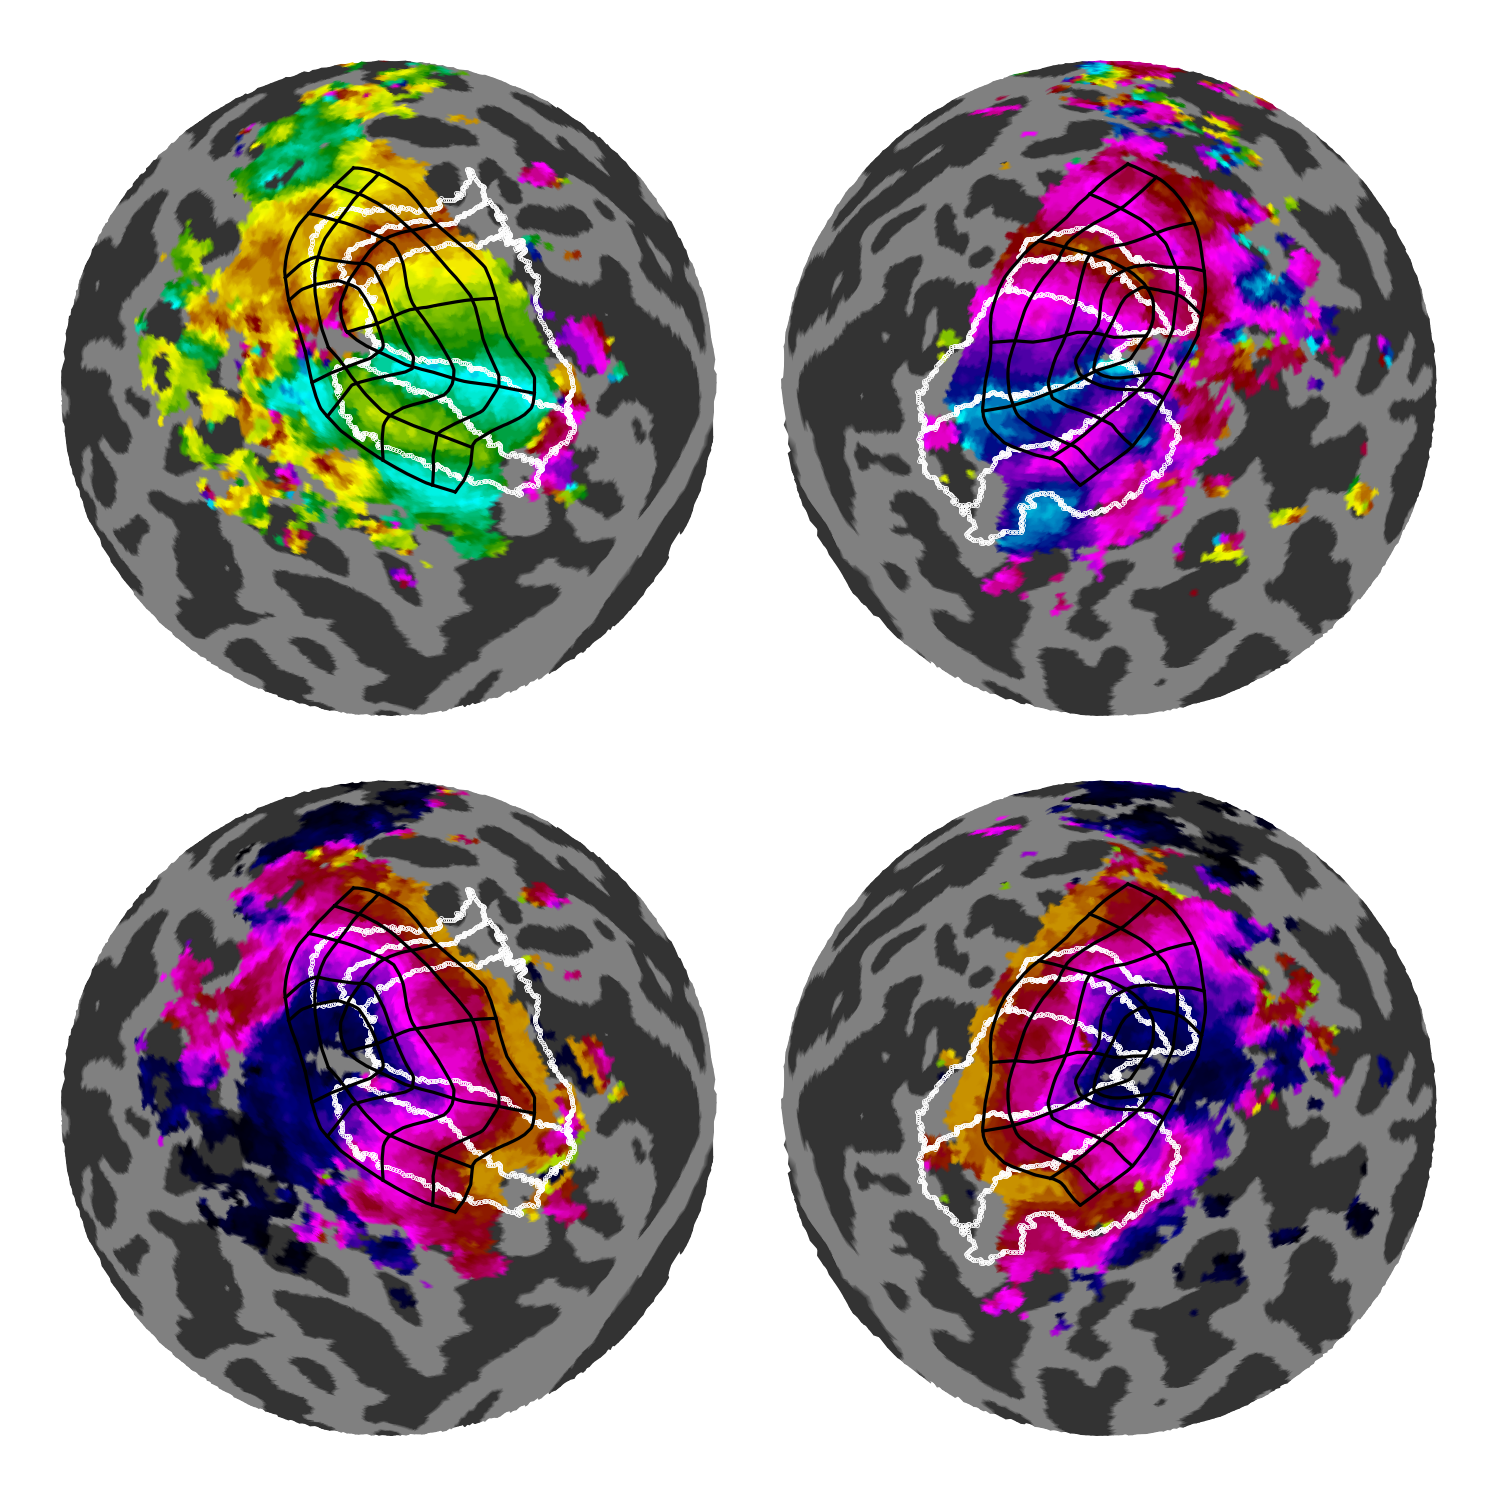

In [354]:
# This is the subject whose lines we are going to produce.
sid = 221319
# We will use the mean anatomist
anatomist = 'mean'
# And we want to see the native traces.
traces = 'native'

fig = subject_summary_figure(sid, anatomist, traces=traces, wang_atlas=True,
                             wang_ms=0.2, line_lw=0.8, line_colors={'wang15':'w'})

### Violin-plots of the Surface Areas

Here, we want to make a set of violin-plots of the total and relative surface areas of the ROIs across subjects. We start by configuring a few aspects of the plots.

In [99]:
# Should the plot include values for the coefficient of variation
# below the plots?
label_cov = True
# Which anatomists should be included?
anatomists = ['mean']
# Which dataframes should we use?
dataframes = (sarea_data, sarea_percent)
#dataframes = (sarea_nonfov_data, sarea_nonfov_percent)
# What should the histogram resolution be? This is the number of
# points sampled along the y-axis of each histogram.
hist_res = 100
# How wide should the figure be in inches?
figwidth = 7
# How many dots-per-inch should the rendered image be?
dpi = 72*8
# How thick should the axes be (linewidth)?
axes_lw = 1
# Where should we put the ticks?
ticks_sarea = [5, 10, 15, 20, 25]
ticks_hemi  = [0.04, 0.08, 0.12, 0.16, 0.20]
ticks_prcnt = [0.5, 1.0, 1.5, 2.0, 2.5]

Here we plot the data/configuration above.

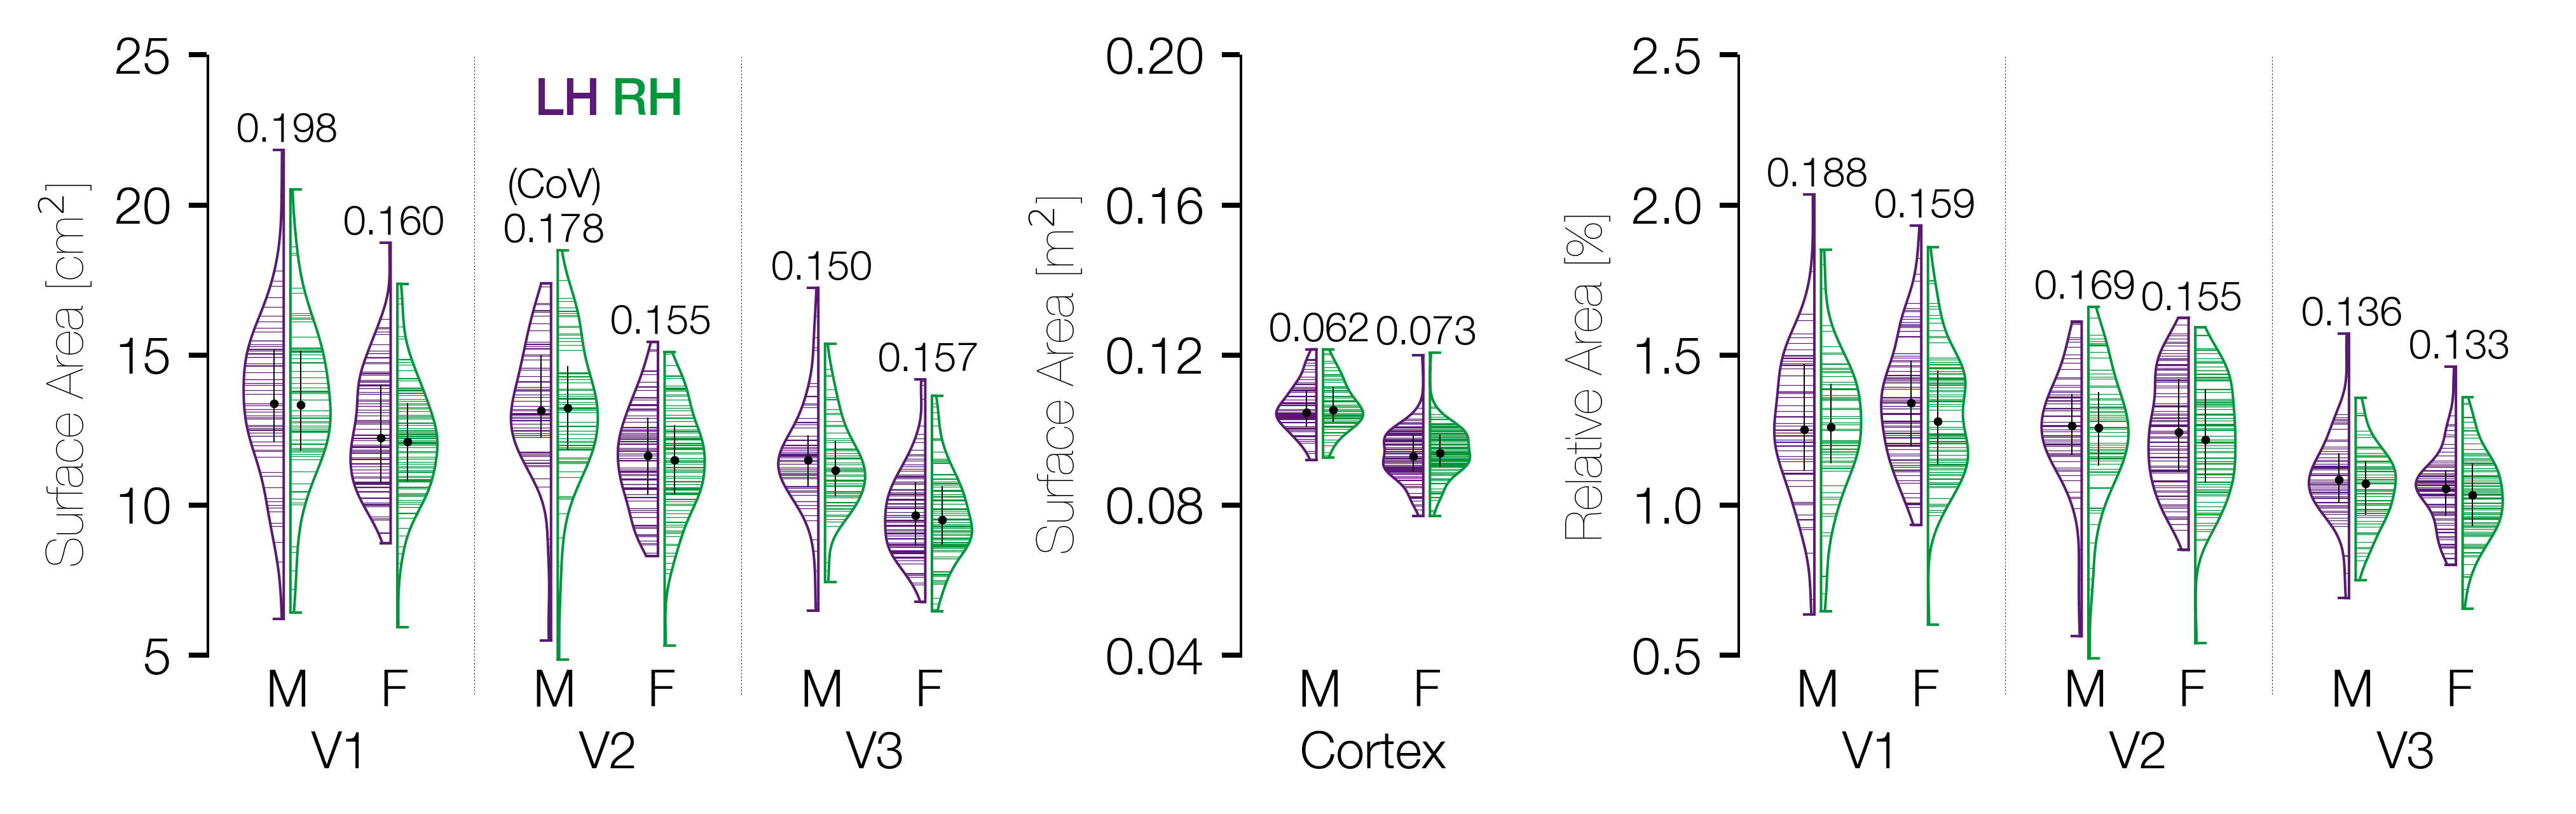

In [106]:
# We make this plot in three major steps:
# (1) Setup the figure (make the pyplot axes, get the ticks right, etc.)
# (2) Collect the data into an easily-plottable set of structures.
# (3) Make the figure via pyplot.

# We wtart by creating the figure (Step 1).
fig = plt.figure(figsize=(figwidth, figwidth * 1.75 / 7 ), dpi=dpi)
# Setup axes and labels. The image is 3 panels, the middle of which
# contains only 1 histogram and the right and of which each contain
# 3 histograms.
axlabel_space = 0.09 # amount of space an axes & label takes up
panel_space = (1 - 3*axlabel_space) / 7 # 3 axes, 7 panels
# There are 7 axes; first three axes for surface areas.
axs_sarea = [fig.add_axes([axlabel_space + panel_space*k, 0, panel_space, 1])
             for k in range(3)]
# Then one axis for the whole-cortex surface area.
ax_hemi   = fig.add_axes([axlabel_space*2 + panel_space*3, 0, panel_space, 1])
# Then three axes for percent surface area.
axs_prcnt = [fig.add_axes([axlabel_space*3 + panel_space*(k+4), 0, panel_space, 1])
             for k in range(3)]
# We can go ahead and setup some of the miscellaneous axes stuff now:
# - remove all the spines;
for ax in (axs_sarea + [ax_hemi] + axs_prcnt):
    for sp in six.itervalues(ax.spines): sp.set_visible(False)
# - setup the ticks, axes, and labels in the appropriate places;
for axs in (axs_sarea, axs_prcnt):
    for (k,ax) in zip([1,2,3],axs):
        ax.set_yticks([])
        ax.set_xticks([0])
        ax.set_xticklabels(['V%d' % k])
        ax.set_xlim([-1,1])
ax_hemi.set_xticks([0])
ax_hemi.set_xticklabels(['Cortex'])
ax_hemi.set_xlim([-1,1])
axs_sarea[0].set_ylabel(r'Surface Area [cm$^2$]')
ax_hemi.set_ylabel(r'Surface Area [m$^2$]')
axs_prcnt[0].set_ylabel('Relative Area [%]')
# Set the y-limits based on the ticks (we extend the y-limits at the bottom
# just a bit so that all the data falls in the plot).
for (axs,ticks) in zip([axs_sarea, [ax_hemi], axs_prcnt],
                       [ticks_sarea, ticks_hemi, ticks_prcnt]):
    ax = axs[0]
    ax.tick_params(width=axes_lw, color='k')
    ax.set_yticks(ticks)
    ylim = [ticks[0], ticks[-1]]
    ax.plot([-1,-1], ylim, 'k-', lw=axes_lw)
    ylim = [ylim[0] - (ylim[1]-ylim[0])/15, ylim[1]]
    for ax in axs:
        ax.set_ylim(ylim)
        ax.tick_params(axis='x', color=[1,1,1,0])

# For Step 2, we separate the data into the various groups, which we keep
# in a nested dictionary structure.
(sa,sp) = [df.loc[np.isin(df['anatomist'], anatomists)]
           for df in dataframes]

genders = {
    g: [sid for sid in data.subject_list
        if data.gender[sid] == g]
    for g in ['M','F']}
dat = {k+t: {g: {h.lower()+'h': df[kk].values*sc
                 for h in ['L','R']
                 for kk in [('lbl' if k == 'H' else 'roi')+h+k]}
             for g in ['M', 'F']
             for df in [df0.loc[np.isin(df0['sid'], genders[g])]]}
       for (k,df0,t,sc) in zip(['V1', 'V2', 'V3', 'H', 'V1', 'V2', 'V3'],
                               [sa,   sa,   sa,   sa,  sp,   sp,   sp],
                               ['sa', 'sa', 'sa', 'sa', 'pc', 'pc', 'pc'],
                               [0.01, 0.01, 0.01, 1e-6, 1, 1, 1])}

# For Step 3, we make the plot. We will use the smooth_histogram_plot()
# function for all of this, so setup the common arguments first.
kw = dict(fill='lines', resolution=hist_res, lw=0.5, filllw=0.15, height=0.3)
# Now, plot the values...
for (ax,k,t,ticks) in zip(axs_sarea + [ax_hemi] + axs_prcnt,
                          ['V1', 'V2', 'V3', 'H', 'V1', 'V2', 'V3'],
                          ['sa', 'sa', 'sa', 'sa', 'pc', 'pc', 'pc'],
                          [ticks_sarea]*3 + [ticks_hemi] + [ticks_prcnt]*3):
    kw['axes'] = ax
    # Get the area data.
    a = dat[k+t]
    for (g,off) in zip(['M','F'], [-0.4, 0.4]):
        for (h,d) in zip(['lh','rh'], [1,-1]):
            offd = off - d*0.025
            kw['base'] = [(offd,0), (offd,1)]
            kw['edgecolor'] = hemi_colors[h]
            kw['fillcolor'] = hemi_colors[h]
            kw['direction'] = d
            x = a[g][h]
            smooth_histogram_plot(x, **kw)
            # We also want to plot median and quartiles
            (q1,md,q2) = np.nanpercentile(x, [25, 50, 75])
            x0 = off - d*0.1
            ax.plot([x0,x0], [q1,q2], 'k-', lw=0.25)
            ax.scatter(x0, md, c='k', s=0.5, zorder=2)
            # Also plot makers of the absolute min and max values
            for y0 in [np.nanmin(x), np.nanmax(x)]:
                ax.plot([offd, x0], [y0, y0], '-',
                        color=hemi_colors[h], lw=kw['lw'])
        # We want to plot CoV values for both hemispheres combined
        # for this particular ROI/gender.
        yvals = np.concatenate([a[g]['lh'], a[g]['rh']])
        # This line is a quick hack to show the M+F CoVs over each pair of violin plots
        # instead of the separate M and F CoVs:
        #yvals = np.concatenate([a['M']['lh'], a['M']['rh'], a['F']['lh'], a['F']['rh']])
        ymx = np.nanmax(yvals)
        ymx += (ticks[1]-ticks[0])/4
        cov = np.nanstd(yvals) / np.nanmean(yvals)
        ax.text(off, ymx, '%4.3f' % cov, fontsize=8,
                horizontalalignment='center', verticalalignment='top')
        # Finally, print the the M/F markers.
        ymn = np.nanmin(yvals)
        ymn = ticks[0]
        ymn -= (ticks[1]-ticks[0])/4
        ax.text(off, ymn, g, horizontalalignment='center',
                verticalalignment='center')
axs_sarea[1].text(0.3, 23, 'RH', color=hemi_colors['rh'],
                  horizontalalignment='center', fontweight='medium')
axs_sarea[1].text(-0.3, 23, 'LH', color=hemi_colors['lh'],
                  horizontalalignment='center', fontweight='medium')
# Add a "CoV" label
axs_sarea[1].text(-0.4, 20, '(CoV)', fontsize=8,
                  horizontalalignment='center',
                  verticalalignment='bottom')
# Axes need spacer lines.
for ax in [axs_sarea[1], axs_sarea[2], axs_prcnt[1], axs_prcnt[2]]:
    ax.plot([-1,-1],[0,50], 'k:', lw=0.25)

if figures_path is not None:
    outpath = os.path.join(figures_path, 'surface-area_violinplots.pdf')
    plt.savefig(outpath, bbox_inches='tight')

### Mean Lines and Anatomist Agreement

One of the main things we want to be able to examine from this dataset is the average set of contour lines traced by the anatomists--across anatomists and across subjects. These cells collect these data and plot them in various ways. 

---

**Collect Data.** We start by collecting the data itself into a number of mean traces and standard deviations across those means. We can use the `data.fsaverage500_path_traces` data because it consists of the fsaverage-aligned traces split into exactly 500 points for each line; thus we can easily average or collect across the points of the lines.

In [337]:
# First, we need to collect all the subject/anatomist traces in one place.
all_trace_matrices = ny.auto_dict()
(n,m) = (len(data.anatomist_list), len(data.subject_list))
for (ai,anat) in enumerate(data.anatomist_list):
    for (si,sid) in enumerate(data.subject_list):
        d = data.fsaverage500_path_traces[anat][sid]
        if d is None: continue
        for (h,hd) in six.iteritems(d):
            if hd is None: continue
            r = all_trace_matrices[h]
            for (a,ad) in six.iteritems(hd):
                if ad is None: continue
                rr = r[a]
                for k in six.iterkeys(ad):
                    if k not in rr: rr[k] = np.full((n,m,2,500), np.nan)
                    rr[k][ai,si,:] = ad[k].points
all_trace_matrices = pimms.persist(all_trace_matrices)

# Next we want to get means and averages over these.
def map_over_traces(f, trs=all_trace_matrices):
    return pimms.persist({h: {a: {k: f(v) for (k,v) in six.iteritems(ad)}
                              for (a,ad) in six.iteritems(hd)}
                          for (h,hd) in six.iteritems(trs)})
# The mean traces:
trace_means_of_anat_over_subj = map_over_traces(lambda v:np.nanmean(v, axis=1))
trace_means_of_subj_over_anat = map_over_traces(lambda v:np.nanmean(v, axis=0))
trace_means_of_all            = map_over_traces(lambda v:np.nanmean(np.reshape(v,(-1,2,500)), axis=0))
# The standard-deviation of the trace points:
trace_stds_of_anat_over_subj  = map_over_traces(lambda v:np.nanstd(v, axis=1))
trace_stds_of_subj_over_anat  = map_over_traces(lambda v:np.nanstd(v, axis=0))
trace_stds_of_all             = map_over_traces(lambda v:np.nanstd(np.reshape(v,(-1,2,500)), axis=0))
# The norm of the standad deviation vector (i.e., sqrt(std_x**2 + std_y**2))
trace_snrms_of_anat_over_subj = map_over_traces(lambda v:np.sqrt((v[:,0] - v[:,1])**2),
                                                trace_stds_of_anat_over_subj)
trace_snrms_of_subj_over_anat = map_over_traces(lambda v:np.sqrt((v[:,0] - v[:,1])**2),
                                                trace_stds_of_subj_over_anat)

---

**The mean set of lines.** Here we just plot the mean set of lines across all anatomists and subjects.

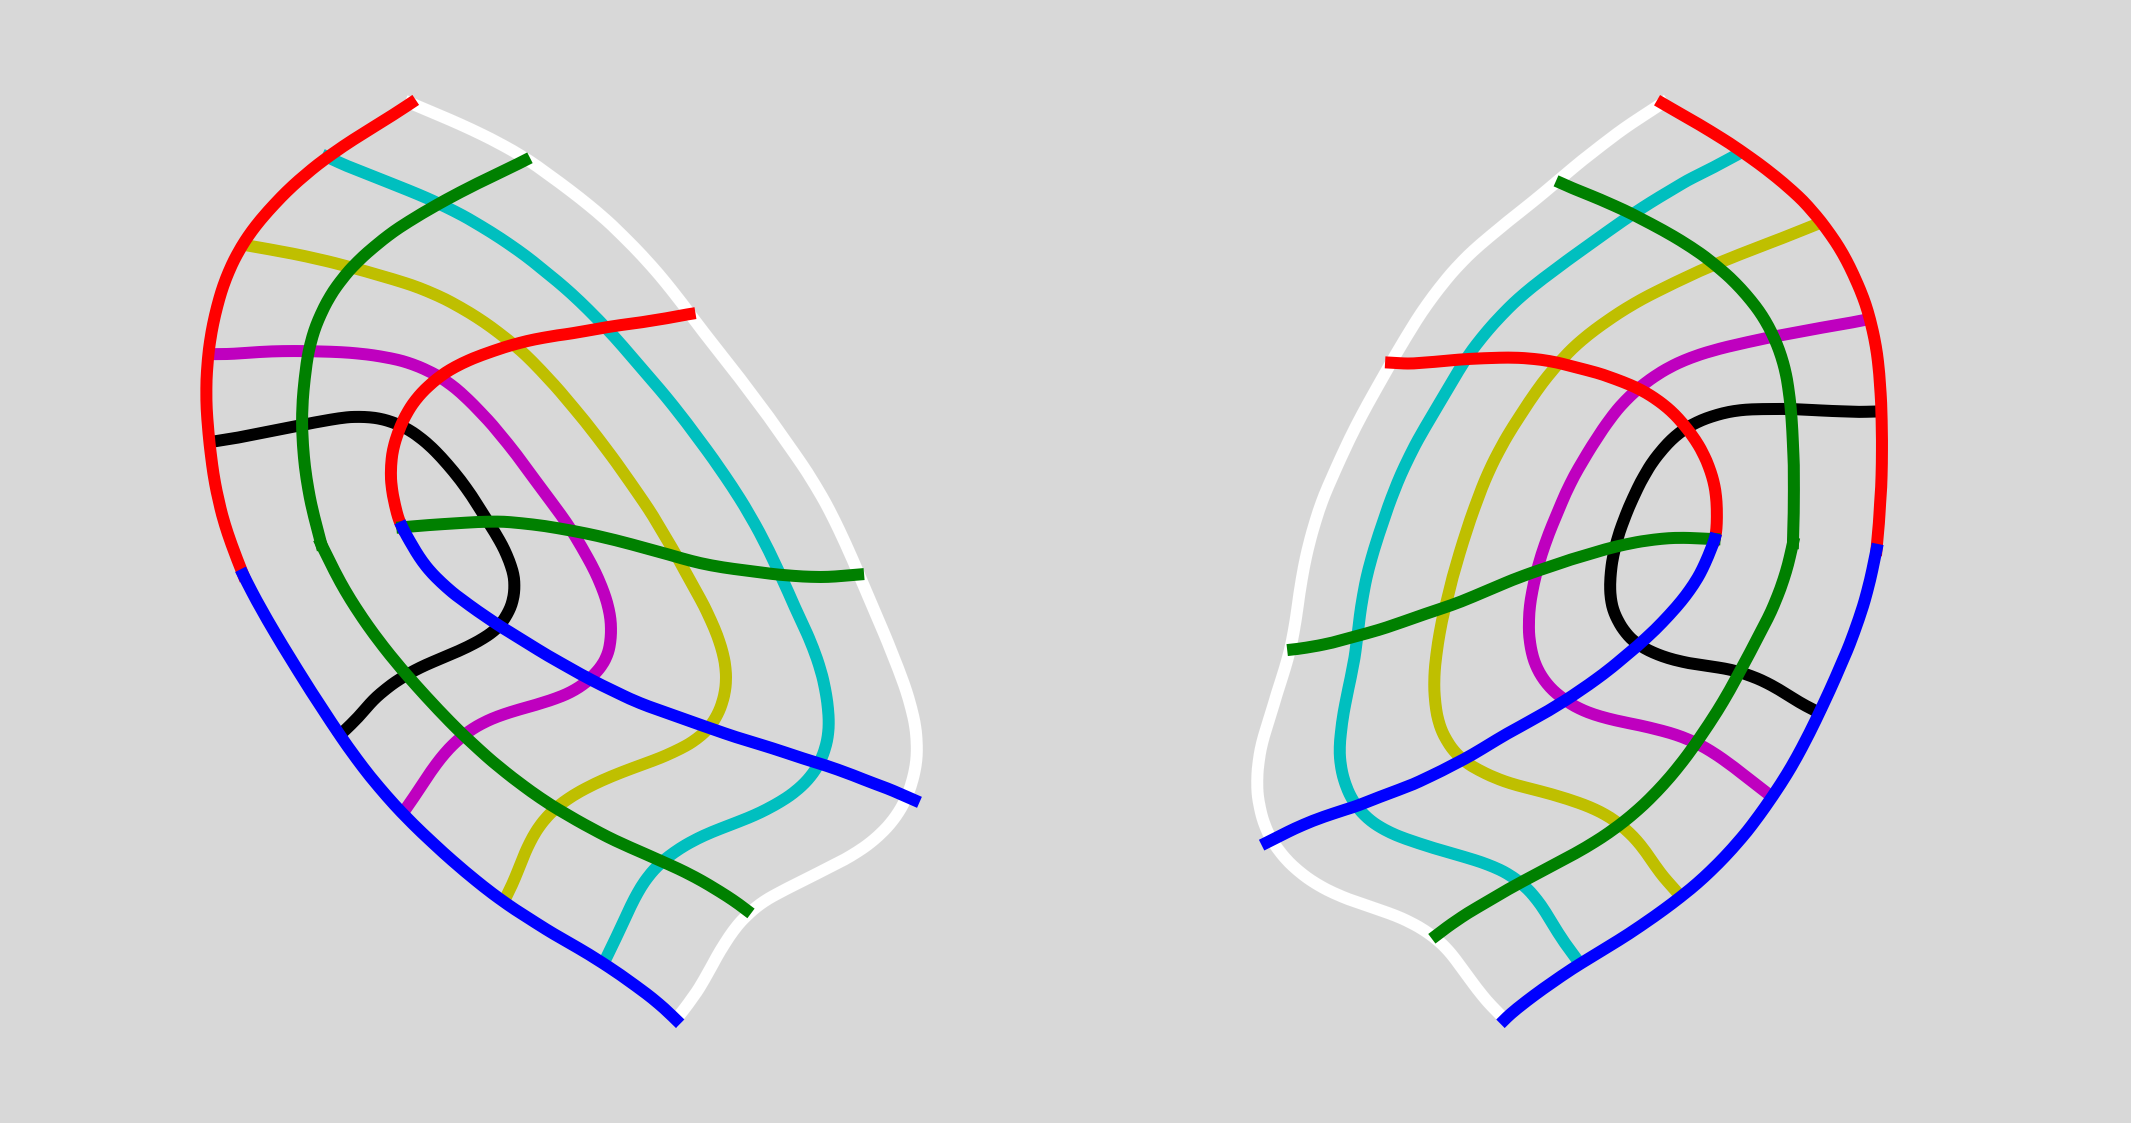

In [264]:
# These are the mean line traces.
mean_traces = data.fsaverage500_path_traces['mean'][999999]
# We will use this DPI.
dpi = 8*72
# These are the colors we will use for each line.
lncolor = {'V1_ventral':'b', 'V1_mid':'g', 'V1_dorsal':'r',
           'V2_ventral':'g', 'V2_dorsal':'g',
           'V3_ventral':'b', 'V3_dorsal':'r',
           '0.5':'k','1':'m','2':'y','4':'c','7':'w'}

# Make the figure and set it up
(fig,axs) = plt.subplots(1,2, figsize=(3.5, 3.5/2), dpi=dpi)
fig.patch.set_facecolor([0.7,0.7,0.7])
fig.patch.set_alpha(0.5)
fig.subplots_adjust(0,0,1,1,0,0)

# Make the plots for each line.
for (h,ax) in zip(['lh','rh'], axs):
    hdat = mean_traces.get(h)
    if hdat is None: continue
    for (a,adat) in six.iteritems(hdat):
        if adat is None: continue
        for (k,v) in six.iteritems(adat):
            if v is None or k not in lncolor: continue
            (x,y) = v.points
            ax.plot(x, y, '-', color=lncolor[k], lw=1.5)
            ax.axis('equal')
            ax.axis('off')
            
# Save it if required.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'mean_lines.pdf')
    plt.savefig(outpath, bbox_inches='tight', dpi=dpi,
                facecolor=fig.get_facecolor(), edgecolor='none')

---

**Plot Summary Lines.** Here we make the plot of two things:
1. The mean set of lines for each anatomist (mean across subjects)
2. A plot of the mean set of lines (across all subjects and anatomists) that shows the average disageement (across subjects) between anatomists at each point along the lines.

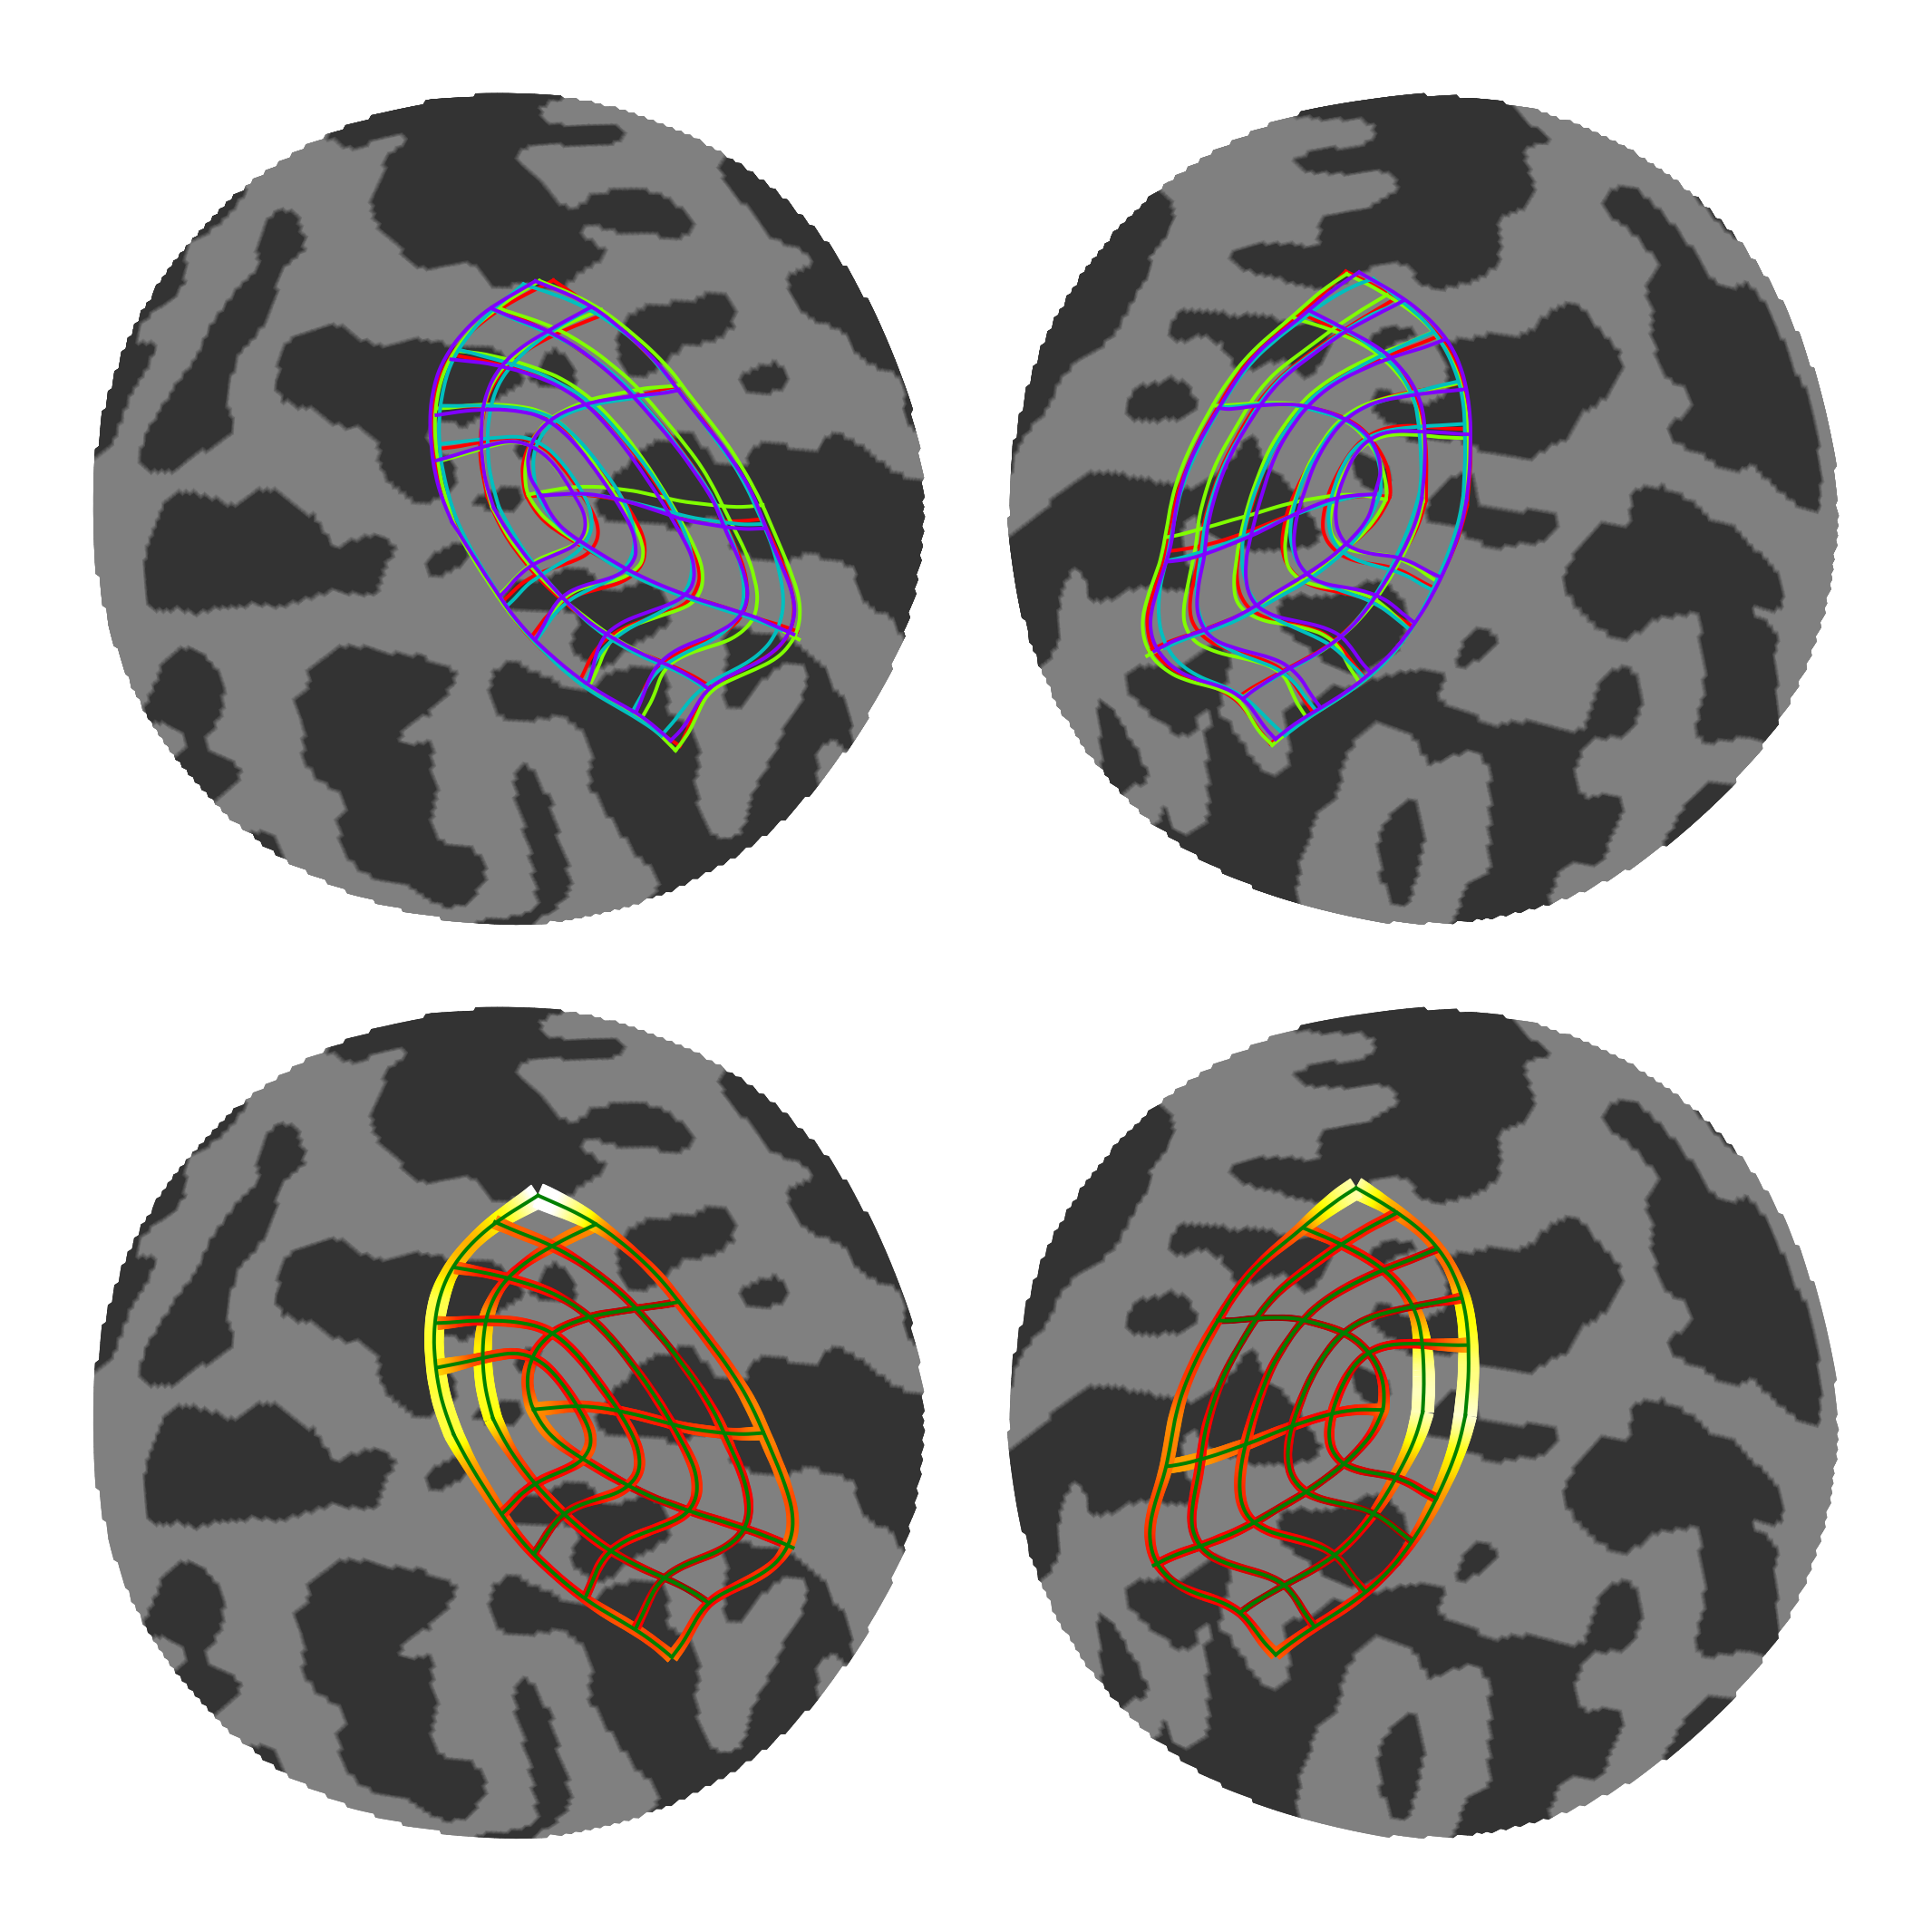

In [350]:
# These are the lines we are going to plot.
ks = ['V1_ventral', 'V1_mid', 'V1_dorsal',
      'V2_ventral', 'V2_dorsal',
      'V3_ventral', 'V3_dorsal',
      '0.5','1','2','4','7']
# For the average line-set per anatomist, we will color the anatomists using
# these colors.
clrs = ['r',  mpl.colors.hsv_to_rgb([0.25,1,1]),
        'c', mpl.colors.hsv_to_rgb([0.75,1,1])]
# We will use this (matplotlib) colormap for the anatomist-disagreement plot.
cmap = intensity_cmap
# We will use this many dots-per-inch.
dpi = 8*72

# Go ahead and setup the plots.
(fig,axs) = plt.subplots(2,2, figsize=(3.5, 3.5), dpi=dpi)
for axrow in axs:
    for ax in axrow:
        ax.axis('off')
fig.subplots_adjust(0,0,1,1,0,0)

# These are just useful for organizing the plots below.
ax0 = {'lh':axs[0,0], 'rh':axs[0,1]}
ax1 = {'lh':axs[1,0], 'rh':axs[1,1]}

# Now we can plot the lines.
# The first two are the mean lines for each anatomist.
for (ai,anat,clr) in zip(range(4), ['A1','A2','A3','A4'], clrs):
    trs = trace_means_of_anat_over_subj
    for (h,hdat) in six.iteritems(trs):
        ax = ax0[h]
        # Make an fsaverage curvature underlay.
        hemi = ny.freesurfer_subject('fsaverage').hemis[h]
        fmap = ny.to_flatmap('occipital_pole', hemi, radius=np.pi/4.0)
        ny.cortex_plot(fmap, axes=ax)
        # And plot each line.
        for (a,adat) in six.iteritems(hdat):
            for (k,v) in six.iteritems(adat):
                if k not in ks: continue
                sd = trace_snrms_of_anat_over_subj[h][a][k][ai]
                sd = sd
                (x,y) = v[ai]
                ax.plot(x, y, '-', color=clr, lw=0.5)

# The second two plots are the overall disagreements. We plot this
# in two layers; 0 is the standard deviation lines, whose widths are
# equal to ± the standard deviation; 1 is the actual mean line, which
# we plot in green.
for layer in [0,1]:
    for (h,hdat) in six.iteritems(trace_means_of_all):
        ax = ax1[h]
        # Curvature underlay.
        hemi = ny.freesurfer_subject('fsaverage').hemis[h]
        fmap = ny.to_flatmap('occipital_pole', hemi, radius=np.pi/4.0)
        qq = ny.cortex_plot(fmap, axes=ax)
        qq.set_zorder(-1)
        for (a,adat) in six.iteritems(hdat):
            for (k,v) in six.iteritems(adat):
                if k not in ks: continue
                sd = trace_snrms_of_subj_over_anat[h][a][k]
                sd = np.mean(sd, axis=0)
                (x,y) = v
                if layer == 0:
                    qq = qq0 = [lwplot(x, y, ax, lw=sd, color=sd,
                                       cmap=cmap, vmin=0.0, vmax=2)]
                else:
                    qq = ax.plot(x, y, 'g-', lw=0.5)
                for p in qq: p.set_zorder(layer)

# Save the figure if needed.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'line_deviations.png')
    plt.savefig(outpath, bbox_inches='tight', dpi=dpi)

---

**Plot all (anatomically-aligned) lines together.** We would like to be able to see how all of the lines vary in position across subjects; to see this we just want to plot them all together on the anatomically-aligned *fsaverage* surface.

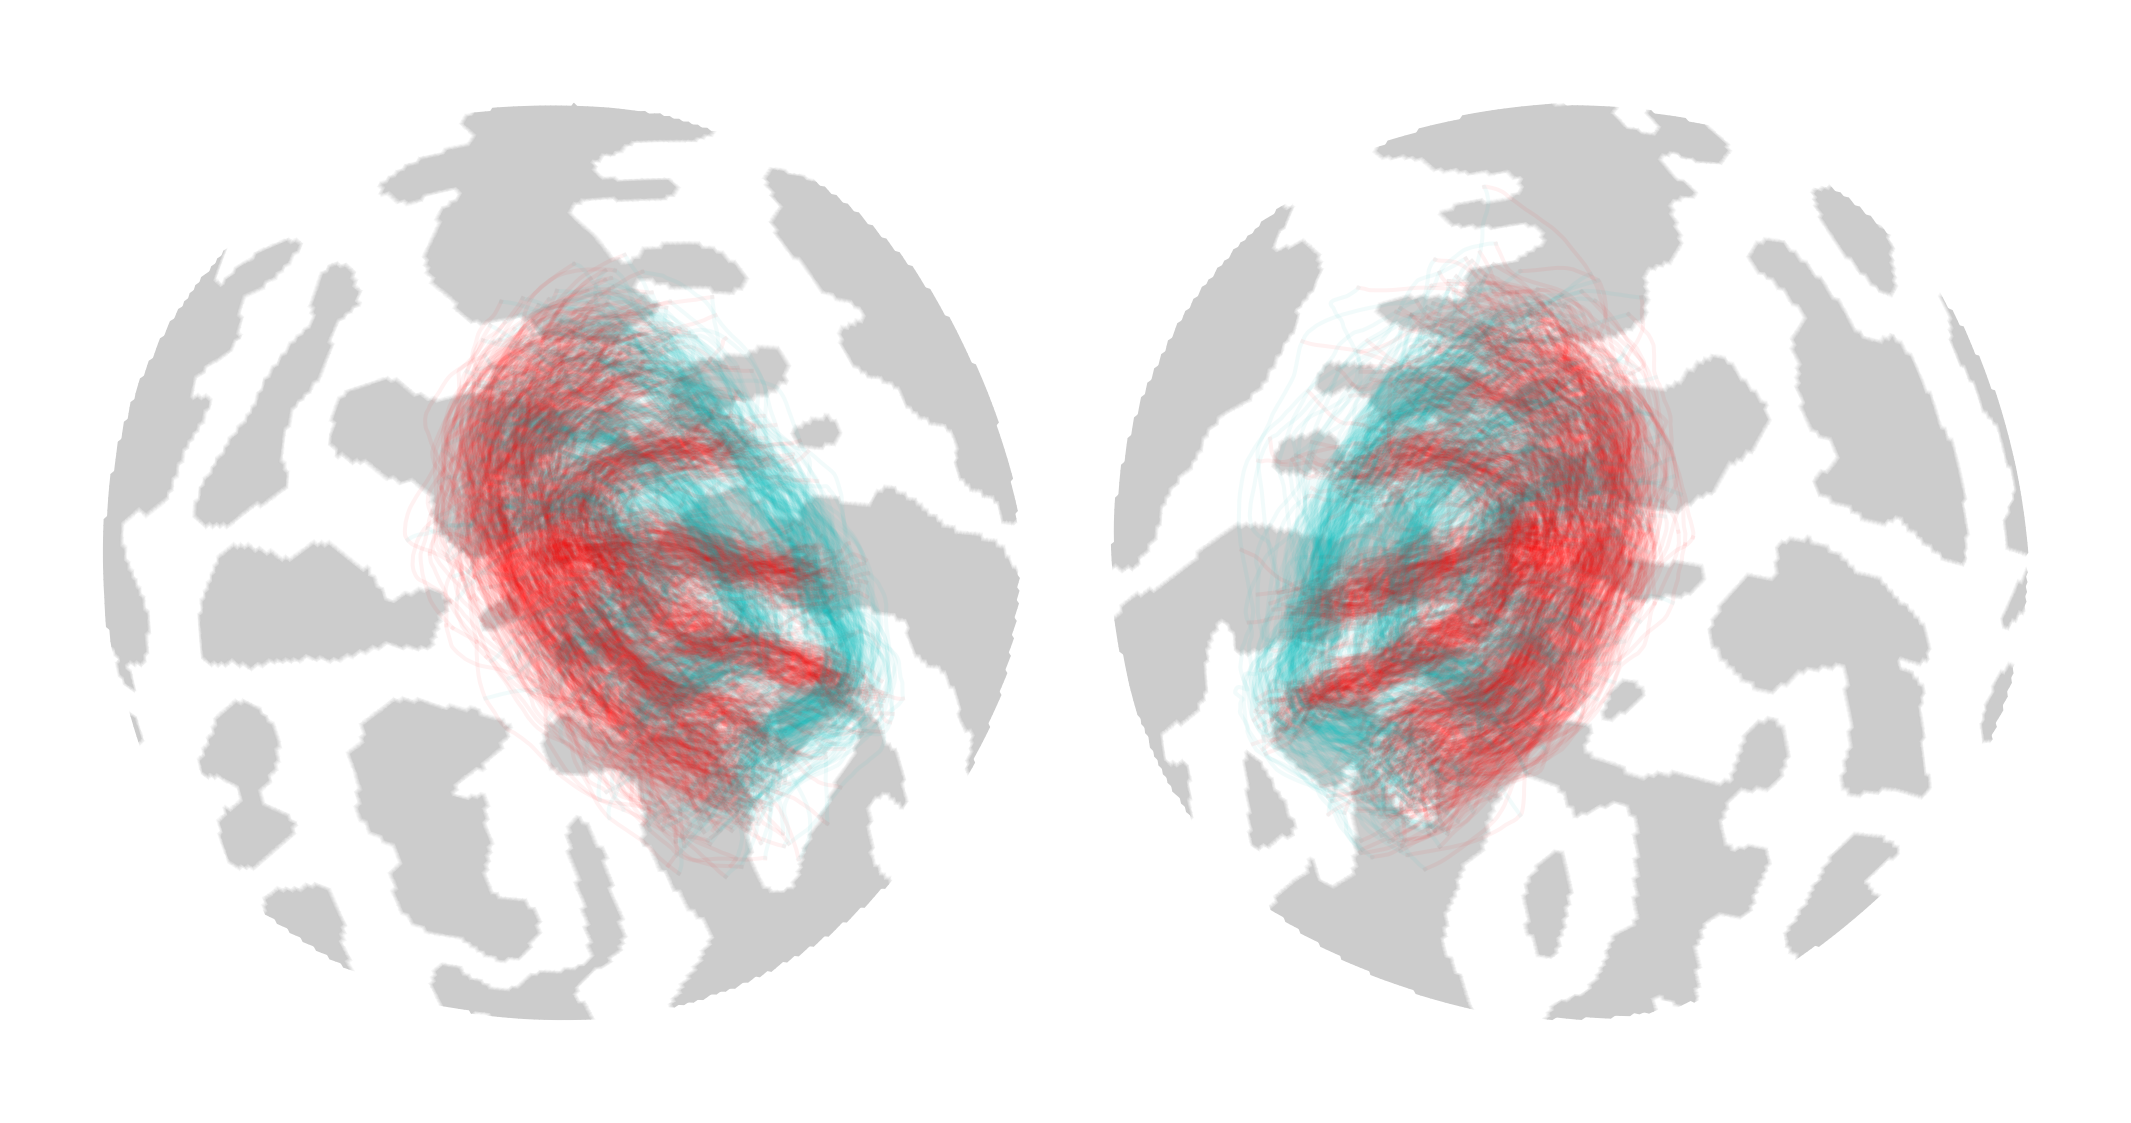

In [244]:
# These are the angle-lines we will plot.
ks_ang = ['V1_ventral', 'V1_mid', 'V1_dorsal',
          'V2_ventral', 'V2_dorsal',
          'V3_ventral', 'V3_dorsal']
# We will color the angle-lines all red.
clrs_ang = {k:'r' for k in ks_ang}
# These are the eccentricity-lines we will plot; plotting all of
# them is a bit messy, so we only plot every other.
ks_ecc = ['0.5','2','7']
#ks_ecc = ['0.5','1','2','4','7']
# We color eccentricity-lines cyan.
clrs_ecc = {k:'c' for k in ks_ecc}
# We will use this many dots-per-inch.
dpi = 8*72
# We will only plot these anatomists (just mean).
anatomists = ['mean']

# Go ahead and make the figure.
(fig,axs) = plt.subplots(1,2, figsize=(3.5, 1.75), dpi=dpi)
axs = {'lh':axs[0], 'rh':axs[1]}

# Make the plots.
for h in ['lh','rh']:
    ax = axs[h]
    # Go ahead and make a flatmap and plot the curvature underlay.
    fmap = ny.to_flatmap('occipital_pole', ny.freesurfer_subject('fsaverage').hemis[h])
    cc = fmap.prop('curvature') < 0
    q = ny.cortex_plot(fmap, axes=ax, color=(4 + cc), cmap='gray', vmin=0, vmax=5)
    q.set_zorder(-1)
    # We
    for anat in anatomists:
        trs = data.fsaverage500_path_traces[anat]
        if trs is None: continue
        # Walk through each subject.
        for (sid,sdat) in six.iteritems(trs):
            if sdat is None: continue
            hdat = sdat.get(h)
            if hdat is None: continue
            for (a,adat) in six.iteritems(hdat):
                if adat is None: continue
                for (k,v) in six.iteritems(adat):
                    if v is None: continue
                    elif k in ks_ecc: clr = clrs_ecc[k]
                    elif k in ks_ang: clr = clrs_ang[k]
                    else: continue
                    (x,y) = v.points
                    ax.plot(x, y, '-', color=clr, lw=0.5, alpha=(0.05))
for ax in six.itervalues(axs): ax.axis('off')
plt.subplots_adjust(0,0,1,1,0,0)

# Export the figure if required.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'all_lines_together.png')
    fig.savefig(outpath, dpi=dpi, pad_inches=0, bbox_inches=0)

### Intraclass Correlation (ICC) Plot

Here we construct an [ICC (Intraclass Correlation) plot](https://en.wikipedia.org/wiki/Intraclass_correlation). We do this by picking one of the anatomists (A1), sorting the subjects by the V1 size drawn by this anatomist, then plotting the sizes of the other three anatomists in this order along separate x-values (per subject). The idea is that it should be obvious by the spread of values in the y-dimension whether the anatomists agree with each other.

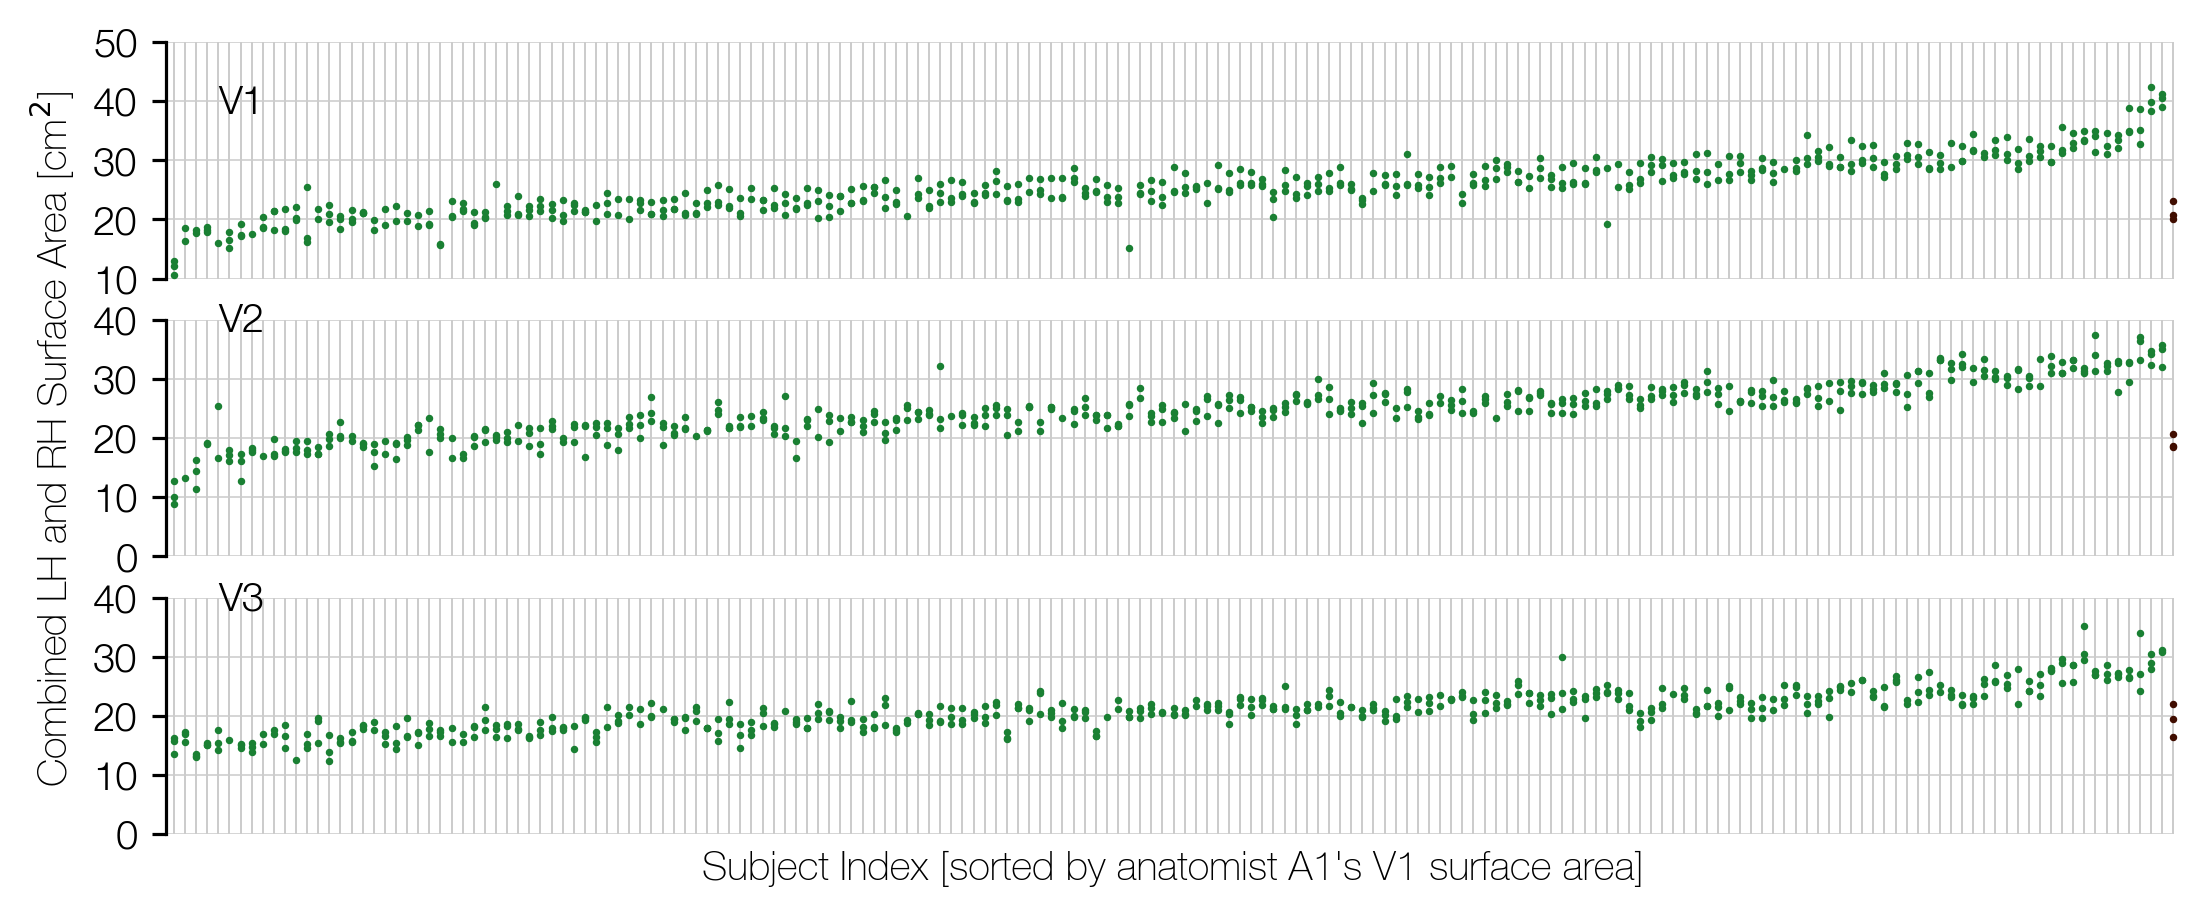

In [237]:
# We are using sarea_data rather than percent for this.
df = sarea_data
# We sort the subjects using this anatomist's sizes.
sort_anat = 'A1'
# Some subjects have invalid lines for any anatomist; we plot these in a different
# color. These are the colors we're using.
colors = {'normal': (0.1,0.5,0.2), 'missing': (0.25,0.05,0)}

# Setup the figure:
(fig,axs) = plt.subplots(3,1, figsize=(7,2.75), dpi=4*72, sharex=True)
# Get rid of spines except on the left.
for sp in ['top','right','bottom']: 
    for ax in axs: ax.spines[sp].set_visible(False)
# We want to plot each subject/anatomist as points on a vertical (subject) line:
for (va,ax) in zip([1,2,3], axs):
    # Get the visual area sizes (in mm^2)
    dfa1 = df.loc[df['anatomist'] == sort_anat]
    sas = dfa1['roiLV%d' % va].values + dfa1['roiRV%d' % va].values
    # Sort the subjects by this anatomist's area size:
    ii = np.argsort(sas)
    sids = dfa1.iloc[ii]['sid'].values
    # Some of these were sorted by NaN's; make sure we know which
    nans = ~np.isfinite(sas[ii])
    # Plot the horizontal lines
    for y in np.arange(0,51,10):
        pp = ax.plot([-0.75,len(sids)-1], [y,y], '-', color=(0.8,0.8,0.8,1), lw=0.4)
        pp[0].set_zorder(-2)
    # Now plot the actual data.
    for (x,(sid,isnan)) in enumerate(zip(sids, nans)):
        # Go ahead and plot the vertical line first.
        pp = ax.plot([x,x], [0,50], '-', color=(0.8,0.8,0.8,1), lw=0.5, zorder=-1)
        # Now extract the elevant sizes.
        ii = df['sid'] == sid
        dd = df.loc[ii]
        dd = dd.loc[~np.isin(dd['anatomist'].values, ['mean',sort_anat])]
        ys = (dd['roiLV%d' % va].values + dd['roiRV%d' % va].values) / 100.0
        ys = ys[np.isfinite(ys)]
        clr = colors['missing' if isnan else 'normal']
        ax.scatter([x]*len(ys), ys, c=[clr], s=0.75)
    ax.text(4, 38, 'V%d' % va)

# Setup the labels and axes.
axs[1].set_ylabel(r'Combined LH and RH Surface Area [cm$^2$]')
axs[2].set_xlabel("Subject Index [sorted by anatomist A1's V1 surface area]")
for ax in axs[:2]: ax.set_xticks([])
for ax in axs:
    ax.set_ylim([10,50] if ax is axs[0] else [0,40])
    ax.set_yticks([10,20,30,40,50] if ax is axs[0] else [0,10,20,30,40])
    ax.set_xlim([-0.75,len(sids)-0.25])
fig.subplots_adjust(0,0,1,1,0,0.175)

# Export the figue.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'iccplot.pdf')
    plt.savefig(outpath, bbox_inches='tight')

In this cell, we plot the same data as above, but we stretch the plot out to be taller, we plot only V1 on the (stretched) axis. We also leave off the subjects that have a bad line-set or fewer than 3 anatomists with acceptable line-sets. The code can easily be tweaked to show V2 or V3.

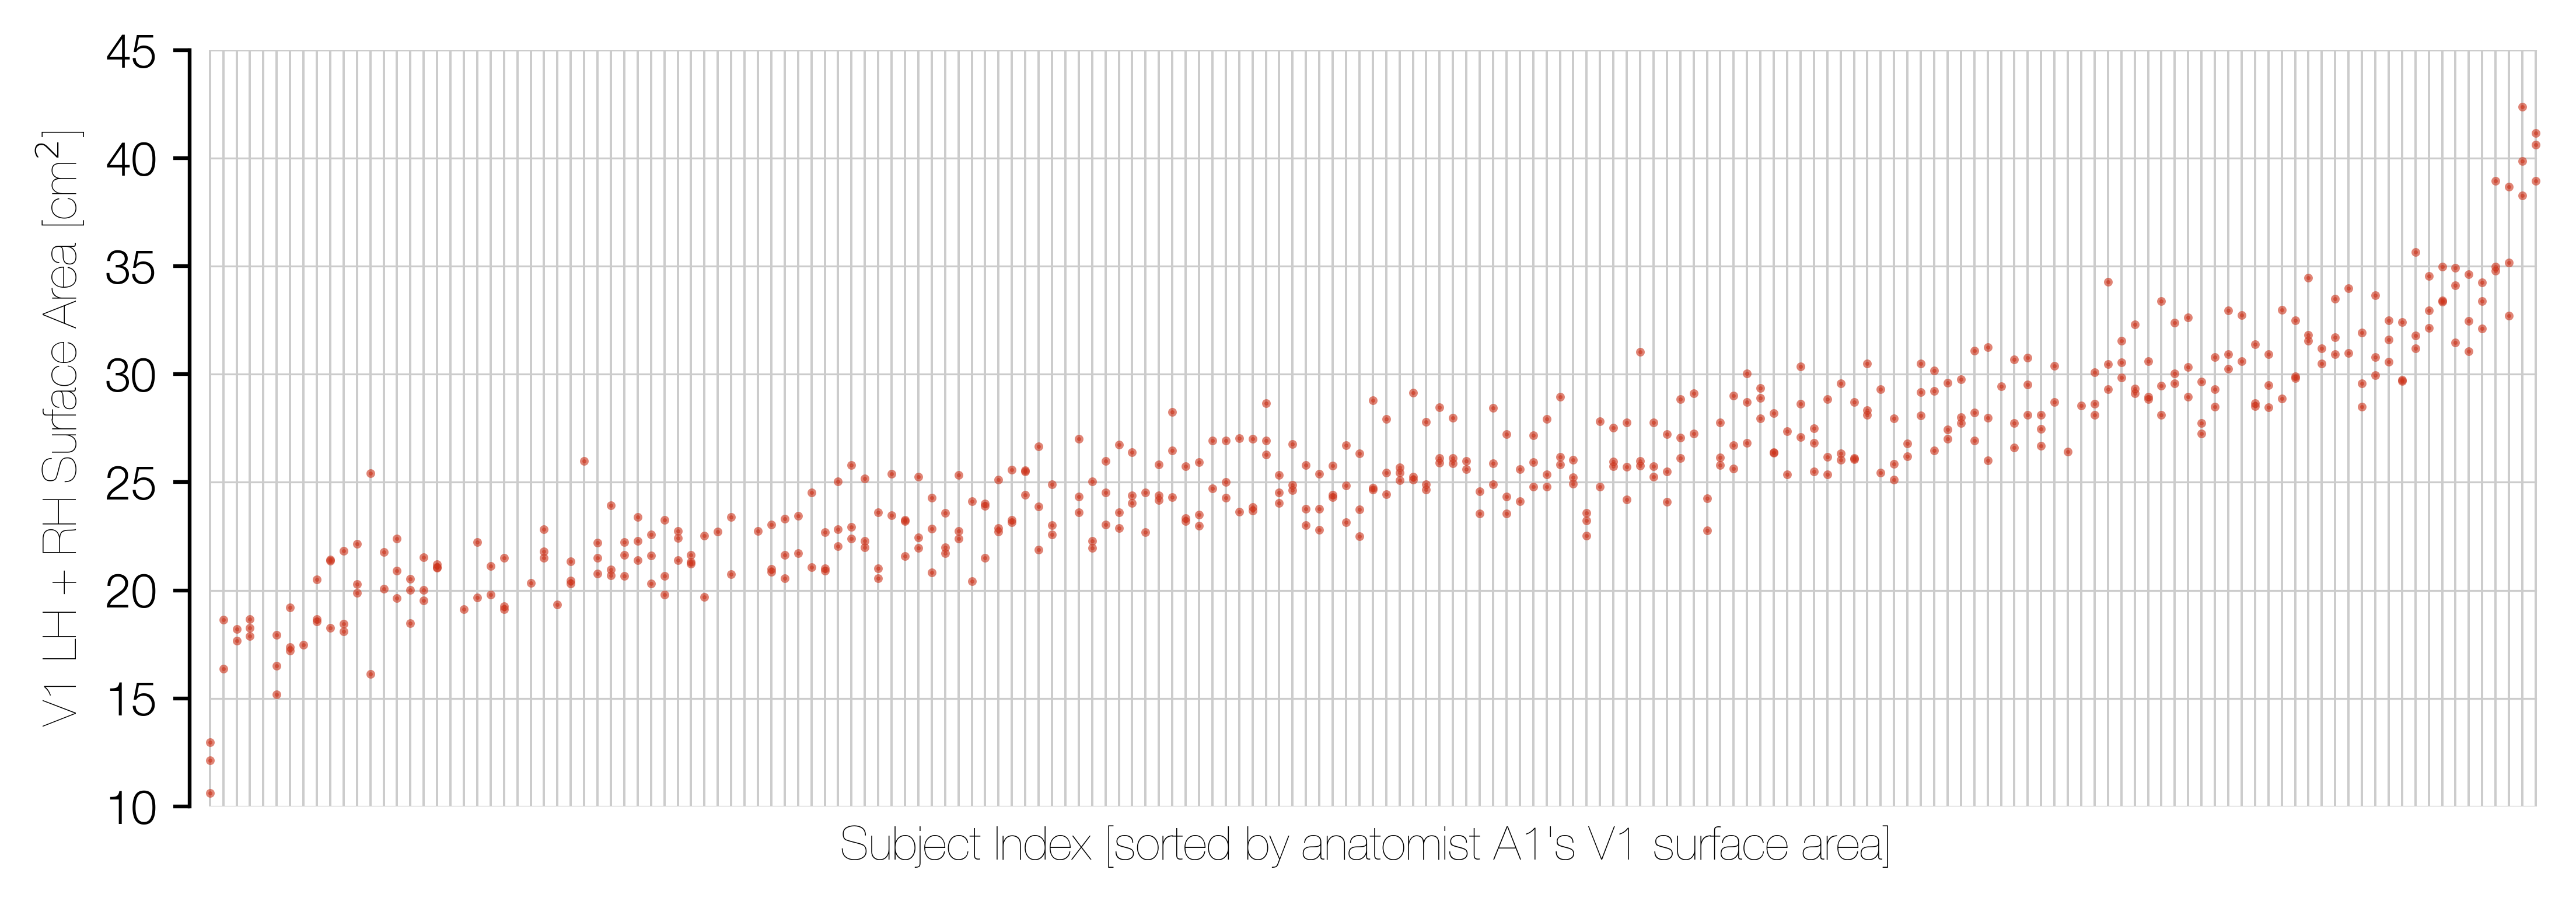

In [112]:
# We are using sarea_data rather than percent for this.
df = sarea_data
# We sort the subjects using this anatomist's sizes.
sort_anat = 'A1'
# Some subjects have invalid lines for any anatomist; we plot these in a different
# color. These are the colors we're using.
alpha = 0.6
colors = {1:(0.8,0.2,0.1,alpha),
          2:(0.1,0.5,0.2,alpha),
          3:(0.1,0.2,0.8,alpha)}

# Setup the figure:
(fig,ax) = plt.subplots(1,1, figsize=(7,2.25), dpi=8*72)
# Get rid of spines except on the left.
for (k,v) in six.iteritems(ax.spines):
    v.set_visible(k == 'left')
# Find the sorted order.
dfa1 = df.loc[df['anatomist'] == sort_anat]
sas = dfa1['roiLV1'].values + dfa1['roiRV1'].values
# Sort the subjects by this anatomist's area size:
ii = np.argsort(sas)
# Some of these were sorted by NaN's; make sure we exclude them
ii = ii[np.isfinite(sas[ii])]
# Get the subject ids that go with these sorted values.
sids = dfa1.iloc[ii]['sid'].values
# Plot the horizontal lines
for y in range(10,46,5):
    pp = ax.plot([0,len(sids)-1], [y,y], '-', color=(0.8,0.8,0.8,1), lw=0.4)
    pp[0].set_zorder(-2)
# We want to plot each subject/anatomist as points on a vertical (subject) line:
for (va) in [1,2,3]:
    if va != 1: continue
    # Now plot the actual data.
    for (x,sid) in enumerate(sids):
        # Go ahead and plot the vertical line first.
        pp = ax.plot([x,x], [0,50], '-', color=(0.8,0.8,0.8,1), lw=0.5, zorder=-1)
        # Now extract the elevant sizes.
        ii = df['sid'] == sid
        dd = df.loc[ii]
        dd = dd.loc[~np.isin(dd['anatomist'].values, ['mean',sort_anat])]
        ys = (dd['roiLV%d' % va].values + dd['roiRV%d' % va].values) / 100.0
        ys = ys[np.isfinite(ys)]
        clr = colors[va]
        ax.scatter([x]*len(ys), ys, c=[clr], s=0.75)
    #ax.text(4, 38, 'V%d' % va)

# Setup the labels and axes.
ax.set_ylabel(r'V1 LH + RH Surface Area [cm$^2$]')
ax.set_xlabel("Subject Index [sorted by anatomist A1's V1 surface area]")
ax.set_xticks([])
ax.set_xlim([-1.5,len(sids)-0.5])
ax.set_ylim([10,45])
ax.set_yticks([10,15,20,25,30,35,40,45])
fig.subplots_adjust(0,0,1,1,0,0)

# Export the figue.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'iccplot_area-v1.pdf')
    plt.savefig(outpath, bbox_inches='tight')

If we fit a general linear model to the surface area data, we should hopefully see more variance explained by differences between subjects than by differences between anatomists. This cell performs this fit and prints the variance explained by each component.

In [226]:
df  = sarea_data
lbl = 3
mtx = {anat: np.sum(df.loc[df['anatomist'] == anat][['roiLV%d'%lbl, 'roiRV%d'%lbl]].values, axis=1)
        for anat in ['A1','A2','A3','A4']}
mtx = np.transpose([mtx[anat] for anat in ['A1','A2','A3','A4']]) / 100.0

ok  = np.sum(np.isfinite(mtx), axis=1) > 2
mtx = mtx[ok,:]

x = mtx.flatten()
aa = np.matlib.repmat([0,1,2,3], len(mtx), 1).flatten()
ss = np.matlib.repmat(np.arange(len(mtx)), 4, 1).T.flatten()

ok = np.isfinite(x)
x = x[ok]
aa = aa[ok]
ss = ss[ok]

afactors = np.transpose([aa == 0, aa == 1, aa == 2, aa == 3])
sfactors = np.transpose([ss == s for s in range(len(mtx))])
factors = np.hstack([np.ones(len(x))[:,None], afactors, sfactors])

ok = np.isfinite(x)
x = x[ok]
factors = factors[ok,:]

sol = np.linalg.lstsq(factors, x, rcond=None)

msol = sol[0][0]
asol = sol[0][1:5]
ssol = sol[0][5:]

asig = np.dot(afactors, asol)
ssig = np.dot(sfactors, ssol)

xv = np.var(x)
sv = np.var(ssig)
av = np.var(asig)
uv = np.var(x - asig - ssig)

print('Total Variance:       ', xv)
print('Subject Variance:     ', sv, '(%5.3f%%)' % (100*sv/xv,))
print('Anatomist Variance:   ', av, '(%5.3f%%)' % (100*av/xv,))
print('Unexplained Variance: ', uv, '(%5.3f%%)' % (100*uv/xv,))

Total Variance:        13.225472960435594
Subject Variance:      11.804259709376481 (89.254%)
Anatomist Variance:    0.17385902362773772 (1.315%)
Unexplained Variance:  1.2476878718554776 (9.434%)


### Cortical Magnification

Cortical magnification is a property of the mapping of the visual field onto the cortical surface. It specifies the number of mm$^2$ of cortex represent 1 deg$^2$ of the visual field at a certain point. It can be calculated in a number of ways:
* by taking the surface area of one of the sectors or ROIs from the HCP-lines dataset and dividing it by the area of the region of the visual field that the sector/ROI represents; or
* by accumulating vertices in a moving window of the visual field (e.g., a moving window shaped like a ring of eccentricity that moves from the fovea to the periphery) and dividing the sum of their surface areas by the area of the moving window.

We will combine these methods in this section to look at the distribution of cortical magnification across subjects. We start by collecting the data necessary to calculate cortical magnification.

#### Prepare Data

---

**`movwin_vmag`**

This first cell collects a set of matrices, one per visual area (V1, V2, V3). Each matix represents subjects along the rows and eccentricities along the columns; the cells indicate visual magnification at that eccentricity for that subject. We collect these matrices along with various other data into data-structure object in the dictionary `movwin_vmag`. `movwin_vmag[k]` is the data for area V`k`.

In [33]:
# To calculate C.Mag. using the moving-window shaped like an 
# eccentricity ring, we will need to know the size of the moving
# window. This is defined in terms of the fraction of points in
# the visual area that should be included in the window.
winfrac = 0.2
# This is the resolution of sampling in eccentricity space. (The
# actual points will be log-spaced, but this is their count.)
resolution = 100
# The min and max eccentricity to include.
min_eccen = 0.25
max_eccen = 7
# We're going to use this hemisphere; the value may be 'lh' or 
# 'rh' for left or right hemisphere, or 'lr' for both combined.
h = 'lr'

# We will need to use a KDTree for this
try: from scipy.spatial import cKDTree as KDTree
except Exception: from scipy.spatial import KDTree

# We build things up in terms of the vmag because it in some
# ways more tractable. We want to be able to calculate the
# median visual magnification per subject in terms of the
# eccentricity, so we create a matrix whose columns correspond
# to positions of the moving eccentricity window:
logminecc = ny.to_logeccen(min_eccen)
logmaxecc = ny.to_logeccen(max_eccen)
eccen_points = np.linspace(logminecc, logmaxecc, resolution)
eccen_points = ny.from_logeccen(eccen_points)
# We will build up the summaries as a set of data structures,
# one per visual area (V1, V2, V3).
movwin_vmag = ny.auto_dict(None, [])
for l in [1,2,3]:
    # Grab the relevant data from the dataframe.
    ii = data.dataframe['visual_area'] == l
    df = data.dataframe.loc[ii]
    # We'll build-up a set of vmags (inverse of cmag) and
    # normalized vmags as well as the subject-id that goes
    # with them. The normalized vmags are visual-areas/deg^2
    # instead of mm^2/deg^2.
    # The vmag and normalized-vmag values will be matrices
    # where columns represent eccen_points and rows
    # represent subjects.
    (vms,nvms,sids) = ([], [], [])
    for sid in data.subject_list:
        # Grab the relevant part of the dataframe.
        dfs = df.loc[(df['subject'] == sid)]
        if h != 'lr': dfs = dfs.loc[(dfs['hemi'] == h)]
        if len(dfs) == 0: continue
        # Get the relevant values for calculating vmag.
        x = dfs['prf_eccentricity'].values
        s = dfs['midgray_surface_area'].values
        ve = dfs['prf_variance_explained'].values
        # We want to exclude vertices with low confidence from
        # these calculations (they may be in the wrong places).
        ii = (ve > 0.04)
        (x,s) = [u[ii] for u in (x,s)]
        # Calculate the normalized surface area as well (units
        # are fraction of the visual area).
        snorm = s / np.nansum(s)
        # Setup a spatial hash for eccentricity only.
        sh = KDTree(np.reshape(x, (-1,1)))
        # At each eccen point, find the surface area of the
        # nearest <winfrac> fraction of the points.
        ii = sh.query(np.reshape(eccen_points, (-1,1)),
                      int(np.ceil(winfrac*len(x))))[1]
        # Total up the surface area of these points.
        satot = np.sum(s[ii], axis=1)
        satotnorm = np.sum(snorm[ii], axis=1)
        # Divide be the eccentricity-ring's visual area
        (emn,emx) = [f(x[ii], axis=1) for f in (np.min,np.max)]
        vatot = np.pi*(emx**2 - emn**2) * (1 if h == 'lr' else 0.5)
        vms.append(vatot / satot)
        nvms.append(vatot / satotnorm)
        sids.append(sid)
    # At this point, we have calculated the vmags. We can convert these
    # to cmags as well, then store them and some summary data in
    # preparation to turn them into a dataframe.
    vm = np.array(vms)
    cm = 1.0/vm
    nvm = np.array(nvms)
    ncm = 1.0/nvm
    # We use these quantiles.
    quantiles = [2.5,25,50,75,97.5]
    res = dict(subjects=sids, hemi=h,
               vmag_matrix=vm, norm_vmag_matrix=nvm,
               cmag_matrix=cm, norm_cmag_matrix=ncm,
               eccentricity=eccen_points,
               vmag_quantiles=np.nanpercentile(vm, quantiles, axis=0),
               cmag_quantiles=np.nanpercentile(cm, quantiles, axis=0),
               norm_vmag_quantiles=np.nanpercentile(nvm, quantiles, axis=0),
               norm_cmag_quantiles=np.nanpercentile(ncm, quantiles, axis=0))
    # Bundle that all up into a data-structue.
    movwin_vmag[l] = ny.util.data_struct(res)

---

**`sector_vmag`**

Additionally we want to be able to plot the cortical magnification implied by various sector boundaries. We collect these data into a dataframe in the following cell

In [34]:
# We can extract the data from the surface area dataframe.
# We can start by limiting our dataframe to the mean anatomist.
df = data.surface_area_dataframe
df = df.loc[df['anatomist'] == 'mean']

# These are the eccentricity rings of the sectors and their areas.
erings = {0:(0,0.5), 1:(0.5,1), 2:(1,2), 3:(2,4), 4:(4,7)}
ering_varea = {k:np.pi*(v[1]**2 - v[0]**2)
               for (k,v) in six.iteritems(erings)}
# And these are the surface areas of specific sectors.
sct_varea = {('sct%%sV%d%s%d' % (va, vd, er)): ering_varea[er] * 0.25
             for va in [1,2,3] for vd in ['v','d'] for er in [1,2,3,4]}
sct_varea['sct%sV1v0'] = 0.25 * np.pi * 0.5**2
sct_varea['sct%sV1d0'] = 0.25 * np.pi * 0.5**2
sct_varea['roi%sV2fov'] = 0.5 * np.pi * 0.5**2
sct_varea['roi%sV3fov'] = 0.5 * np.pi * 0.5**2
# Convert the %%s's and %s's above (which are now all %s's) into L/R.
sct_varea = {(k%h):v for h in ['L','R'] for (k,v) in six.iteritems(sct_varea)}
# We will now build up vmags of each sector.
sector_vmag = {k:[] for k in six.iterkeys(sct_varea)}
for k in six.iterkeys(sct_varea): sector_vmag['norm_' + k] = []
sector_vmag['sid'] = []
# Turn each row into a vmag; group them by sector name.
for (ii,r) in df.iterrows():
    sid = r['sid']
    if any(('mean',sid,h) in data.exclusions for h in ['lh','rh']): continue
    for (k,varea) in six.iteritems(sct_varea):
        sector_vmag[k].append(varea / r[k])
    for (k,varea) in six.iteritems(sct_varea):
        sector_vmag['norm_' + k].append(varea / (r[k] / r['roi%s' % (k[3:6],)]))
    sector_vmag['sid'].append(sid)
sector_vmag = ny.to_dataframe(sector_vmag)

---

**`mean_sector_traces`**, and **`mean_area_traces`**

Finally, in order to plot some of the data as a schematic of the mean set of lines, we need to know the traces for the mean sectors and the mean areas. (This may take awhile to calculate.)

In [35]:
mean_path_traces = data.fsaverage500_path_traces['mean'][999999]
mean_sector_traces = data._calculate_sectors({'mean':{'mean':mean_path_traces}}, 'mean', 'mean')
mean_area_traces = data._calculate_areas({'mean':{'mean':mean_path_traces}}, 'mean', 'mean')

INFO:root:HCPDataset: Getting HCP subject list...


---

**`area_halfeccen`**

Something we'd like to be able to compare across visual areas is how "steep" the cortical magnification is. This can be summarized fairly simply in terms of the eccentricity that divides the visual area into two halves of equal surface areas. A steep cortical magnification would have a low half-eccentricity (e.g. 1°) while a shallow magnification might split the visual area in half at 8°.

In order to plot these across subjects, we want to calculate that half-eccentricity point. We do this via models--we fit Horton and Hoyt's equation to each subject's cortical magnifications and infer the halfway point from that fit. Note that this cell can take awhile to run.

In [36]:
# We'll use neuropythy's optimization module for this.
import neuropythy.optimize as op
# We will step through the visual areas and build up these
# values for each.
area_halfeccen = ny.auto_dict(None, [])
for lbl in [1,2,3]:
    #print("Fitting area V%d..." % lbl)
    # We use the normalized vmag/cmag so that we can fit in terms of
    # fractions of the total cortical surface area.
    cm = movwin_vmag[lbl].norm_cmag_matrix
    x = movwin_vmag[lbl].eccentricity
    sids = movwin_vmag[lbl].subjects
    # We exclude everything over 7° of eccentricity due to edge-effects.
    ii = x < 7
    cm = np.asarray(cm)[:,ii]
    x = x[ii]
    n = len(cm)
    # We now need to fit these using a version of the H&H equation that is
    # appropriate for the normed cmag:
    # cmag_ca [cortical-areas / deg^2] = c / (eccen + e0)^2
    # Where e0 is in degrees and is identical to its use in H&H's equation
    # and c is in units of cortical-areas (e.g., cmag = 0.05 V1's / deg^2,
    # so c has units of V1's).
    # We will walk through each subject and fit this equation.
    for (k,y) in enumerate(cm):
        # Setup the optimization.
        params = op.identity
        # Our parameters:
        (c, e0) = (params[0], params[1])
        # The predicted value is this:
        yhat = op.abs(c) / (op.abs(e0) + x)**2
        # We just want to minimize the sum-of-squares between y and yhat.
        rss = op.sum(((yhat) - (y))**2)
        # For starting parameters, we can use Horton and Hoyt's e0 = 0.75;
        # for the c, we need to modify this to be a good starting value
        # in units of the visual field instead of degrees. This works out
        # to about 0.11.
        (c,e0) = np.abs(rss.argmin([0.11, 0.75]))
        # We can find the half-way point in terms of eccentricity by
        # solving for 1/2 in the equation now. Unfortunately, this also
        # needs to be done numerically--there isn't a closed form of the
        # equation that I could find. The general equation is:
        # 2 c pi (log(e + e0) - log(e0) - (e/(e + e0))) = cortical fraction
        de = params[0]
        e = op.abs(de) + e0 # we correct for this later; it forces valid values
        cfrac = (op.log(e + e0) - np.log(e0) - e/(e + e0)) * np.pi * c * 2
        halfecc = np.abs(((cfrac - 0.5)**2).argmin([2.58])[0]) + e0
        # Now we just append these to the relevant frame
        area_halfeccen['sid'].append(sids[k])
        area_halfeccen['visual_area'].append(lbl)
        area_halfeccen['c'].append(c)
        area_halfeccen['e0'].append(e0)
        area_halfeccen['halfeccen'].append(halfecc)
area_halfeccen = ny.to_dataframe(area_halfeccen)

In [37]:
heccs = ny.auto_dict(None, [])
for sid in data.subject_list:
    sub = data.subjects[sid]
    ec0 = np.concatenate([sub[h].prop('prf_eccentricity') for h in ['lh','rh']])
    va0 = np.concatenate([sub[h].prop('visual_area') for h in ['lh','rh']])
    sa0 = np.concatenate([sub[h].prop('midgray_surface_area') for h in ['lh','rh']])
    for ll in [1,2,3]:
        ii = np.where(va0 == ll)[0]
        ii = ii[ec0[ii] <= 7]
        ii = ii[np.argsort(ec0[ii])]
        ec = ec0[ii]
        sa = sa0[ii]
        cs = np.cumsum(sa)
        mid = np.searchsorted(cs, 0.5*cs[-1])
        heccs['sid'].append(sid)
        heccs['visual_area'].append(ll)
        heccs['halfeccen'].append(np.mean([ec[mid-1], ec[mid]]))
heccs = ny.to_dataframe(heccs)

<ipython-input-37-62f72c99d570>:9: RuntimeWarning: invalid value encountered in less_equal
  ii = ii[ec0[ii] <= 7]


#### Cortical Magnification in Terms of Eccentricity.

The first plot we want to make is a plot of cortical magnification across subjects in terms of eccentricity. We can plot both the c. mag. calculated from the moving-window as well as that calculated from the the sectors.

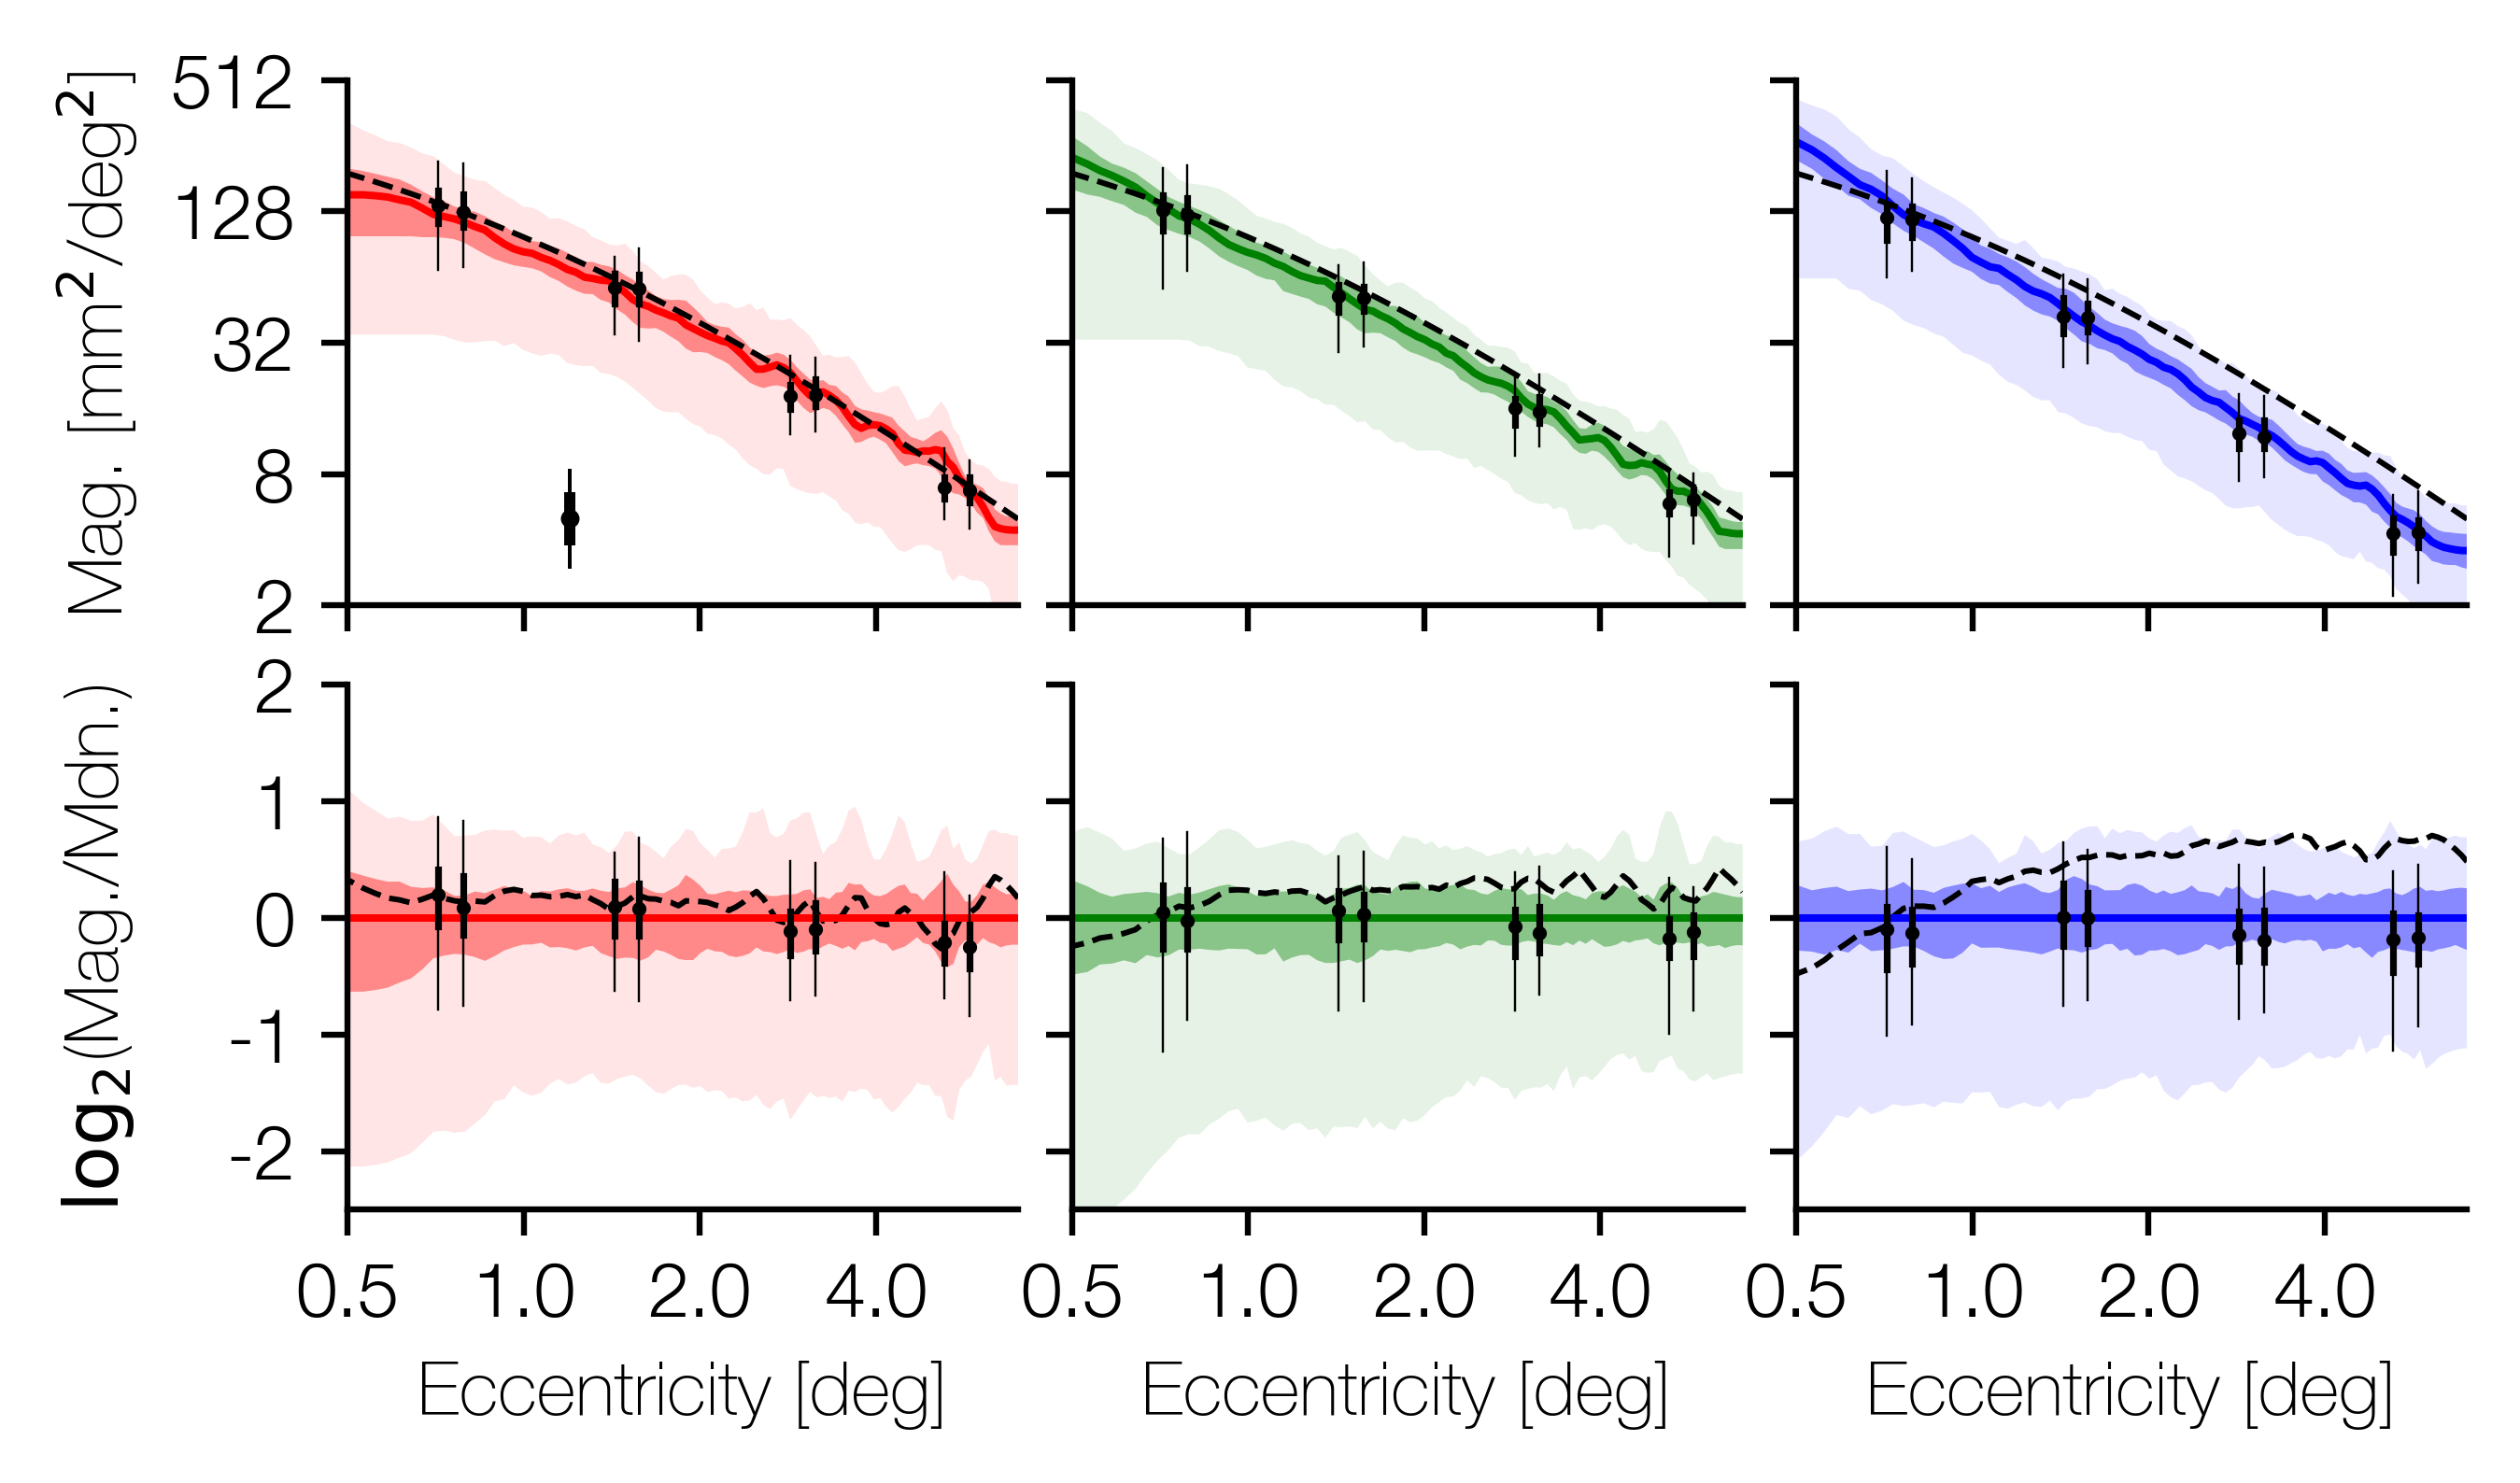

In [146]:
# This is the min and max of the x and y axes.
xlim = (0.5, 7)
ylim0 = (2, 512)
ylim1 = (-2.5, 2)
# This is the DPI we will use.
dpi = 72*8

# We can start by creating the figure.
(fig,axs) = plt.subplots(2,3, figsize=(3.94, 2.10), dpi=dpi,
                         sharex=True)

# We'll want to plot Horton and Hoyt's (1991) equation cortical mag. for
# reference; go ahead and prepare that.
hh_x = eccen_points
hh_y = (17.3/(0.75 + hh_x))**2
# Go ahead and walk through the axes. In the top row of axes we plot the
# magnification itself; on the bottom row, we plot the log-ratio of the
# magnification to its median;
for (rowno,axrow) in enumerate(axs):
    for (ax,lbl,clr) in zip(axrow, [1,2,3], ['r','g','b']):
        # plot the moving averages and shaded regions to represent the
        # inter-quartile ranges.
        xs = vmag_summary[lbl].eccentricity
        qs = vmag_summary[lbl].cmag_quantiles
        md = qs[2]
        # We can plot the H&H now. If this is row2, we need to transform 
        # the data also.
        if rowno == 1:
            qs = np.log2(qs / md)
            ax.plot(hh_x, np.log2(hh_y / md), 'k--', lw=0.75, zorder=1)
        else:
            ax.plot(hh_x, hh_y, 'k--', lw=0.75, zorder=2)
        # Now plot the medians and the quantile-ranges.
        ax.plot(xs, qs[2], clr+'-', lw=1, zorder=1)
        for (ql,qu,alpha) in zip(qs[:2], qs[[4,3]], [0.1,0.4]):
            pxy = np.transpose([np.concatenate([xs, np.flip(xs)]),
                                np.concatenate([ql, np.flip(qu)])])
            pgn = plt.Polygon(pxy, linestyle=None, lw=0, zorder=0,
                              alpha=alpha, fill=True, color=clr)
            pch = ax.add_patch(pgn)
        # Now we plot the ranges and median for the sector cmags; we plot
        # Left and right hemispheres with slight offsets
        for (hk,dx) in zip(['L','R'], [1/1.05, 1.05]):
            for (er,(emn,emx)) in six.iteritems(erings):
                x = 0.5*(emn+emx)*dx # *dx because log-scale
                if   er > 0: k = ['sct%sV%d%s%d' % (hk, lbl, vd, er) for vd in ('v','d')]
                elif l == 1: k = ['sct%sV1%s0' % (hk,vd) for vd in ('v','d')]
                else:        continue # We don';'t plot the foveal sectos.
                vm = [sector_vmag[kk].values for kk in k]
                vm = vm[0][np.isfinite(vm[0])] if len(vm) == 1 else np.nanmean(vm,axis=0)
                qs = np.nanpercentile(1.0/vm, [2.5,25,50,75,97.5])
                lw = 0.3
                if rowno == 1:
                    x0 = 0.5*(emn+emx)
                    qs = np.log2(qs / np.interp(x0, xs, md))
                for ii in range(int(len(qs)/2)):
                    ax.plot([x,x], [qs[ii], qs[-1-ii]], 'k-', lw=lw)
                    lw *= 3
                ax.plot(x, qs[int(len(qs) / 2)], 'ko', ms=lw/3)

# Plot a sample on the V1 plot so that we can add it as a legend.
(x0,y0,dy1,dy2) = (1.2, 5, 0.8, 0.6)
ax = axs[0,0]
ax.loglog([x0,x0], [y0/dy2,y0*dy2], 'k-', lw=0.5)
ax.loglog([x0,x0], [y0/dy1,y0*dy1], 'k-', lw=1.5)
ax.loglog(x0,      y0,              'ko', ms=1.5)
ax.loglog([0.75,0.75],[20,20],'k-',lw=lw)

# We now need to set all of the various axis formatting.
# We'll want to use log-axes, so these are for the ticks:
xfmt = mpl.ticker.FormatStrFormatter('%2.1f')
yfmt = mpl.ticker.FormatStrFormatter('%3d')
xticks = [0.5,1.0,2.0,4.0]
yticks0 = [2,8,32,128,512] # row 0
yticks1 = [-2,-1,0,1,2] # row 1
# Now step through the axes and setup displat properties.
for ax in axs.flatten():
    # Hide the spines.
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Set the limits.
    ax.set_xlim(xlim)
    # Set the log-scale and tick formatting for the x-axis
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(xticks)
# The ticks/labels need to be set separately for rows/cols.
for ax in axs[0]:
    ax.set_yscale('log', basey=2)
    ax.set_ylim(ylim0)
    ax.yaxis.set_major_formatter(yfmt)
    ax.set_yticks(yticks0)
axs[0,0].set_yticklabels(yticks0)
for ax in axs[1]:
    ax.set_xticklabels(xticks)
    ax.set_ylim(ylim1)
    ax.set_yticks(yticks1)
axs[1,0].set_yticklabels(yticks1)
for ax in axs[:,1:].flatten():
    ax.set_yticklabels(['' for x in xticks])
# Set the labels.
for ax in axs[1]:
    ax.set_xlabel('Eccentricity [deg]')
axs[0,0].set_ylabel(r'Mag. [mm$^2$/deg$^2$]', labelpad=4)
axs[1,0].set_ylabel(r'$\log_2$(Mag./Mdn.)', labelpad=12)
#plt.subplots_adjust(0,0,1,1,0.05,0)
fig.subplots_adjust(0,0,1,1, 0.08, 0.15)

# Export theimage if required.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'cmag-by-eccen.pdf')
    fig.savefig(outpath, bbox_inches='tight')

#### Halfway Eccentricity Histograms

Here we use the data (collected above) in the `area_halfeccen` dataframe to plot histograms of the eccentricities at which the 0-7° region of each visual area is split into two equal-area halves, across subjects.

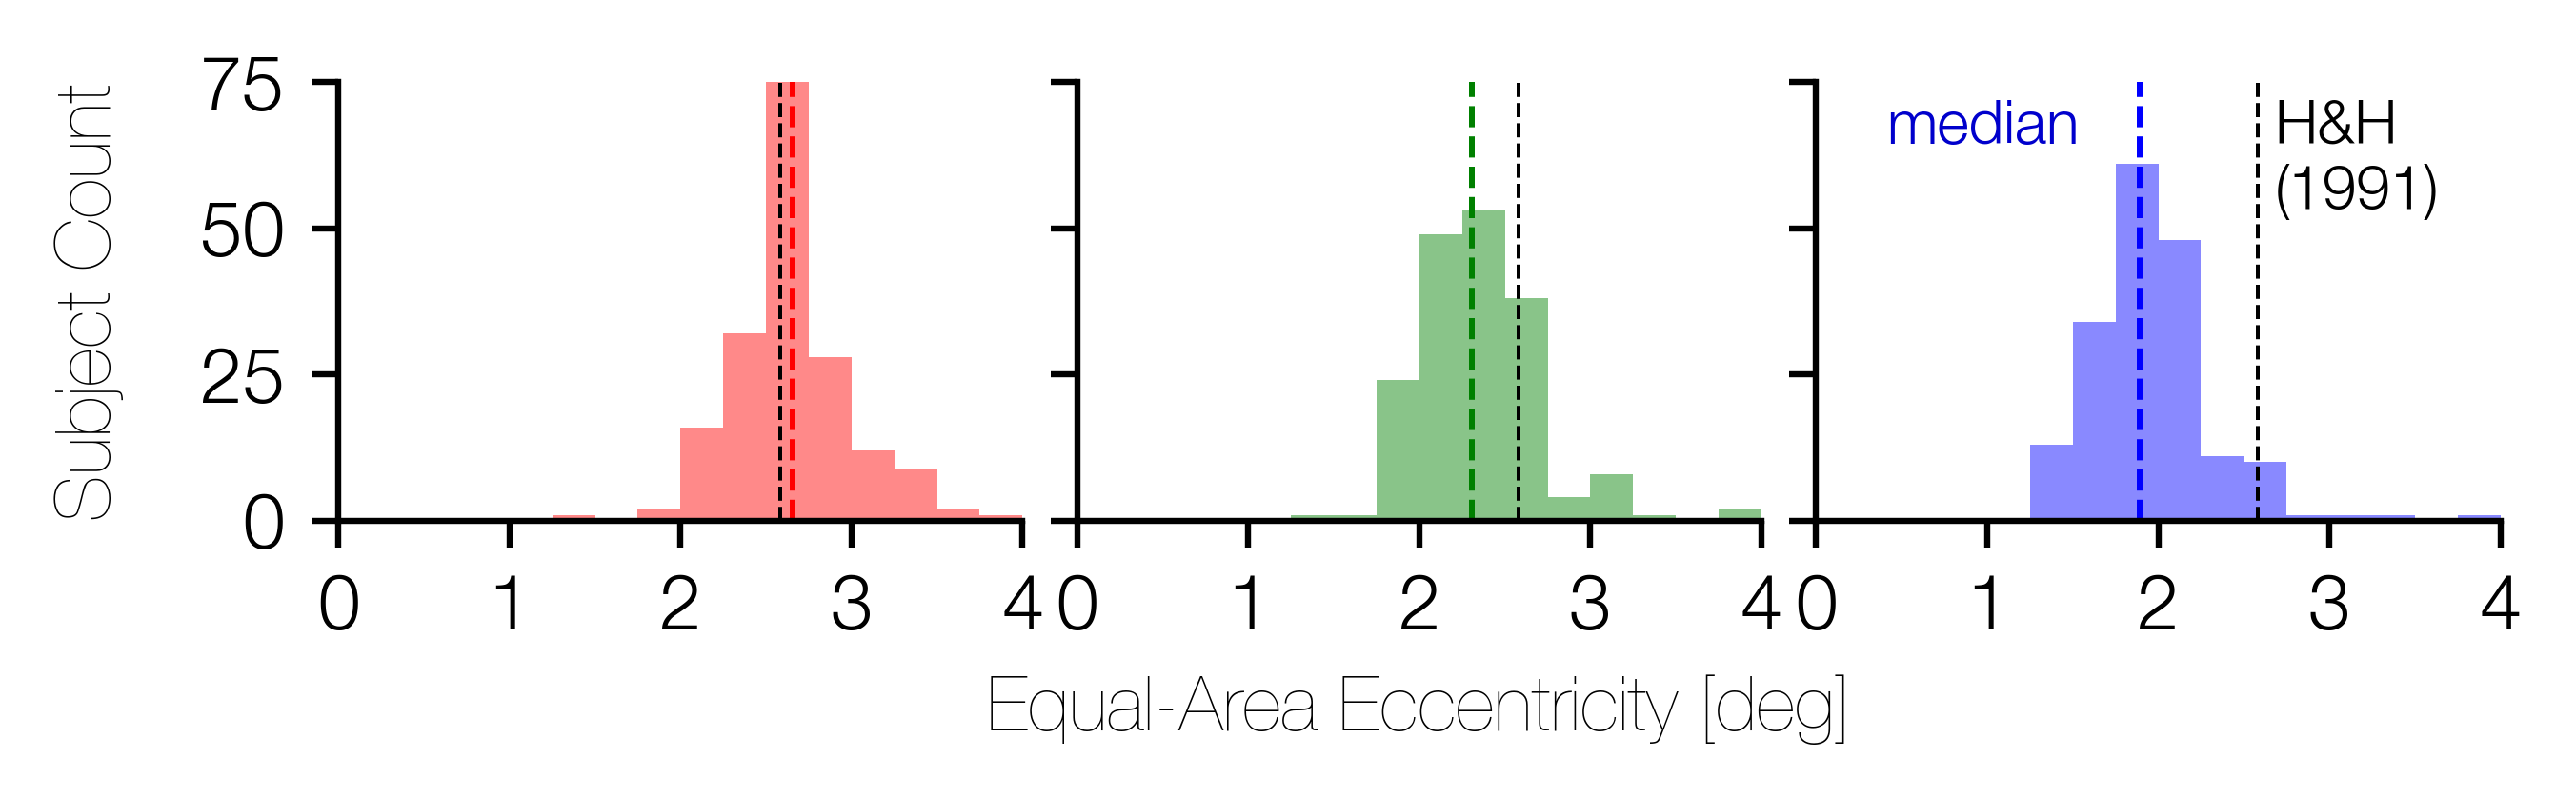

In [63]:
# This is the dots-per-inch we will use.
dpi = 72*8

# We can start by setting up our figure and axes.
(fig,axs) = plt.subplots(1,3, figsize=(3.94, 0.80), dpi=dpi, sharey=True)

# Go ahead and setup axes display properties like labels and spines.
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axs[0].set_ylabel('Subject Count', labelpad=10)
axs[1].set_xlabel('Equal-Area Eccentricity [deg]')
fig.subplots_adjust(0,0,1,1,0.08,0)
# Now walk through each histogram/visual-area and plot it.
for (ax,lbl,clr) in zip(axs, [1,2,3], ['r','g','b']):
    clr = np.array(mpl.colors.to_rgba(clr))
    df = heccs #area_halfeccen
    df = df.loc[df['visual_area'] == lbl]
    hes = df['halfeccen'].values
    # We plot this twice as a lazy way to duplicate the shade in the plot
    # above, which are an alpha 0.4 plus an alpha 0.1.
    ax.hist(hes, np.arange(0,5.01,0.25), color=clr, alpha=0.4)
    ax.hist(hes, np.arange(0,5.01,0.25), color=clr, alpha=0.1)
    # Plot the halfway point according to Horton and Hoyt's equation
    # (this ends up around 2.581).
    ax.plot([2.581, 2.581], [0, 150], 'k--', lw=0.5, label='Horton & Hoyt')
    # Do the same for the median.
    md = np.nanmedian(hes)
    ax.plot([md, md], [0, 150], '--', color=clr, lw=0.75, label='Median')
    # Set the ticks and limits.
    ax.set_xticks([0,1,2,3,4])
    ax.set_yticks([0, 25, 50, 75])
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 75])
# Add a bit of text.
axs[2].text(1.54, 72, 'median', fontsize=8, color=(0,0,0.8),
            verticalalignment='top',
            horizontalalignment='right')
axs[2].text(2.681, 72, 'H&H\n(1991)', fontsize=8, color=(0,0,0),
            verticalalignment='top',
            horizontalalignment='left')

# Export the figure if need-be.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'cmag-halfeccen.pdf')
    plt.savefig(outpath, bbox_inches='tight', dpi=dpi)

Calculation of the correlation between twin-pairs of the half-eccentricity.

In [45]:
mtx = np.zeros([3,3])
for (rr,rel) in enumerate(['MZ','DZ','UR']):
    for (cc,lbl) in enumerate([1,2,3]):
        #rel = 'UR'
        #lbl = 1

        pd = pair_data
        pd = pd.loc[pd['relationship'] == rel]
        (t1s,t2s) = pd[['twin_1','twin_2']].values.T

        df = heccs #area_halfeccen
        df = df.loc[df['visual_area'] == lbl]

        r1s = []
        r2s = []
        for t1t2 in zip(t1s,t2s):
            (r1,r2) = [df.loc[df['sid'] == tt]['halfeccen'].values for tt in t1t2]
            if len(r1) != 1 or len(r2) != 1: continue
            r1s.append(r1[0])
            r2s.append(r2[0])
        r1s = np.asarray(r1s).flatten()
        r2s = np.asarray(r2s).flatten()
        ii = (r1s < 10) & (r2s < 10)
        mtx[rr,cc] = corr(r1s[ii], r2s[ii])
np.array(mtx)

array([[ 0.45790208,  0.40818414,  0.48634267],
       [ 0.04949078, -0.01702683,  0.18981268],
       [-0.00614808, -0.00163037, -0.00792801]])

#### Sector Cortical Magnifications

An obvious way to visualize cortical magnification is in terms of the cortical surface. In our case, we can plot the mean lines across subjects and anatomists and color each sector by the cortical magnification implied by that sector's surface area combined with the portion of the visual field that it represents.

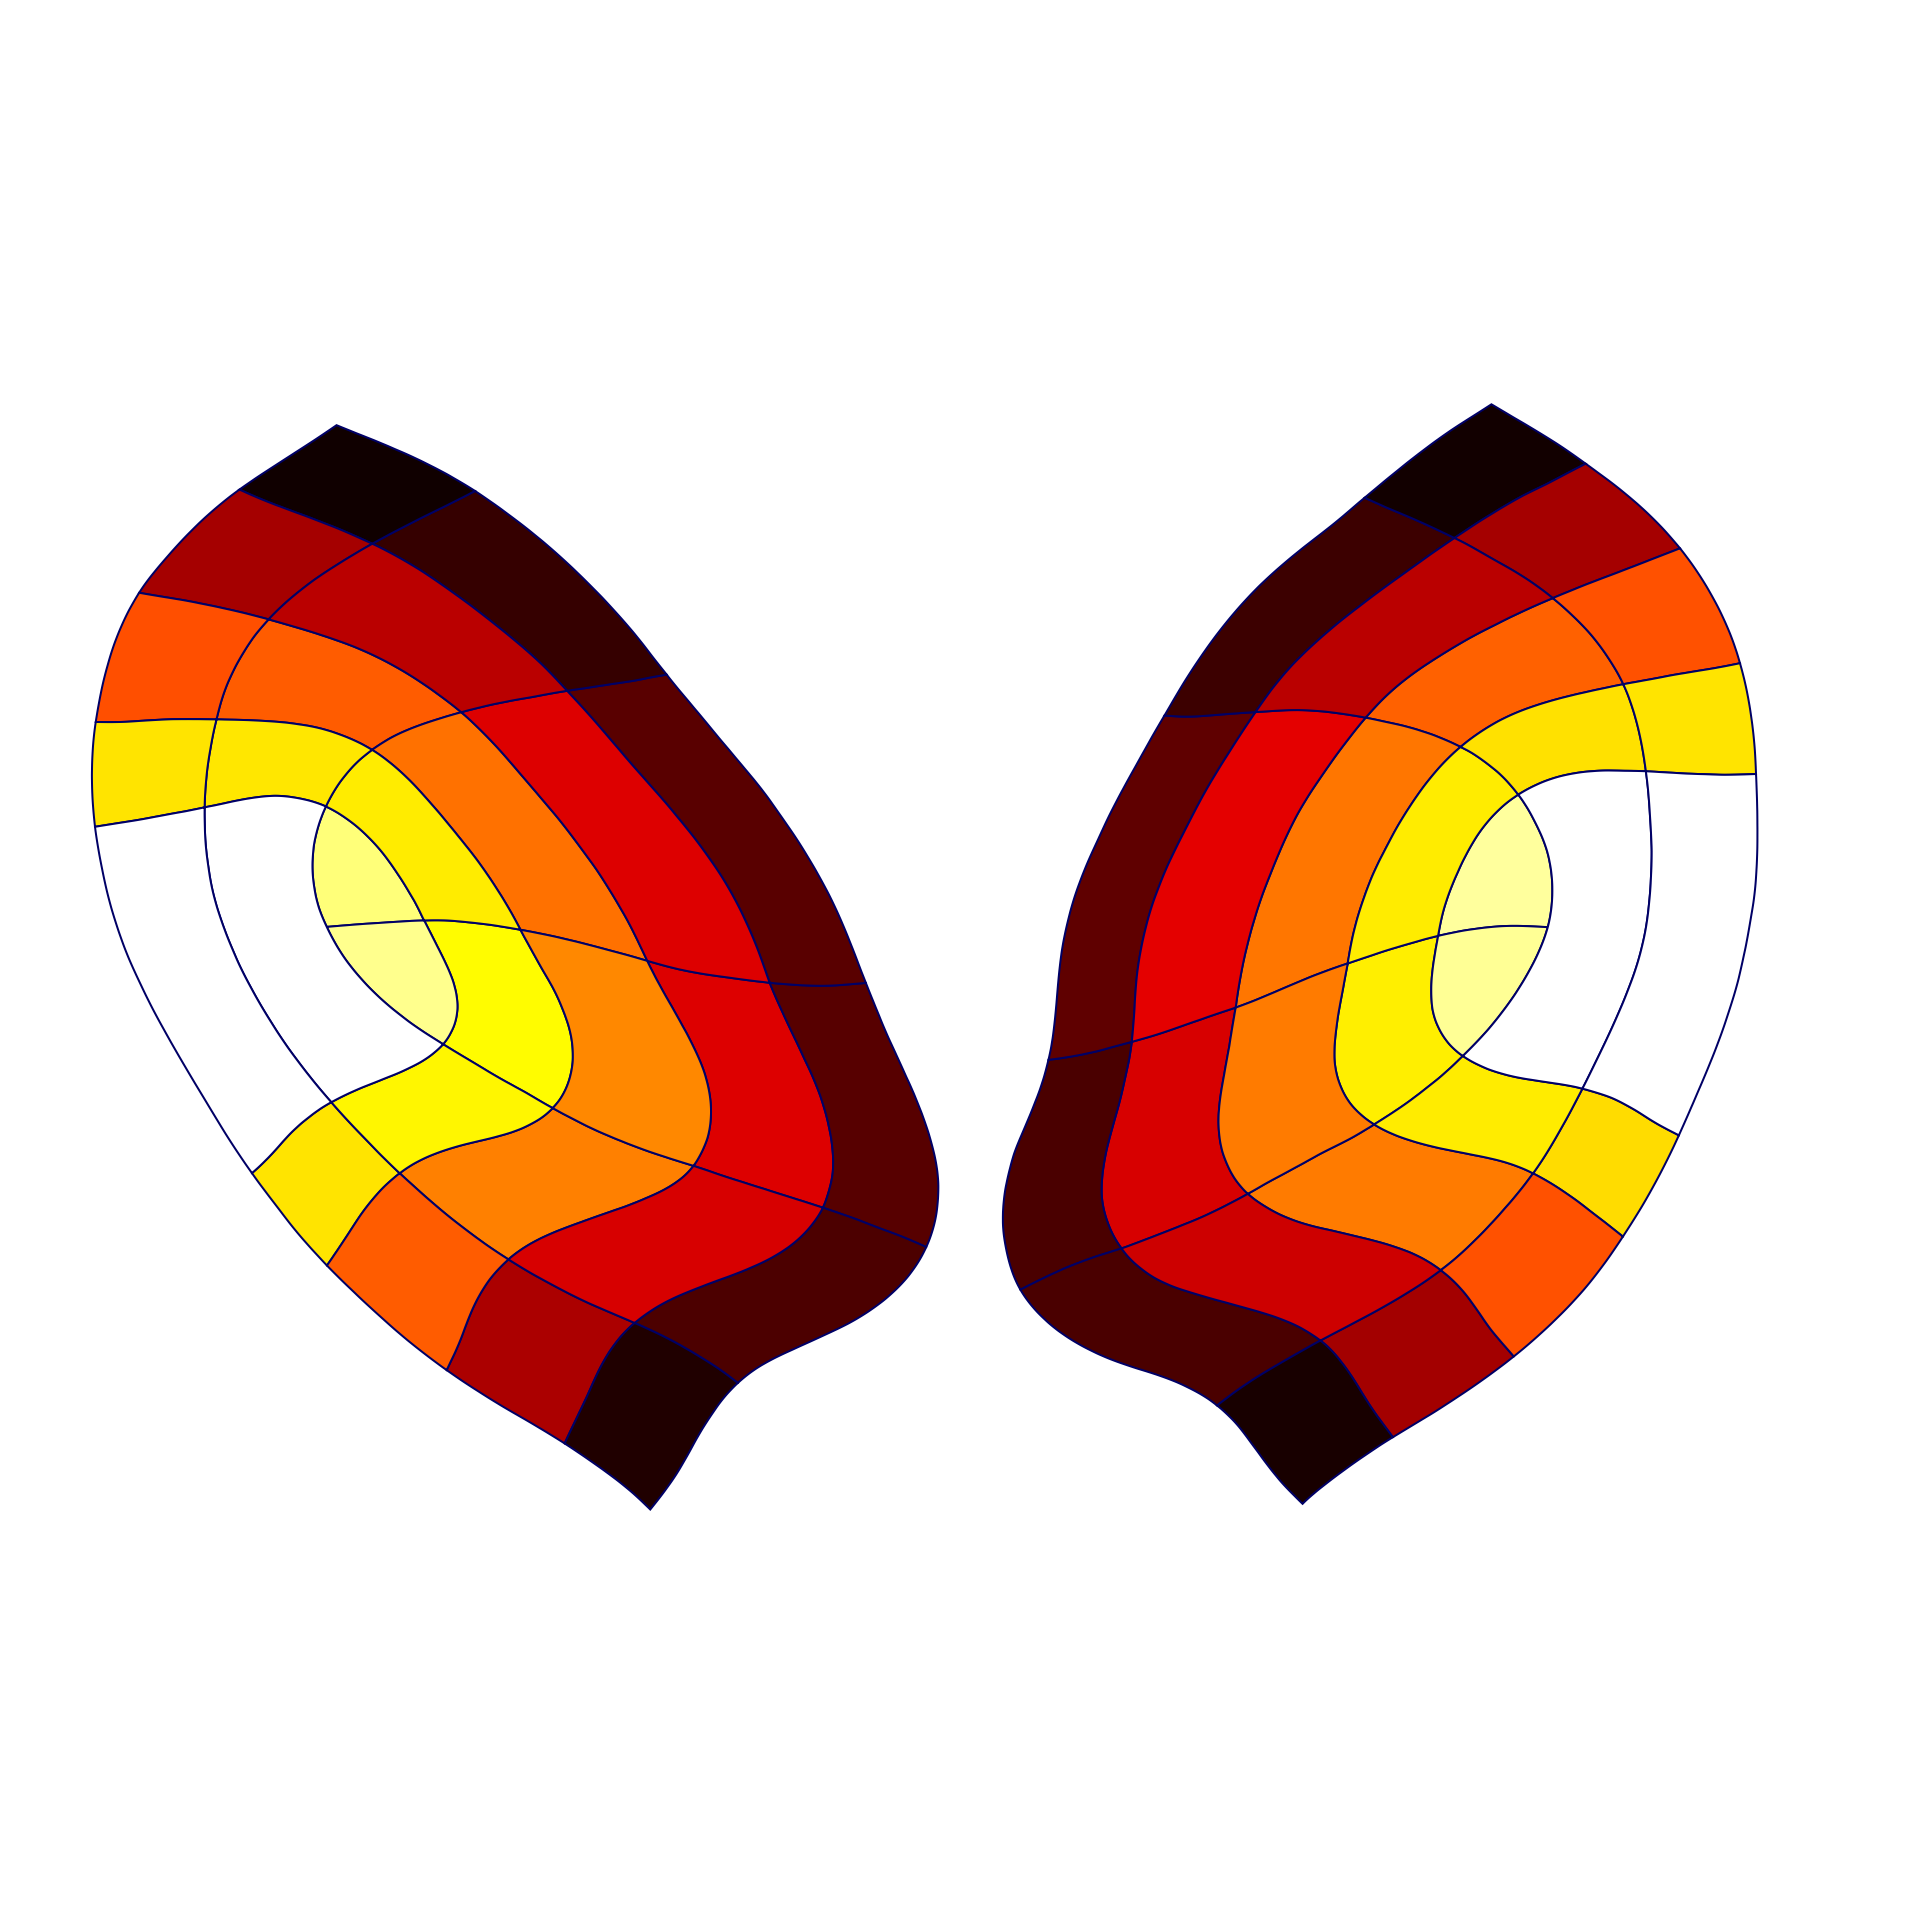

In [102]:
# The colormap we use.
cmap = intensity_cmap
# The DPI to use.
dpi = 8*72
# Go ahead and setup the figures.
(fig,axs) = plt.subplots(1, 2, figsize=(3.125, 3.125), dpi=dpi)
fig.subplots_adjust(0,0,1,1,0,0)
if pimms.is_str(cmap): cmap = mpl.cm.get_cmap(cmap)

# We use a log-transformation to get the color, since cortical
# magnification is exponentially distributed.
def color(cmag): 
    a = (np.log(cmag) - np.log(4.0))
    b = (np.log(512.0) - np.log(4.0))
    return cmap(a / b)
# We now will use the data in the sector_vmag dataframe to 
# grab the median cortical magnification per sector and to plot
# it in the mean-sectors polygons.
df = sector_vmag
for (h,ax) in zip(['lh','rh'], axs):
    # Get the sector traces for this hemisphere.
    strs = mean_sector_traces[h]
    # For V2 and V2 we also need the foveal regions
    addendum = [('V2fov', mean_area_traces[h]['V2fov']),
                ('V3fov', mean_area_traces[h]['V3fov'])]
    for (k,tr) in (list(six.iteritems(strs)) + addendum):
        # We get the median vmag from the dataframe.
        kk = '%s%s%s' % ('roi' if k.endswith('fov') else 'sct', h[0].upper(), k)
        smd = np.nanmedian(df[kk].values)
        cmag = 1.0 / smd
        clr = color(cmag)
        pgon = plt.Polygon(tr.points.T, fill=True, lw=0.25,
                           facecolor=clr, edgecolor=(0,0,0.4))
        ax.add_patch(pgon)
    ax.axis('equal')
    ax.set_ylim([-65,65])
    ax.axis('off')
axs[0].set_xlim([-15,50])
axs[1].set_xlim([-50,15])

# Save the figure if needed.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'cmag_by_sector.pdf')
    plt.savefig(outpath, bbox_inches='tight', dpi=dpi)

### Comparison of Surface Area across Regions

In this section, we plot the surface area data in a variety of ways to examine how it varies across the population generally. We do not consider twin-pairs in this section.

A critical thing to keep in mind in this section is that we don't want to look at foveal data--any ROI that we compare (including V1 ROIs) should exclude the foveal sectors. To facilitate this, we can use the datafrane `sarea_nonfov_data` prepared in the **Initialization** section, above. This dataframe that uses the same columns as `sarea_data` but replaces the typical column `k` with the `k + 'nonfov'` ROI where appropriate; thus it is a dropin replacement for `sarea_data` anywhere you want to analyze the non-foveal ROIs.

#### Scatter Plots

A good way to visualize the relationship between the size of various visual ROIs is to plot them across all subjects on a scatter-plot. This cell does this.

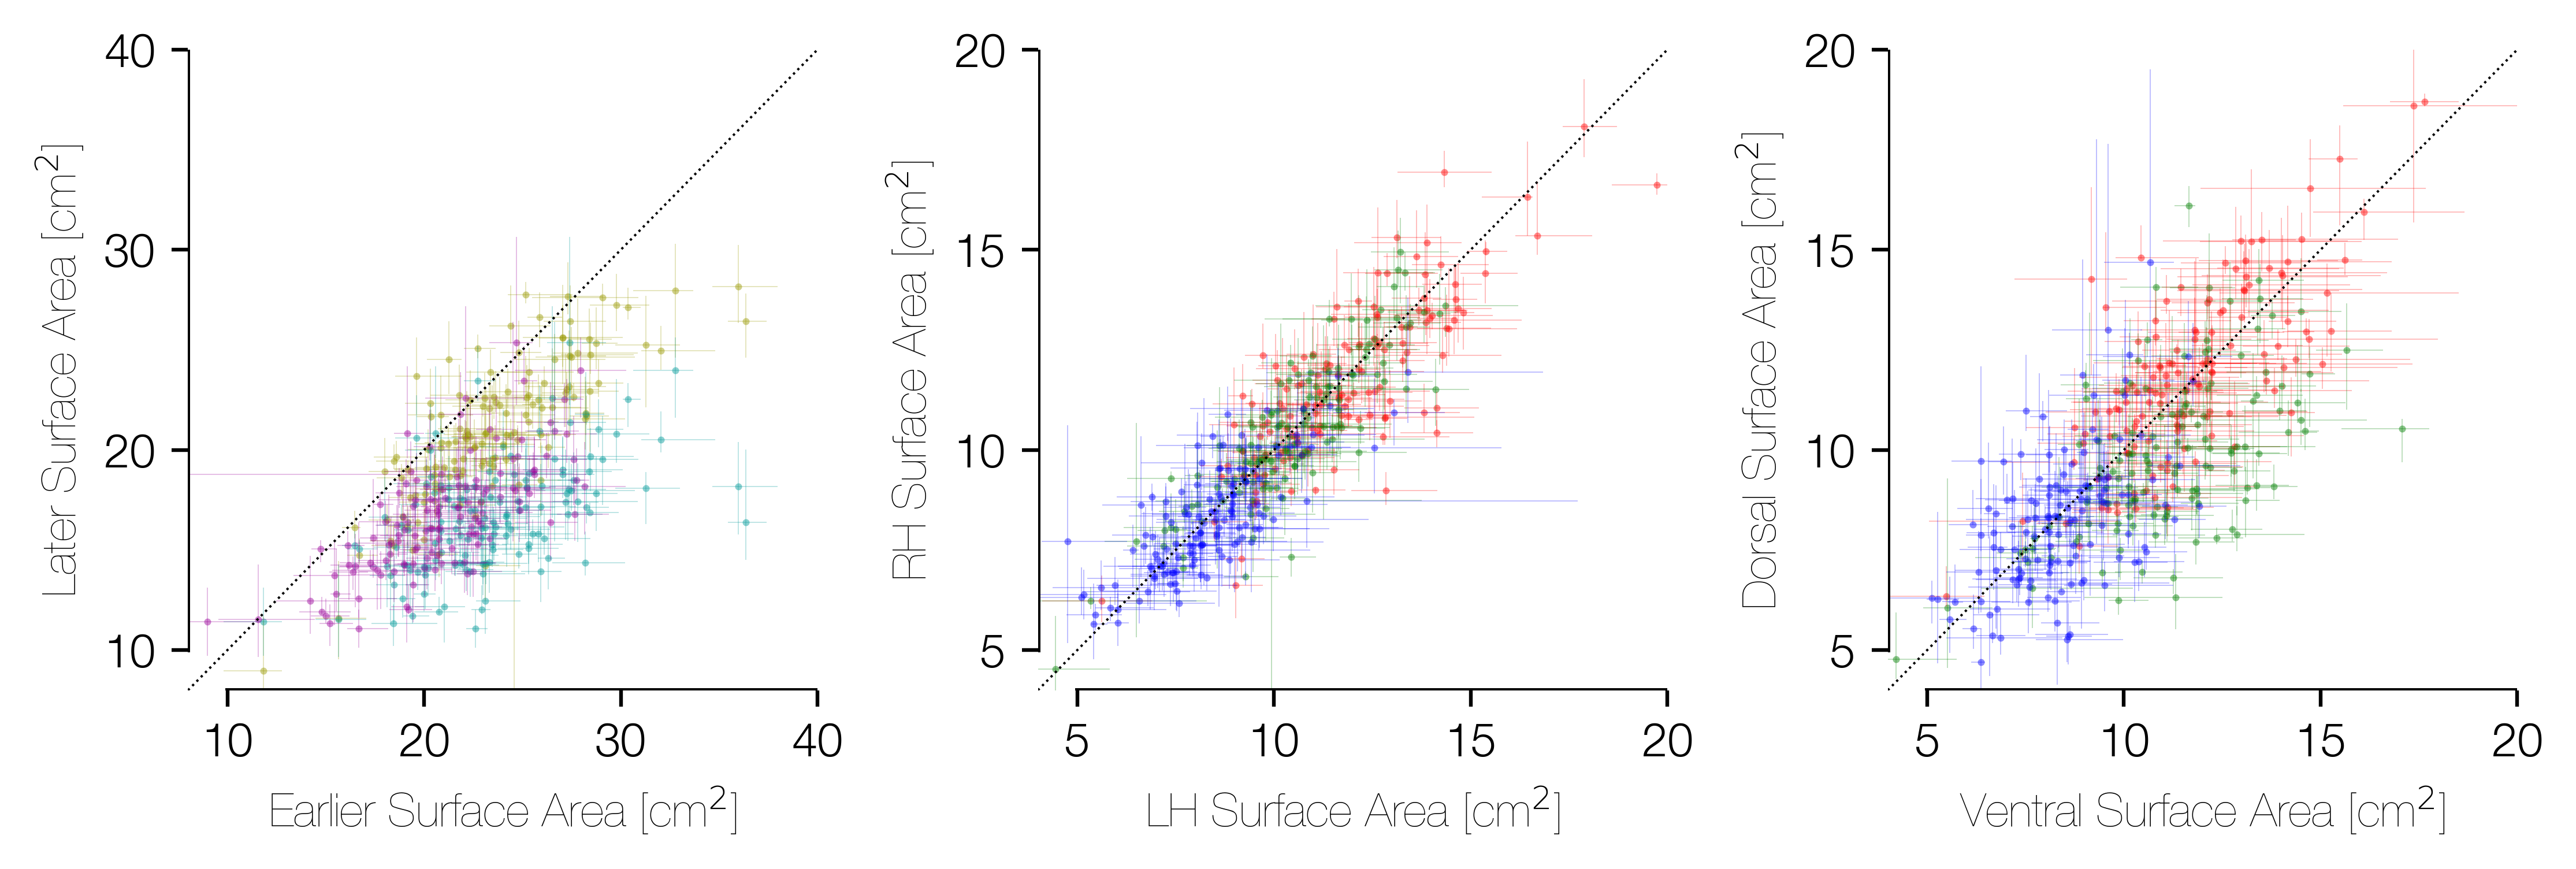

In [41]:
# This is the dataframe we will use.
df0 = sarea_nonfov_data
# These are the plot-limits for the first two plots (the last one
# is just doubled). Since these are square plots, we use the same
# axes and ticks for x and y.
lim = (4, 20)
# These are the ticks for the axes.
ticks = [5,10,15,20]
# This is the figure width in inches and the dots per inch
figwidth = 7
dpi = 72*8
# We'll need this from matplotlib.
from matplotlib.collections import LineCollection
# Convert these to arrays.
lim = np.asarray(lim)
ticks = np.asarray(ticks)

# This function is used to build up the data necessary for making
# the plots below. The idea is that you give it a list of x-columns
# and of y-columns. The list is all the columns from the surface
# area dataframe that should be summed to make the value that goes
# on the appropriate axis. It gives you back an n x 3 matrix whose
# columns represent the (min, mean, max) size of the ROI(s) for
# each subject.
def collect_sizes(names):
    # Separate the dataframe by anatomist.
    dfs = {anat: df0.loc[df0['anatomist'] == anat]
           for anat in data.full_anatomist_list}
    # Each of these can be converted into a list of the relevant
    # surface areas.
    sizes = {anat: np.sum(df[list(names)].values, axis=1)
             for (anat,df) in six.iteritems(dfs)}
    # The mean is special:
    mu = sizes['mean']
    # Otherwise, we operate across the tables
    mtx = np.array(list(sizes.values()))
    mn = np.min(mtx, axis=0)
    mx = np.max(mtx, axis=0)
    return np.array([mn,mu,mx])
# Go ahead and make the figure.
(fig,axs) = plt.subplots(1, 3, figsize=(figwidth, figwidth*0.275), dpi=dpi)
fig.subplots_adjust(0,0,1,1, 0.35, 0)
for (ax,(xnm,ynm)) in zip(axs, [('Earlier','Later'), ('LH','RH'), ('Ventral','Dorsal')]):
    for s in six.itervalues(ax.spines):
        s.set_visible(False)
    (t,l) = (2*ticks,2*lim) if xnm == 'Earlier' else (ticks,lim)
    ax.plot([t[0],t[-1]], [l[0], l[0]], 'k-', lw=1)
    ax.plot([l[0], l[0]], [t[0],t[-1]], 'k-', lw=1)
    ax.set_xticks(t)
    ax.set_yticks(t)
    ax.set_xlim(l)
    ax.set_ylim(l)
    ax.set_xlabel(r'%s Surface Area [cm$^2$]' % xnm)
    ax.set_ylabel(r'%s Surface Area [cm$^2$]' % ynm)
    ax.plot(l, l, 'k:', lw=0.5)

# Now we walk through each axis, which is plotting different
# quantities. We have to build up the data then plot it. We start with
# just the first last axes, which both plot for V1-V3.
sids = np.unique(df0['sid'].values)
for (ax,xk,yk) in zip(axs[1:], [('LV%s',),('LV%sv','RV%sv')], [('RV%s',),('LV%sd','RV%sd')]):
    (xk,yk) = [['roi'+k for k in uk] for uk in (xk,yk)]
    for (va,clr) in zip([1,2,3], ['r','g','b']):
        clr = np.array(mpl.colors.to_rgba(clr))
        clr[-1] = 0.46
        xvals = collect_sizes([k%va for k in xk])
        yvals = collect_sizes([k%va for k in yk])
        # Exclude any points with nans.
        ii = (np.all(np.isfinite(xvals), axis=0) &
              np.all(np.isfinite(yvals), axis=0))
        # Also multiply by 0.01 to convert to cm^2
        (xvals,yvals) = [u[:,ii]*0.01 for u in (xvals,yvals)]
        # Build up segments that we can put in a line collection.
        (xmn,xmu,xmx) = xvals
        (ymn,ymu,ymx) = yvals
        #print('---')
        #print(xk[0] % va, ': ', np.nanmedian(xmu))
        #print(yk[0] % va, ': ', np.nanmedian(ymu))
        xsegs = np.transpose([(xmn,ymu), (xmx,ymu)], (2,0,1))
        ysegs = np.transpose([(xmu,ymn), (xmu,ymx)], (2,0,1))
        segs = np.concatenate([xsegs,ysegs], axis=0)
        # Go ahead and plot these points and ranges.
        ax.scatter(xmu, ymu, c=[clr], s=0.25)
        clr = np.array(clr)
        clr[-1] = 0.25
        lc = LineCollection(segs, lw=0.25, colors=clr)
        ax.add_collection(lc)
# The first plot we do separately because it involves multiple visual
# areas per color.
ax = axs[0]
for (a1,a2,c) in zip([1,1,2],[2,3,3],['y','c','m']):
    clr = np.array(mpl.colors.to_rgba(c))
    clr[:-1] *= 0.8
    clr[-1] = 0.46
    xvals = collect_sizes(['roiLV%d'%a1, 'roiRV%d'%a1])
    yvals = collect_sizes(['roiLV%d'%a2, 'roiRV%d'%a2])
    # Exclude any points with nans.
    ii = (np.all(np.isfinite(xvals), axis=0) &
          np.all(np.isfinite(yvals), axis=0))
    # Also multiply by 0.01 to convert to cm^2
    (xvals,yvals) = [u[:,ii]*0.01 for u in (xvals,yvals)]
    # Build up segments that we can put in a line collection.
    (xmn,xmu,xmx) = xvals
    (ymn,ymu,ymx) = yvals
    xsegs = np.transpose([(xmn,ymu), (xmx,ymu)], (2,0,1))
    ysegs = np.transpose([(xmu,ymn), (xmu,ymx)], (2,0,1))
    segs = np.concatenate([xsegs,ysegs], axis=0)
    # Go ahead and plot these points and ranges.
    ax.scatter(xmu, ymu, c=[clr], s=0.25)
    clr = np.array(clr)
    clr[-1] = 0.25
    lc = LineCollection(segs, lw=0.25, colors=clr)
    ax.add_collection(lc)

# Save the figure if need be.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'roi_scatterplots.pdf')
    plt.savefig(outpath, bbox_inches='tight', dpi=dpi)

#### Correlation Matrices

Across subjects, we would like to know what ROIs correlate with others. To examine this, we prepare and plot three correlation matrices:
1. the correlation of V1, V2, and V3 (LH + RH combined) with each other;
2. the correlation of LH and RH V1, V2, and V3 separately; and
3. the correlation of ventral and dorsal sections of V1-V3 with each other.

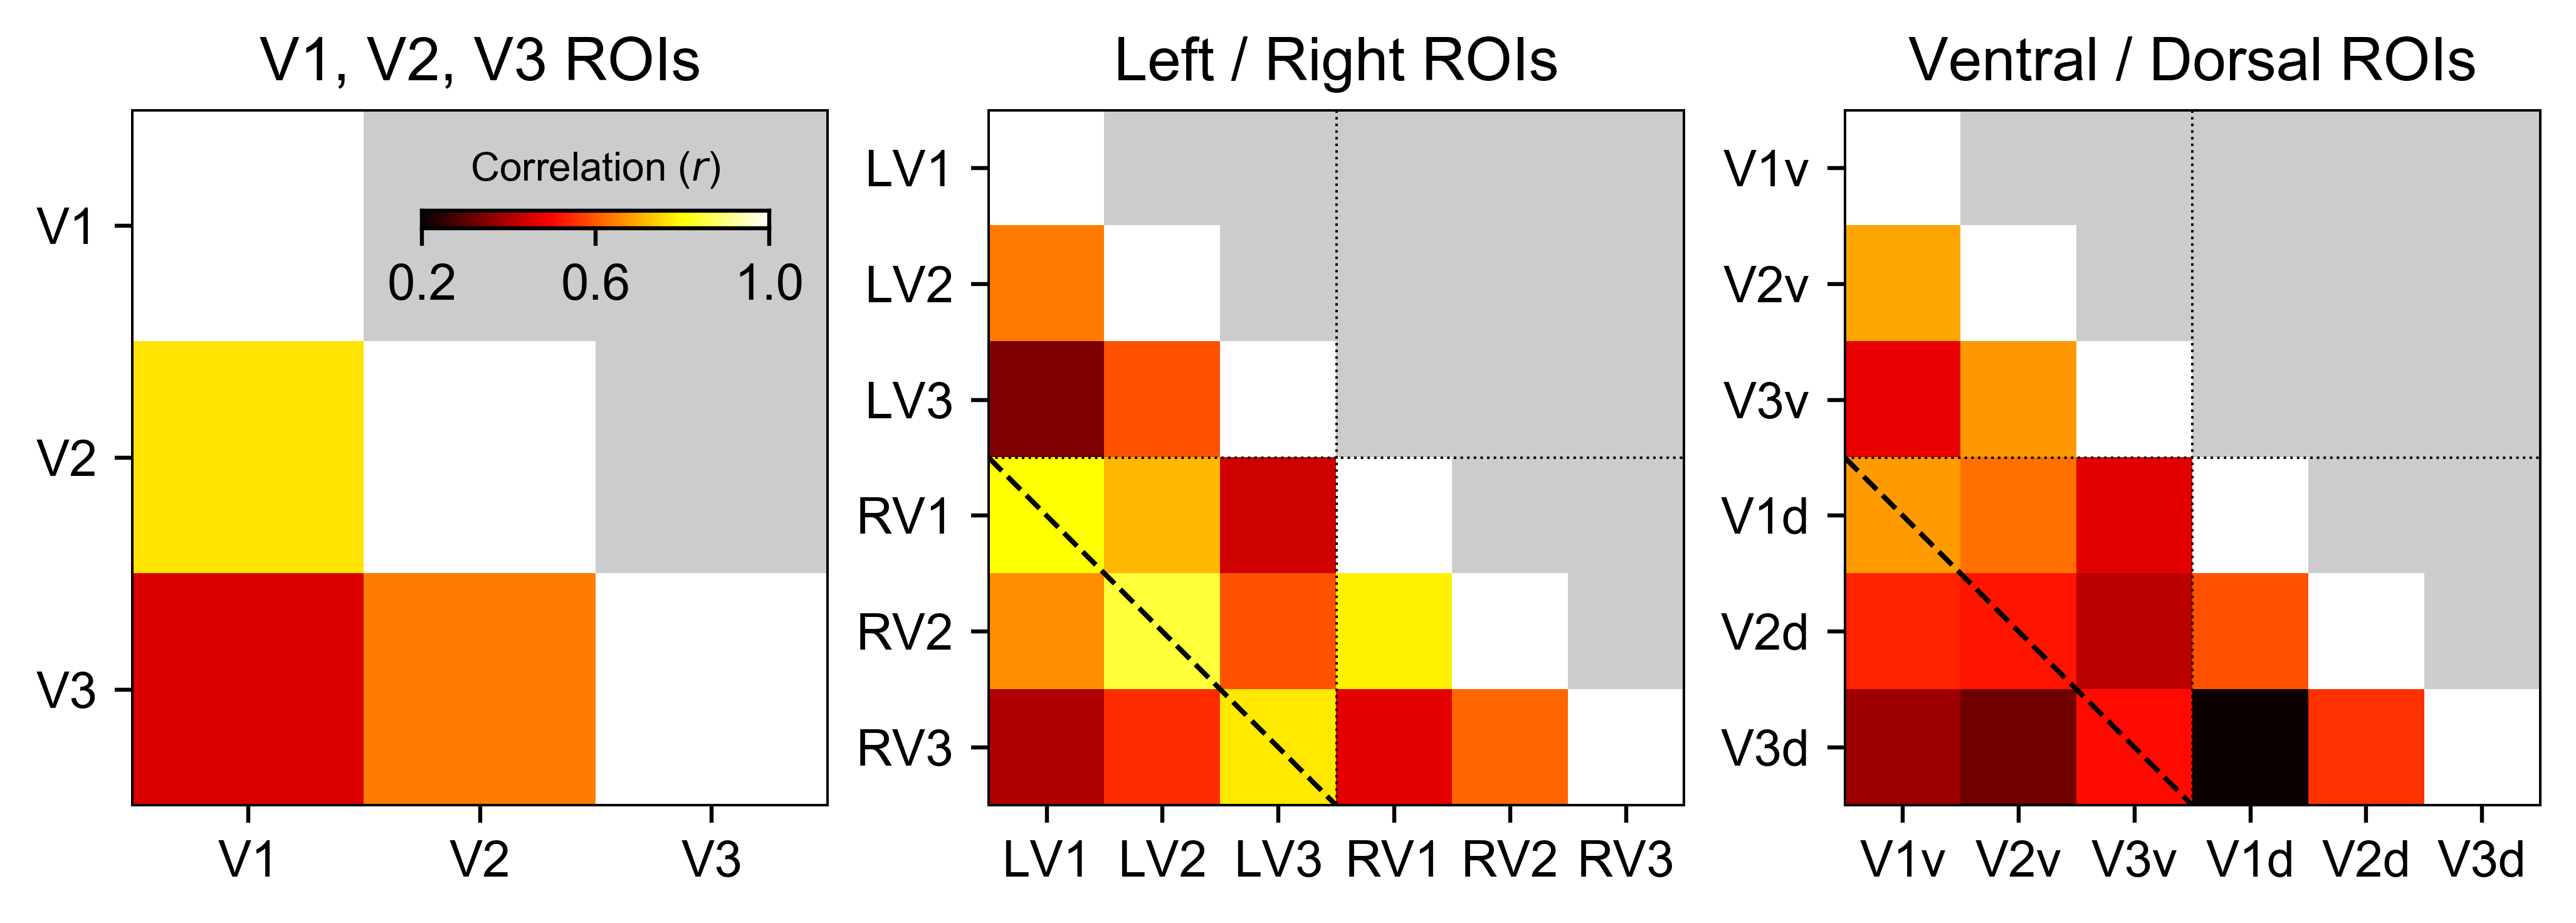

In [37]:
# This is the dataframe we will use.
df0 = sarea_nonfov_data
df0 = df0.loc[df0['anatomist'] == 'mean']
# This is the colormap we will use.
cmap = 'hot'
vmin = 0.2
vmax = 1.0
# This is the figure width in inches and the dots per inch
figwidth = 7
dpi = 72*8

# We use a special image coloring function in order to be able to both
# apply a colormap and to turn all the upper-right pixels gray.
def corr_image_color(im):
    im = np.asarray(im)
    cm = mpl.cm.get_cmap(cmap)
    clr = cm((im - vmin) / (vmax - vmin))
    (rr,cc) = np.meshgrid(np.linspace(0,1,im.shape[0]),
                          np.linspace(0,1,im.shape[1]))
    ii = np.where(rr > cc)
    clr[ii] = (0.8,0.8,0.8,1)
    return clr

# Go ahead and make the figure.
(fig,axs) = plt.subplots(1, 3, figsize=(figwidth, figwidth*0.275), dpi=dpi)
fig.subplots_adjust(0,0,1,1, 0.05, 0)
for ax in axs:
    for s in six.itervalues(ax.spines):
        s.set_linewidth(0.5)

# We can go ahead and create the correlation matrices we're going to plot
# now. on the first axes, we plot the correlation matrix for LH+RH V1, V2,
# and V3.
lbls0 = ['V1','V2','V3']
df = {k: df0['roiL%s'%k] + df0['roiR%s'%k] for k in lbls0}
df = ny.to_dataframe(df)[lbls0]
corr0 = df.corr().values
# On the second axes, we do left versus right V1-V3.
lbls1 = ['LV1','LV2','LV3','RV1','RV2','RV3']
df = df0[['roi%s'%k for k in lbls1]]
corr1 = df.corr().values
# On the third axes, we do vental versus dorsal V1-V3.
lbls2 = ['V1v','V2v','V3v','V1d','V2d','V3d']
df = {k: df0['roiL%s'%k] + df0['roiR%s'%k] for k in lbls2}
df = ny.to_dataframe(df)[lbls2]
corr2 = df.corr().values
# Now iterate through and plot each of these on their respective axes.
for (ax,lbls,corr) in zip(axs,[lbls0,lbls1,lbls2],[corr0,corr1,corr2]):
    n = len(lbls)
    ii = np.arange(n)
    im = corr_image_color(corr)
    ax.imshow(im, zorder=1)
    ax.set_xticks(ii)
    ax.set_yticks(ii)
    ax.set_xticklabels(lbls)
    ax.set_yticklabels(lbls)
    ax.set_xlim([-0.5, n - 0.5])
    ax.set_ylim([-0.5, n - 0.5])
    ax.invert_yaxis()
axs[0].set_title('V1, V2, V3 ROIs')
axs[1].set_title('Left / Right ROIs')
axs[2].set_title('Ventral / Dorsal ROIs')
# Plot some division lines for the last two axes.
for ax in axs[1:]:
    ax.plot([2.5,2.5], [-0.5,5.5], 'k:', lw=0.5)
    ax.plot([-0.5,5.5], [2.5,2.5], 'k:', lw=0.5)
    ax.plot([-0.5,2.5], [2.5,5.5], 'k--', lw=1)
# Add a legend in the first axis.
ax = fig.add_axes([0.082, 0.83, 0.25, 0.025])
ax.imshow([np.linspace(vmin,vmax,200)]*5,
          cmap=cmap, vmin=vmin, vmax=vmax,
          extent=(vmin,vmax,0,(vmin-vmax)/20))
ax.set_xticks([0.2,0.6,1.0])
ax.yaxis.set_visible(False)
ax.set_title(r'Correlation ($r$)', fontsize=8)

# Save the figure if need-be.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'roi_corr.pdf')
    plt.savefig(outpath, bbox_inches='tight', dpi=dpi)

---

**Are ventral regions more similar than dorsal regions?**

In the paper, we claim that the ventral V1-V2, V2-V3, V1-V3 correlations are higher than than dorsal V1-V2, V2-V3, V1-V3 correlations. To ensure that this claim meets a statistical threshold for relevance, we can use bootstraps to compute a confidence interval around these correlations. We use the bilateral surface areas to test whether the V1-V2 ventral correlation is greater than the V1-V2 dorsal correlation, and the same for V1-V3 and V2-V3. If all three are statistically greater, thin this is fairly strong evidence.

V1-V2:  0.65  0.69  0.74 |  0.54  0.59  0.64
V2-V3:  0.63  0.67  0.72 |  0.50  0.55  0.61
V1-V3:  0.40  0.47  0.54 |  0.12  0.19  0.26


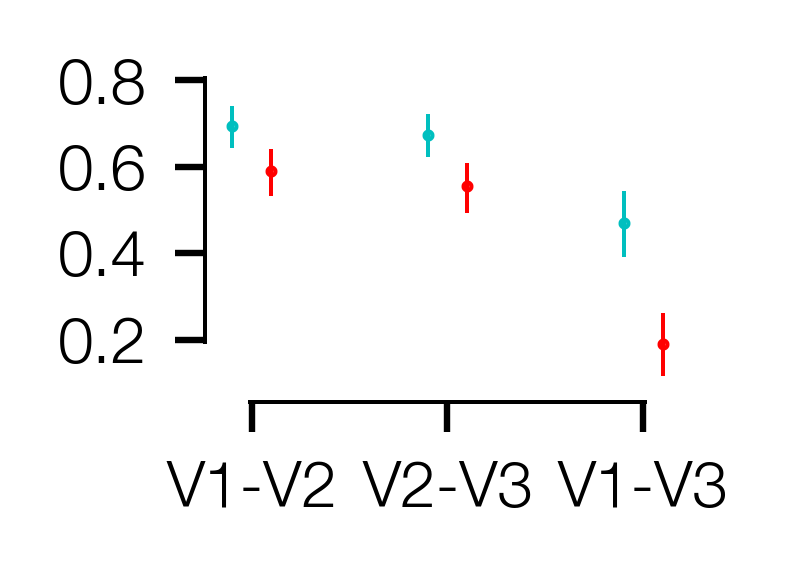

In [334]:
# We want to use the nonfoveal dataframe.
df = sarea_nonfov_data
df = df.loc[df['anatomist'] == 'mean']
# And this many bootstraps.
bootstraps = 10000

# We are looking at these correlations:
vntcols = [('roiXV1v','roiXV2v'), ('roiXV2v','roiXV3v'), ('roiXV1v','roiXV3v') ]
drscols = [('roiXV1d','roiXV2d'), ('roiXV2d','roiXV3d'), ('roiXV1d','roiXV3d')]
(vntcors,drscors) = [
    [corr(df[k1.replace('X','L')].values + df[k1.replace('X','R')].values,
          df[k2.replace('X','L')].values + df[k2.replace('X','R')].values,
          bootstraps=bootstraps, confidence=68)
     for (k1,k2) in cols]
    for cols in (vntcols, drscols)]

# Make a simple little plot.
(fig,ax) = plt.subplots(1,1, figsize=(0.85,0.6), dpi=72*8)
fig.subplots_adjust(0,0,1,1,0,0)
for v in ax.spines.values(): v.set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlim([-0.25, 2.25])
ax.set_ylim([0.05, 0.85])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['V1-V2','V2-V3','V1-V3'])
ax.set_yticks([0.2,0.4,0.6,0.8])
ax.set_yticklabels([0.2,0.4,0.6,0.8])
ax.plot([0, 2], [0.05, 0.05], 'k-', lw=1)
ax.plot([-0.25, -0.25], [0.2, 0.8], 'k-', lw=1)
dx = 0.1
for (x,vntys,drsys) in zip([0,1,2], vntcors, drscors):
    print('%4s: %5.2f %5.2f %5.2f | %5.2f %5.2f %5.2f' % (
        (['V1-V2', 'V2-V3', 'V1-V3'][x],) + vntys + drsys))
    ax.plot([x-dx,x-dx], [vntys[0],vntys[2]], 'c-', lw=0.5)
    ax.plot([x+dx,x+dx], [drsys[0],drsys[2]], 'r-', lw=0.5)
    ax.plot(x-dx, vntys[1], 'co', ms=0.5)
    ax.plot(x+dx, drsys[1], 'ro', ms=0.5)

# Save the figure if need-be.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'vnt-drs-correlations.pdf')
    plt.savefig(outpath, bbox_inches='tight', dpi=dpi)

### Plots and Analysis of the Surface Area Data across Twins

#### Prepare Data

---

**`pair_data`**

To begin our analysis of the twins, we will build up a dataframe of the all the subject pairs. The dataframe will detail the relaitship type (MZ: monozygotic twins, DZ: dizygotic twins, or UR: unrelated), their genders, their subject IDs, and their surface areas.

In [39]:
# Grab the various kinds of pairs.
mzs = data.retinotopy_sibling_pairs['monozygotic_twins']
dzs = data.retinotopy_sibling_pairs['dizygotic_twins']
urs = data.retinotopy_sibling_pairs['unrelated_pairs']
# Make a dataframe out of these.
pair_data = ny.auto_dict(None, [])
for (tt,pairs) in zip(['MZ','DZ','UR'], [mzs,dzs,urs]):
    for (u,v) in pairs:
        pair_data['relationship'].append(tt)
        pair_data['twin_1'].append(int(u))
        pair_data['twin_2'].append(int(v))
        pair_data['gender_1'].append(data.gender[u])
        pair_data['gender_2'].append(data.gender[v])
for k in ['twin_1', 'twin_2']:
    pair_data[k] = np.asarray(pair_data[k], dtype=np.int)
pair_data = ny.to_dataframe(pair_data)
pair_data['same_gender'] = pair_data['gender_1'] == pair_data['gender_2']

# We're going to build up two separate dataframes here: pair_data and
# pair_percent, using the surface area and sarea_percent dataframes. We
# Also make sure to use the non-foveal versions. We then merge them all
# into one dataframe with properties like 'roiLV1_1' referring to the
# PERCENT surface area number and 'mm2_roiLV11' referring to the raw
# surface area number.
# Start with the percent data-table.
df0 = sarea_nonfov_percent
# We only use the mean anatomist.
df0 = df0.loc[df0['anatomist'] == 'mean']
df0 = df0.drop(columns='anatomist')
# Merge in the mm2 data
mm2df = sarea_nonfov_data
mm2df = mm2df.loc[mm2df['anatomist'] == 'mean']
mm2df = mm2df.drop(columns='anatomist')
tr = {k:'mm2_'+k for k in mm2df.columns
      if k[:3] in ['roi','sct','lbl']}
mm2df = mm2df.rename(columns=tr)
df0 = df0.merge(mm2df, on='sid', how='inner')
# Make dataframes for merging with the pair data.
df1 = df0.rename(columns=lambda k:k+'_1')
df2 = df0.rename(columns=lambda k:k+'_2')
# And perform the merge.
pair_data = pair_data.merge(df1, left_on='twin_1', right_on='sid_1', how='inner')
pair_data = pair_data.merge(df2, left_on='twin_2', right_on='sid_2', how='inner')
pair_data = pair_data.drop(columns=['sid_1', 'sid_2'])
pair_data = pair_data.sort_values(by=['relationship','twin_1','twin_2'])
# The last thing we want to do is add an X column for every L/R pair oc
# columns; ths just holds the sum of the L and R columns.
for col in pair_data.columns:
    if col[:3] in ['roi','sct','lbl']:
        (p,h,s) = (col[:3],col[3],col[4:])
    elif col[:3] == 'mm2':
        (p,h,s) = (col[:7],col[7],col[8:])
    else: continue
    if h == 'R': continue
    # Sum for mm2, average for percentages
    if col.startswith('mm2'):
        pair_data[p + 'X' + s] = pair_data[p+'L'+s] + pair_data[p+'R'+s]
    else:
        pair_data[p + 'X' + s] = (pair_data[p+'L'+s] + pair_data[p+'R'+s])*0.5

---

**`mz_corr`**, **`dz_corr`**, and **`ur_corr`**

Give the `pair_data` table generated above, we can calculate the correlations (ICCs) between ROIs across various twin types. We build that dataframe up in this cell. The columns and rows of these matrices are named by the variable `corr_keys`.

Note that if you are using the `sarea_percent` data (as opposed to the `sarea_data`) in the above cell, then this will generate a warning about an invalid value. This is due to the fact that, in the percentage data, the `'lblLH'` and `'lblRH'` have exactly 100 in every row, so their variance is 0 and their correlation is undefined.

In [40]:
# To prepare, go ahead and get a list of column names for all ROIs
# in the pair_data dataframe.
cols = [k[:-2] for k in pair_data.columns
        if k.endswith('_1') and k[:3] in ('lbl','roi','sct')]
corr_columns = cols = np.array(sorted(cols))
# We'll need every pair of columns.
col_pairs = np.array([(k1+'_1',k2+'_2') for k1 in cols for k2 in cols])
# We'll also want to sort the columns into this order below.
col_sort = dict(zip(cols, range(len(cols))))
# We will build up the table in hdata for now.
hdata = ny.auto_dict(None, [])
for tt in ['MZ', 'DZ', 'UR']:
    # Select the relevant data from the pair_data.
    df = pair_data
    df = df.loc[df['relationship'] == tt]
    df = df.loc[df['same_gender']]
    # Walk through all pairs of columns:
    for (k1,k2) in col_pairs:
        hdata['relationship'].append(tt)
        hdata['locus_1'].append(k1[:-2])
        hdata['locus_2'].append(k2[:-2])
        u1 = df[k1].values
        u2 = df[k2].values
        hdata['correlation'].append(icc(u1, u2))
pair_corr_data = ny.to_dataframe(hdata)
# Now turn that dataframe into a correlation matrix
hcorr = {'MZ':[], 'DZ':[], 'UR':[]}
for (tt,r) in six.iteritems(hcorr):
    df0 = pair_corr_data
    df0 = df0.loc[df0['relationship'] == tt]
    for (ir,k1) in enumerate(cols):
        # Select just the subset with column 1 equal to k1.
        df = df0.loc[df0['locus_1'] == k1]
        # Sort the rows by column 2.
        ii = np.argsort([col_sort[k] for k in df['locus_2']])
        # Now make the row of the correlation matrix.
        r.append(df['correlation'].values[ii])
pair_corrs = {k:np.array(v) for (k,v) in six.iteritems(hcorr)}
mz_corr = pair_corrs['MZ']
dz_corr = pair_corrs['DZ']
ur_corr = pair_corrs['UR']
corr_keys = corr_columns

---

**`heritability_data`**

Additionally, we will build up a set of heritability estimates. This can take awhile as the heritability is calculated using bootstraps.

In [91]:
# This is the number of bootstraps we use for each calculation.
bootstraps = 10000
# We do this using the pair data; restrict to same-gender pairs.
df = pair_data
df = df.loc[df['same_gender']]
dfmz = df.loc[df['relationship'] == 'MZ']
dfdz = df.loc[df['relationship'] == 'DZ']
# We want to calculate this for each column, so walk through them.
hdata = ny.auto_dict(None, [])
run_all_q = False
for col in df.columns:
    if col[:3] not in ['roi','scr','lbl','mm2']: continue
    if col.endswith('_2'):
        if run_all_q: continue
        # This is a cheap way to run all the data in one iteration of 
        # the loop without having to add an extra column or anything.
        run_all_q = True
        col = 'roiXAll_1'
    (c1,c2) = (col, col[:-1] + '2')
    if c1 == 'roiXAll_1':
        mzx = np.sum([dfmz[['roiXV%d_1'%l,'roiXV%d_2'%l]].values
                      for l in [1,2,3]], axis=0).T
        dzx = np.sum([dfdz[['roiXV%d_1'%l,'roiXV%d_2'%l]].values
                      for l in [1,2,3]], axis=0).T
    else:
        dzx = dfdz[[c1,c2]].values.T
        mzx = dfmz[[c1,c2]].values.T
    (lb,h2,ub) = heritability(mzx, dzx, bootstraps=bootstraps)
    hdata['region'].append(col[:-2])
    hdata['h2'].append(h2)
    hdata['h2_ci95lb'].append(lb)
    hdata['h2_ci95ub'].append(ub)
    (lb,h2,ub) = heritability(mzx, dzx, bootstraps=bootstraps, confidence=68)
    hdata['h2_ci68lb'].append(lb)
    hdata['h2_ci68ub'].append(ub)
    # Also estimate rDZ and rMZ
    for (tt,(x,y)) in zip(['MZ','DZ'], [mzx,dzx]):
        tag = 'r'+tt
        (lb,r,ub) = icc(x, y, bootstraps=bootstraps)
        hdata[tag].append(r)
        hdata[tag+'_ci95lb'].append(lb)
        hdata[tag+'_ci95ub'].append(ub)
        (lb,r,ub) = icc(x, y, bootstraps=bootstraps, confidence=68)
        hdata[tag+'_ci68lb'].append(lb)
        hdata[tag+'_ci68ub'].append(ub)
heritability_data = ny.to_dataframe(hdata)

#### Scatter Plots of Twin Data

We want to look at scatter-plots of the surface areas of various brain regions between twins by twin-type and to compare their correlations and heritabilities. We do that here for a few ROIs.

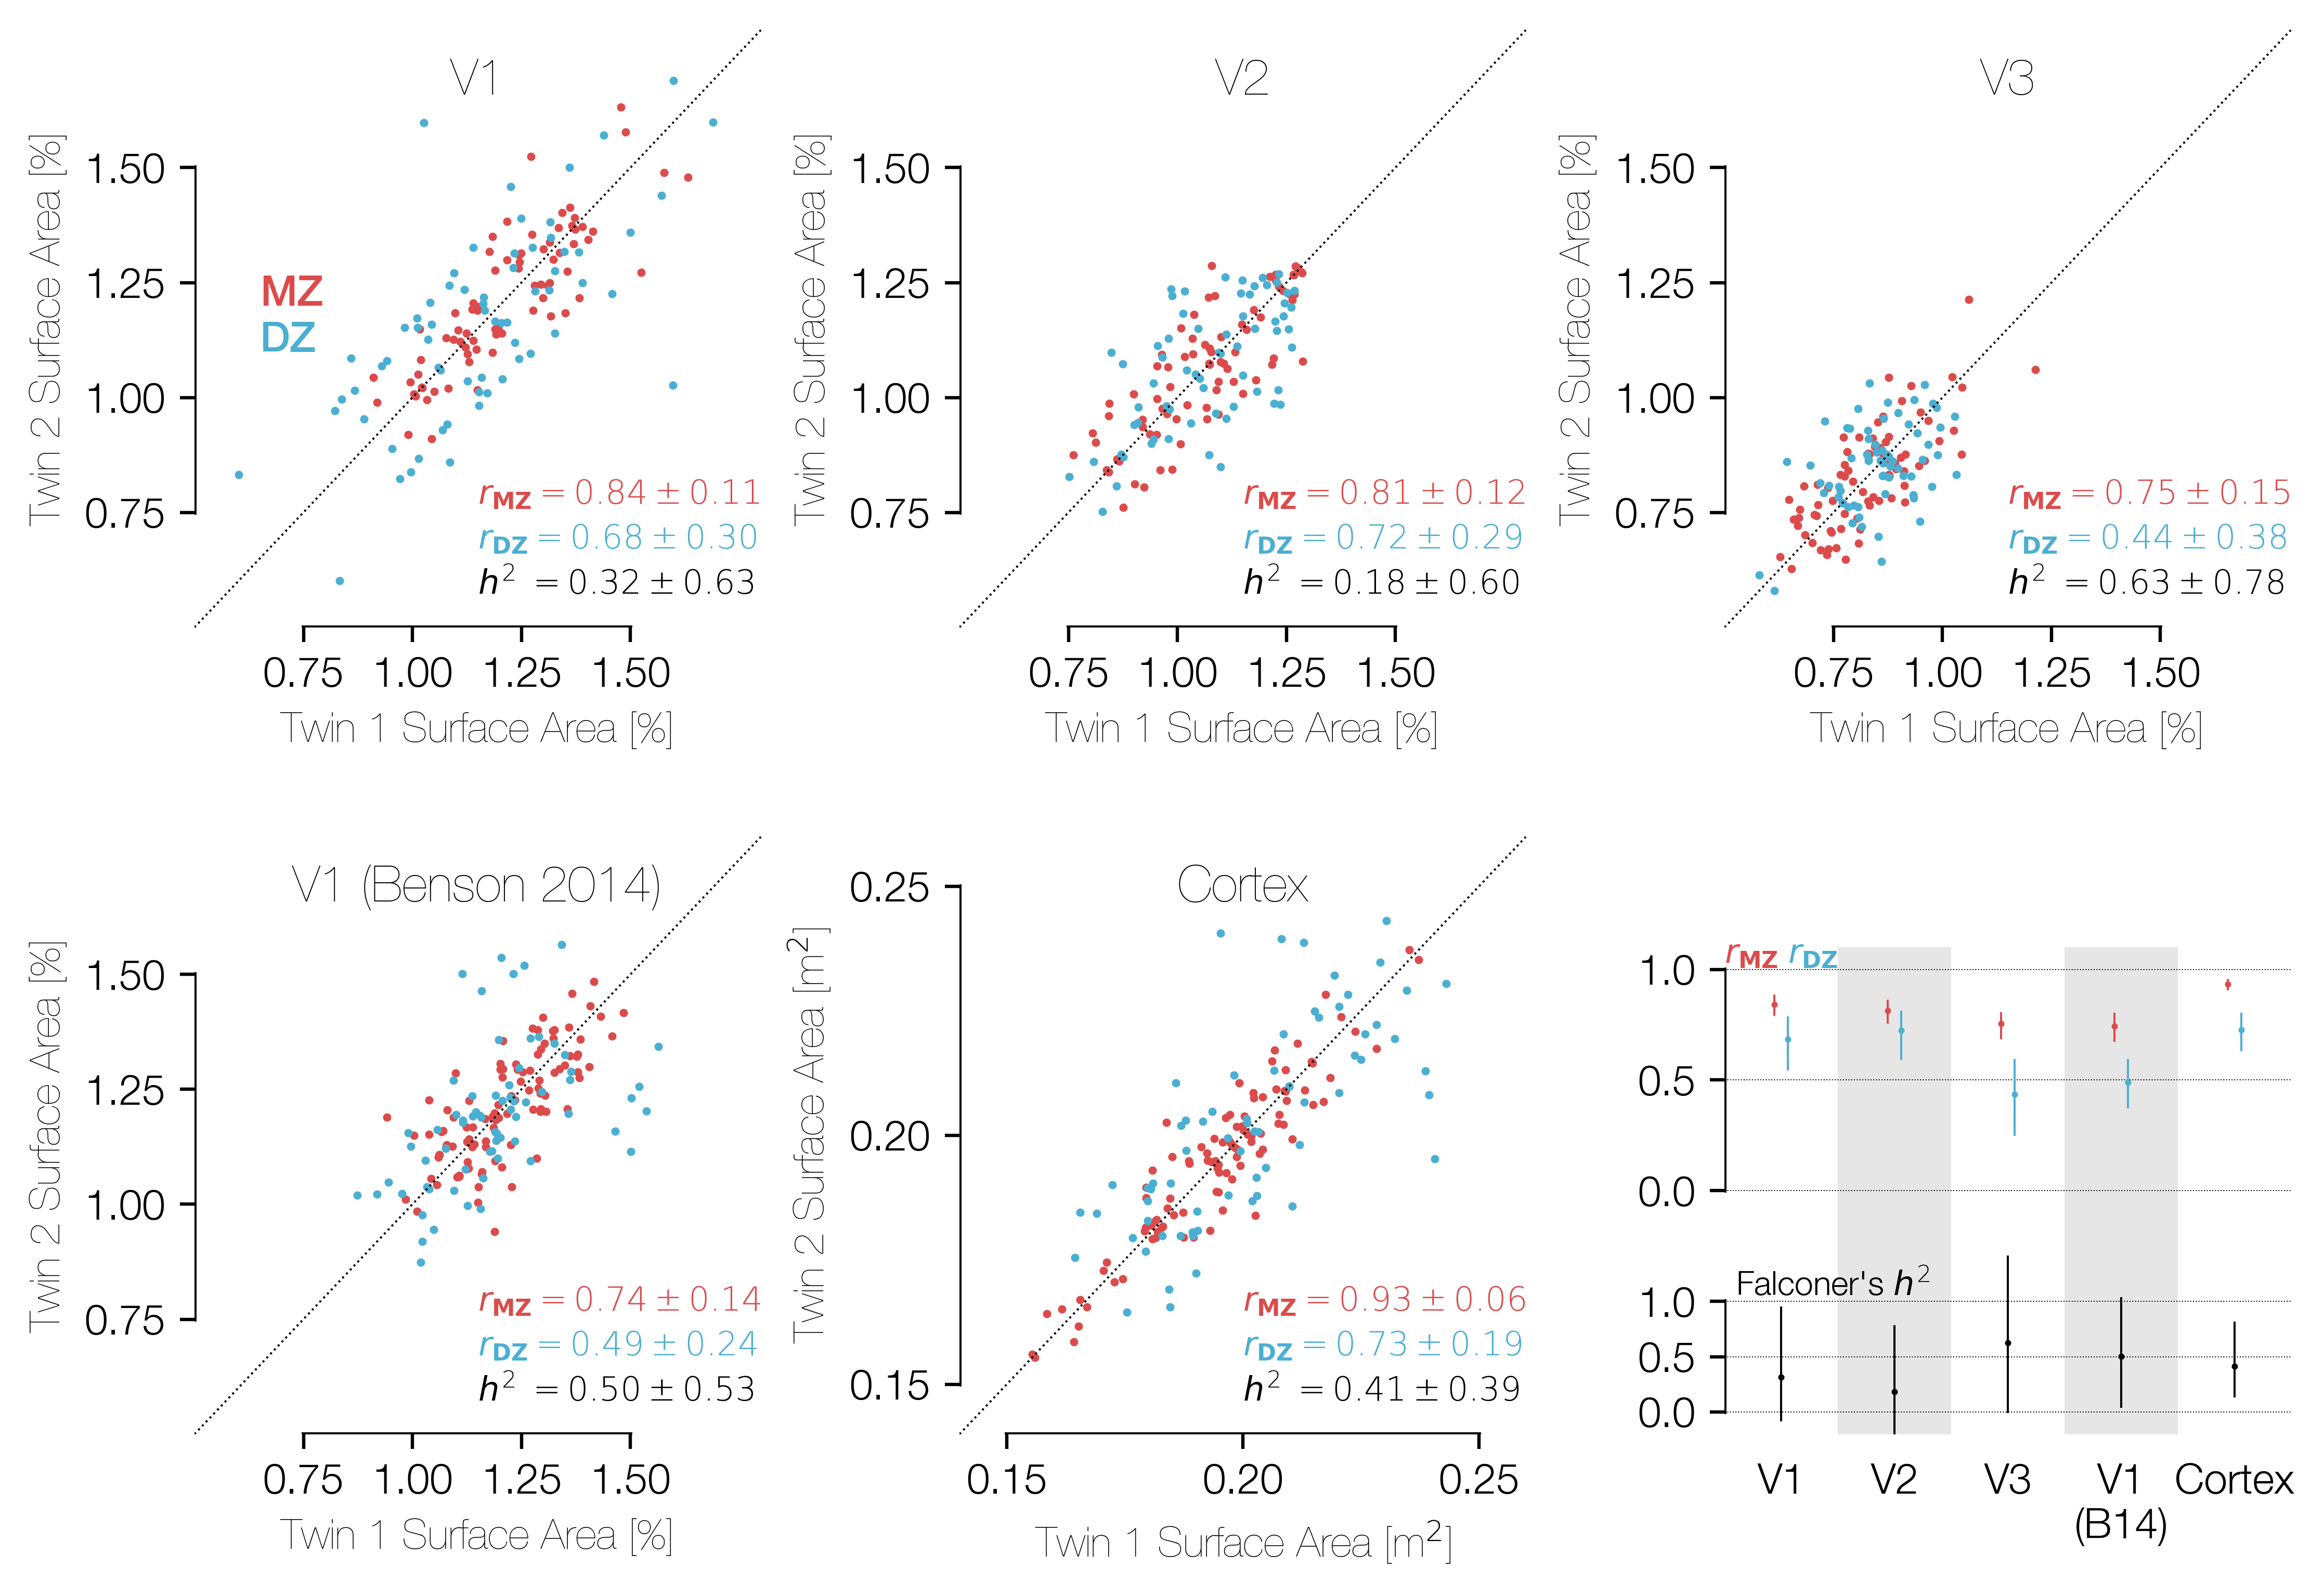

In [99]:
# These are the ROIs we'll be plotting
rois = [['roiXV1', 'roiXV2', 'roiXV3'],
        [ 'lblXB14V1','mm2_lblXH', None]]
# Include an inset of V1+V2+V3 surface area correlations?
inset_v123_q = False
# This will be the figure width.
figwidth = 7
dpi = 8*72
# Go ahead and setup the figure. We'll handle the final axis below
# so skip it for now.
(fig,axs) = plt.subplots(2, 3, figsize=(figwidth, figwidth*0.67), dpi=dpi)
fig.subplots_adjust(0,0,1,1, 0.35, 0.35)
rois = np.array(rois, dtype=np.object)
for (ax,roi) in zip(axs.flatten(), rois.flatten()):
    for s in six.itervalues(ax.spines):
        s.set_visible(False)
    if roi is None: continue
    # A few details depend on whether this is a mm or percent plot.
    mult = 1
    if roi.startswith('mm2'):
        if roi[-1] == 'H': 
            (unit,lim,ticks) = (r'm$^2$',(0.14,0.26),[0.15,0.2,0.25])
            mult = 1e-6
        else: (unit,lim,ticks) = (r'cm$^2$',(4,45),[10,20,30,40])
    else: (unit,lim,ticks) = ('%',(0.5,1.8),[0.75,1.0,1.25,1.5])
    ax.plot([ticks[0],ticks[-1]], [lim[0], lim[0]], 'k-', lw=1)
    ax.plot([lim[0], lim[0]], [ticks[0],ticks[-1]], 'k-', lw=1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    # Make the axis labels.
    ax.set_xlabel(r'Twin 1 Surface Area [%s]' % (unit,))
    ax.set_ylabel(r'Twin 2 Surface Area [%s]' % (unit,))
    # Plot the line of equality.
    ax.plot(lim, lim, 'k:', lw=0.5)
    # Actually grab the data we're intested in and plot it.
    for (tt,clr) in six.iteritems(twin_colors):
        if tt == 'UR': continue
        df = pair_data
        df = df.loc[df['relationship'] == tt]
        dat = df[[roi+'_1',roi+'_2']].values
        (x,y) = dat.T * mult
        clr = np.array(clr)
        clr[-1] = 1
        ax.scatter(x, y, c=[clr], s=1)
        ax.scatter(y, x, c=[clr], s=1)
    # Add the correlation and heritability reports
    hdat = heritability_data
    hdat = hdat.loc[hdat['region'] == roi].iloc[0]
    x = 0.5*(lim[1] + lim[0])
    y = 0.25*lim[1] + 0.75*lim[0]
    for (k,dy,nm,c) in zip(['rMZ','rDZ','h2'], [0,1,2],
                           ['r_{\mathbf{MZ}}','r_{\mathbf{DZ}}','h^2\;'],
                           [twin_colors['MZ'],twin_colors['DZ'],'k']):
        mu = hdat[k]
        hrng = max(hdat[k+'_ci95ub'] - mu, mu - hdat[k+'_ci95lb'])
        ax.text(x, y-dy*0.075*(lim[1]-lim[0]),
                r'$%s = %-3.2f \pm %-3.2f$' % (nm,mu,hrng),
                horizontalalignment='left', verticalalignment='top',
                color=c, fontsize=8)
# Plot the correlations and heritabilities. To do this we need to
# remove the last axes object and replace it with two separate
# stacked axes.
pos = axs[1,2].get_position()
(x0,y0,w,h) = (pos.x0, pos.y0, pos.width, pos.height)
axs[1,2].remove()
# First make the axes and set them up generally.
ax_r = fig.add_axes([x0, y0+h/3, w, h*2/3])
ax_h2 = fig.add_axes([x0, y0, w, h/3])
ylim = [-0.2, 1.6]
yticks = [0.0,0.5,1.0]
for ax in [ax_r,ax_h2]:
    for s in six.itervalues(ax.spines): s.set_visible(False)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_xlim([-0.5,4.5])
    ax.plot([-0.5,-0.5], [yticks[0],yticks[-1]], 'k-', lw=1)
    # Plot dashed lines
    for yy in [0,0.5,1]:
        ax.plot([-0.5,4.5], [yy,yy], 'k:', lw=0.25)
    # Plot a gray rectangle for some of the backgrounds.
    height = np.mean([yticks[-1],ylim[-1]]) if ax is ax_r else ylim[1]-ylim[0]
    for x in [0.5,2.5]:
        rect = plt.Rectangle([x,ylim[0]], 1, height, fill=True, zorder=-5,
                             facecolor=(0.9,0.9,0.9), edgecolor=None)
        ax.add_patch(rect)
ax_h2.set_xticks([0,1,2,3,4])
ax_h2.tick_params(axis='x', color=(1,1,1,0))
ax_h2.set_xticklabels(['V1','V2','V3','V1\n(B14)','Cortex'])
# Now plot the data:
for (ax,k,cl,dx) in zip([ax_r,ax_r,ax_h2], ['rMZ','rDZ','h2'],
                         [68,68,95], [-0.06,0.06,0]):
    clr = twin_colors[k[1:]] if k[0] == 'r' else 'k'
    for (x,roi) in enumerate(rois.flatten()):
        if roi is None: continue
        df = heritability_data
        df = df.loc[df['region'] == roi].iloc[0]
        (lb,mu,ub) = (df[k+'_ci%slb'%cl], df[k], df[k+'_ci%sub'%cl])
        ax.plot([x+dx,x+dx],[lb,ub], '-', lw=0.5, color=clr)
        ax.scatter(x+dx, mu, marker='.', s=1, c=[clr])
        
# Add some labels.
for (nm,y) in zip(['MZ','DZ'], [1.2, 1.1]):
    axs[0,0].text(0.65, y, nm, color=twin_colors[nm],
                  horizontalalignment='left',
                  fontweight='medium')
for (ax,nm) in zip(axs.flatten()[:5],
                   ['V1', 'V2', 'V3', 'V1 (Benson 2014)','Cortex']):
    ax.set_title(nm)
    ax.title.set_position([0.5,0.85])
# And for the final axes
ax_r.text(-0.5,1, r'$r_{\mathbf{MZ}}$', color=twin_colors['MZ'], fontsize=8,
          verticalalignment='bottom', horizontalalignment='left')
ax_r.text(0.5,1, r'$r_{\mathbf{DZ}}$', color=twin_colors['DZ'], fontsize=8,
          verticalalignment='bottom', horizontalalignment='right')
ax_h2.text(-0.4,1, r"Falconer's $h^2$", color='k', fontsize=8,
           verticalalignment='bottom', horizontalalignment='left')

############################################################################
if inset_v123_q:
    ax = fig.add_axes([0.65, 0.425, 0.1, 0.15])
    roi = 'mm2_roiXAll'
    #ax.axis('equal')
    for s in six.itervalues(ax.spines):
        s.set_visible(False)
    # A few details depend on whether this is a mm or percent plot.
    mult = 1
    (unit,lim,ticks) = ('%',(1.5,4.5),[1.5,3.0,4.5])
    ax.plot([ticks[0],ticks[-1]], [lim[0], lim[0]], 'k-', lw=1)
    ax.plot([lim[0], lim[0]], [ticks[0],ticks[-1]], 'k-', lw=1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    # Make the axis labels.
    #ax.set_xlabel(r'Twin 1 Surface Area [%s]' % (unit,))
    #ax.set_ylabel(r'Twin 2 Surface Area [%s]' % (unit,))
    # Plot the line of equality.
    ax.plot(lim, lim, 'k:', lw=0.5)
    # Actually grab the data we're intested in and plot it.
    
    for (tt,clr) in six.iteritems(twin_colors):
        if tt == 'UR': continue
        df = pair_data
        df = df.loc[df['relationship'] == tt]
        dat = 0
        for roi in [1,2,3]:
            dat = df[['roiXV%d_1'%roi, 'roiXV%d_2'%roi]].values + dat
        (x,y) = dat.T * mult
        clr = np.array(clr)
        clr[-1] = 1
        ax.scatter(x, y, c=[clr], s=1)
        ax.scatter(y, x, c=[clr], s=1)
        
    # Add the correlation and heritability reports
    hdat = heritability_data
    hdat = hdat.loc[hdat['region'] == roi].iloc[0]
    x = 0.5*(lim[1] + lim[0])
    y = 0.25*lim[1] + 0.75*lim[0]
    for (k,dy,nm,c) in zip(['rMZ','rDZ','h2'], [0,1,2],
                           ['r_{\mathrm{MZ}}','r_{\mathrm{DZ}}','h^2\;'],
                           [twin_colors['MZ'],twin_colors['DZ'],'k']):
        mu = hdat[k]
        hrng = max(hdat[k+'_ci95ub'] - mu, mu - hdat[k+'_ci95lb'])
        ax.text(x, y-dy*0.075*(lim[1]-lim[0]),
                r'$%s = %-3.2f \pm %-3.2f$' % (nm,mu,hrng),
                horizontalalignment='left', verticalalignment='top',
                color=c, fontsize=8)

############################################################################

# Save this figure, if possible.
if figures_path is not None:
    outpath = os.path.join(figures_path, 'twin_scatterplots.pdf')
    plt.savefig(outpath, bbox_inches='tight', dpi=dpi)

#### Nonparametric Test: Are MZ Twins More Similar than DZ Twins?

In this cell we use the utility function (defined in the introduction, above) `nonparam_pdiff()`, which estimates the probability that the median if one group of data is larger than that of another group of data using bootstraps. The call `nonparam_pdiff(mtx1, mtx2)` for an `m x n1` matrix `mtx1` and an `m x n2` matrix `mtx2` treats rows (`m`) as different types of measurement (in our case, the surface areas of V1, V2, or V3) and the columns (`n1`, `n2`) as individual observations. The return value is the `(lower_bound, probability, upper_bound)`, where, for a randomly chosen row `i` and randomly chosen columns `j1` and `j2` of `mtx1` and `mtx2`, respectively, `probability = P(mtx1[i,j1] > mtx2[i,j2])`.

In [260]:
# We want to use the same-gender twin pairs.
df = pair_data
df = df.loc[df['same_gender']]
# Split these into MZ and DZ twins.
dfmz = df.loc[df['relationship'] == 'MZ']
dfdz = df.loc[df['relationship'] == 'DZ']

# Here's how we calculate the matrices for MZ and DZ twins. Basically, we take
# the measured bilateral V1/V2/V3 (nonfoveal) surface areas for each twin pair
# and calculate the surface-area difference in the areas between the twins
# (this is the difference in square mm). We then divide this by the mean of the
# total bilateral cortical surface areas of the two subjects to get the
# fractional difference in surface area between the twins.
calcdiff = lambda df: np.divide(
    np.abs(df[['mm2_roiXV1_1', 'mm2_roiXV2_1', 'mm2_roiXV3_1']].values -
           df[['mm2_roiXV1_2', 'mm2_roiXV2_2', 'mm2_roiXV3_2']].values),
    np.mean(df[['mm2_lblXH_1', 'mm2_lblXH_2']].values, axis=1)[:,None])
# Calculate these matrices.
mzmtx = calcdiff(dfmz).T
dzmtx = calcdiff(dfdz).T

# Now, run the tests, first for the case described in the markdown cell above,
# then, just out of curiosity, the same probability for each visual area
# independently.
obs_all = nonparam_pdiff(mzmtx, dzmtx)
obs_v1  = nonparam_pdiff(mzmtx[[0]], dzmtx[[0]])
obs_v2  = nonparam_pdiff(mzmtx[[1]], dzmtx[[1]])
obs_v3  = nonparam_pdiff(mzmtx[[2]], dzmtx[[2]])

# Report these values.
for (obs,nm) in zip([obs_all,obs_v1,obs_v2,obs_v3],
                    ['All', 'V1', 'V2', 'V3']):
    obs = (('%4s' % (nm + ':')),) + tuple([o * 100 for o in obs])
    print('%s %5.2f%% < %5.2f%% < %5.2f%%' % obs)

All: 51.48% < 59.58% < 67.23%
 V1: 56.76% < 70.04% < 82.22%
 V2: 40.00% < 53.85% < 67.64%
 V3: 40.57% < 54.77% < 68.53%


#### Plot of the RMSE of sector surface areas between twin-pairs

This cell plots the RMS difference between twin-pair surface areas for each of the sectors defined by the hand-drawn lines.

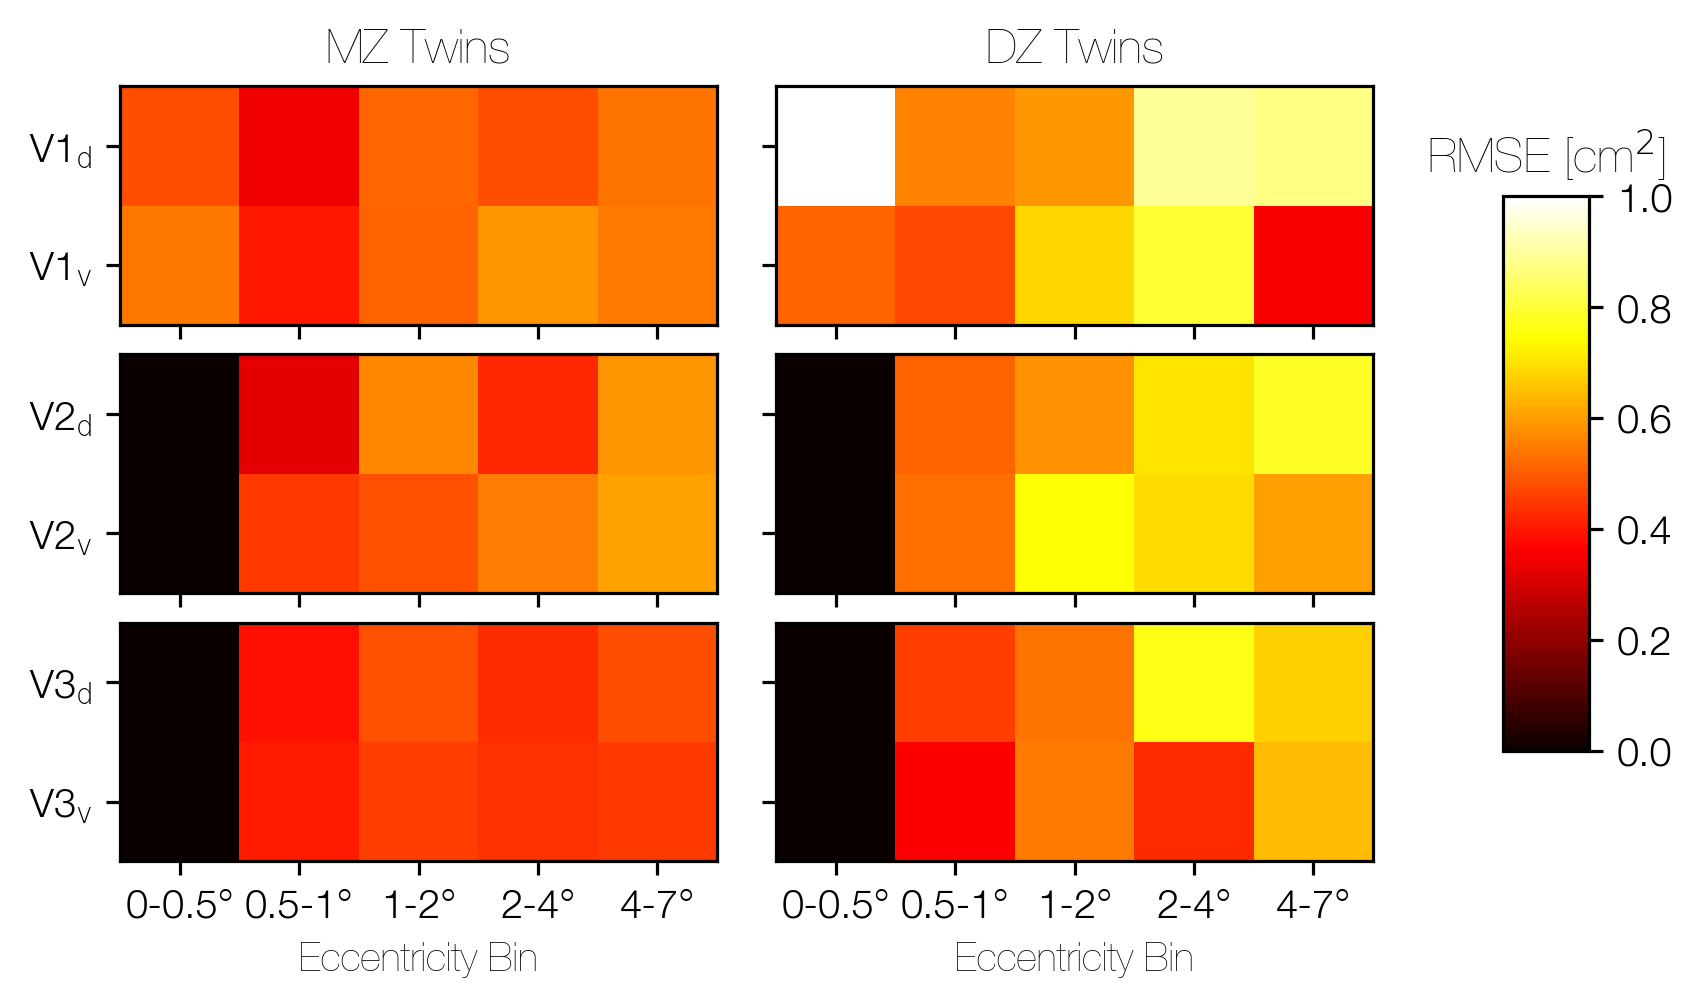

In [78]:
# Setup the figure.
(fig,axs) = plt.subplots(3, 2, figsize=(6,2.75), dpi=4*72, sharex=True, sharey=False)
fig.subplots_adjust(0,0,0.725,1,0.1,0.05)

# Go through MZ and DZ separately; MZ goes in the first column and DZ in the second.
for (rel, axcol) in zip(['MZ', 'DZ'], axs.T):
    # Pick out just the subjects that match this relationship.
    df = pair_data.loc[pair_data['relationship'] == rel]
    # We just want sectors, combined across LH and RH.
    cols = [k[:-2] for k in df.columns if k.startswith('mm2_sctX') and k.endswith('_1')]
    cols1 = [k + '_1' for k in cols]
    cols2 = [k + '_2' for k in cols]
    # Extract the relevant values.
    mtx1 = df[cols1].values
    mtx2 = df[cols2].values
    dat = {k[8:]:v for (k,v) in zip(cols, np.sqrt(np.nanmean((mtx1 - mtx2)**2, axis=0)))}
    org = {va: [['V%d%s%d' % (va,vd,ec) for vd in ['v','d']]
                for ec in [0,1,2,3,4]]
           for va in (1,2,3)}
    # Now, make the plot:
    for (ax,va) in zip(axcol, [1,2,3]):
        x = [[dat[k] if k in dat else 0 for k in row] for row in org[va]]
        q = ax.imshow(np.transpose(x)*0.01, cmap='hot', vmin=0, vmax=1)
        ax.set_yticks([0,1])
        if rel == 'MZ':
            ax.set_yticklabels([r'V%d$_{\mathrm{v}}$' % va, r'V%d$_{\mathrm{d}}$' % va])
        else:
            ax.set_yticklabels(['', ''])
        ax.invert_yaxis()
    axcol[-1].set_xlabel('Eccentricity Bin')
    axcol[-1].set_xticks([0,1,2,3,4])
    axcol[-1].set_xticklabels(['0-0.5°','0.5-1°','1-2°','2-4°','4-7°'])
ax = fig.add_axes([0.8, 0.15, 0.05, 0.7])
fig.colorbar(q, cax=ax)
ax.set_title(r'RMSE [cm$^2$]')
axs[0,0].set_title('MZ Twins')
axs[0,1].set_title('DZ Twins')

pass

### Distributions of the Correlation of Properties across Cortex between Twins

When given a large set of twin pairs with both anatomical data (curvature, myelination, thickness) and functional data (prf centers), a natural question to ask is, are these various data more similar in MZ than in DZ twins? We explore that question here. The goal is to make a set of histograms showing the distribution of correlations between twin pairs for these properties.

To begin, we must build up a data structure of the correlations. We make this as a dictionary `hist_prop_data` whose keys are property names. If `x = hist_prop_data['curvature']` then `x` is a 2xNxM matrix where `x[i,j,k]` is the curvature value for the `i`th hemisphere (0 for LH, 1 for RH), the `j`th subject, and the `k`th vertex. We will want to select just the subset of vertices that are in the Benson et al. (2014) atlas's V1-V3 definition.

Once we've built up the basic data structure, we build up the correlations. In the end we want another dictionary, `hist_corr_data` whose keys are twin-types and whose values are maps with property names as keys. If `x = hist_corr_data['MZ']['curvature']` then `x` is a 3xN matrix where `x[i,j]` is the correlation value of the LH (`i == 0`), RH (`i == 1`), or combined-LR (`i == 2`) `j`th MZ twin-pair. We can use, e.g., `x[0,:]` to make a histogram of correlation values across MZ twins of the LH curvature.

In [26]:
# We will use these map projections to extract the relevant vertices; these projections
# make a large-ish ROI centered on V1 and the occipital pole.
corr_mp_lh = ny.map_projection(chirality='lh', registration='fs_LR',
                               center=(1,-0.6,-0.2), center_right=(0,1,0.2),
                               radius=np.pi/3)
corr_mp_rh = ny.map_projection(chirality='rh', registration='fs_LR',
                               center=(-1,-0.6,-0.2), center_right=(0,-1,-0.2),
                               radius=np.pi/3)
corr_mps = {'lh': corr_mp_lh, 'rh': corr_mp_rh}
# Extract the vertices for each hemisphere
sub = ny.hcp_subject(data.subject_list[0])
corr_masks = {}
for h in ['lh','rh']:
    fm = corr_mps[h](sub.hemis['%s_LR32k' % h])
    # make sure not to include vertices not in the atlas label
    ii = fm.labels[fm.prop('atlas_label')]
    corr_masks[h] = ii

INFO:root:HCPDataset: Getting HCP subject list...


**Note**: As of when this notebook was written, `nibabel` produces a ton of warnings about the `pixdim` field in the HCP's data files when loading them in. These can be safely ignored.

In [28]:
# We're going to pull pre-aligned anatomical data off of the lh/rh
# hemisphere with this tag, e.g. if tag is '_LR32k', the hemispheres
# used are 'lh_LR32k' and 'rh_LR32k'.
hemi_tag = '_LR32k_MSMAll'

# These are the properties we care about:
hist_props = ['curvature', 'myelin', 'thickness',
              'lowres-prf_eccentricity', 'lowres-prf_gain',
              'lowres-prf_mean_signal']

# We'll want to use these twin-groups in this calculation;
# Note that If you do not have the restricted genetic data downloaded
# from the HCP, this will not run; you won't be able to plot any of the
# twin-data comparisons below or perform any of the related analyses.
mzs = data.retinotopy_sibling_pairs['monozygotic_twins']
dzs = data.retinotopy_sibling_pairs['dizygotic_twins']
urs = data.retinotopy_sibling_pairs['unrelated_pairs']

# Figure out the ROI we will use--i.e., pick out the vertices of the
# fs_LR surface that we want to correlate across. We can use any subject,
# so we will just use the first subject
#sub = ny.hcp_subjects()

# We'll build up the histogram property data as a map of properties first.
hist_prop_data = {}
for prop in hist_props:
    tmp = []
    #print(prop)
    for sid in data.subject_list:
        #print('   ', sid)
        sub = ny.hcp_subject(sid)
        lh = sub.hemis['lh' + hemi_tag]
        rh = sub.hemis['rh' + hemi_tag]
        lp = lh.prop(prop)[corr_masks['lh']]
        rp = rh.prop(prop)[corr_masks['rh']]
        tmp.append([lp,rp])
    # dimensions should be prop => 2(lh, rh) x N (subjects) x M (vertices)
    hist_prop_data[prop] = np.transpose(tmp, (1,0,2))

# We now need to build up correlations for the histograms. These correlations
# are calculated for each twin-pair across all their aligned vertices. The
# histogram will plot the distribution of twin-pairs across this correlation.
# Since we don't expect much difference in the correlation values betwee
# hemispheres, we will plot the hemispheres together.
hist_corr_data = {
    tt: {
        prop: np.array([[corr(vals[[sid_to_index[p] for p in pair]])
                         for pair in pairs]
                        for vals in (dat[0], dat[1], np.hstack(dat))])
        for prop in hist_props
        for dat in [hist_prop_data[prop]]}
    for (pairs,tt) in zip([mzs,dzs,urs], ['MZ', 'DZ', 'UR'])}

After building up these data structures in the above cell, we just need to plot histogams. We plot density histograms since the number of twins in each case won't be the same, but we want them to be comparable.

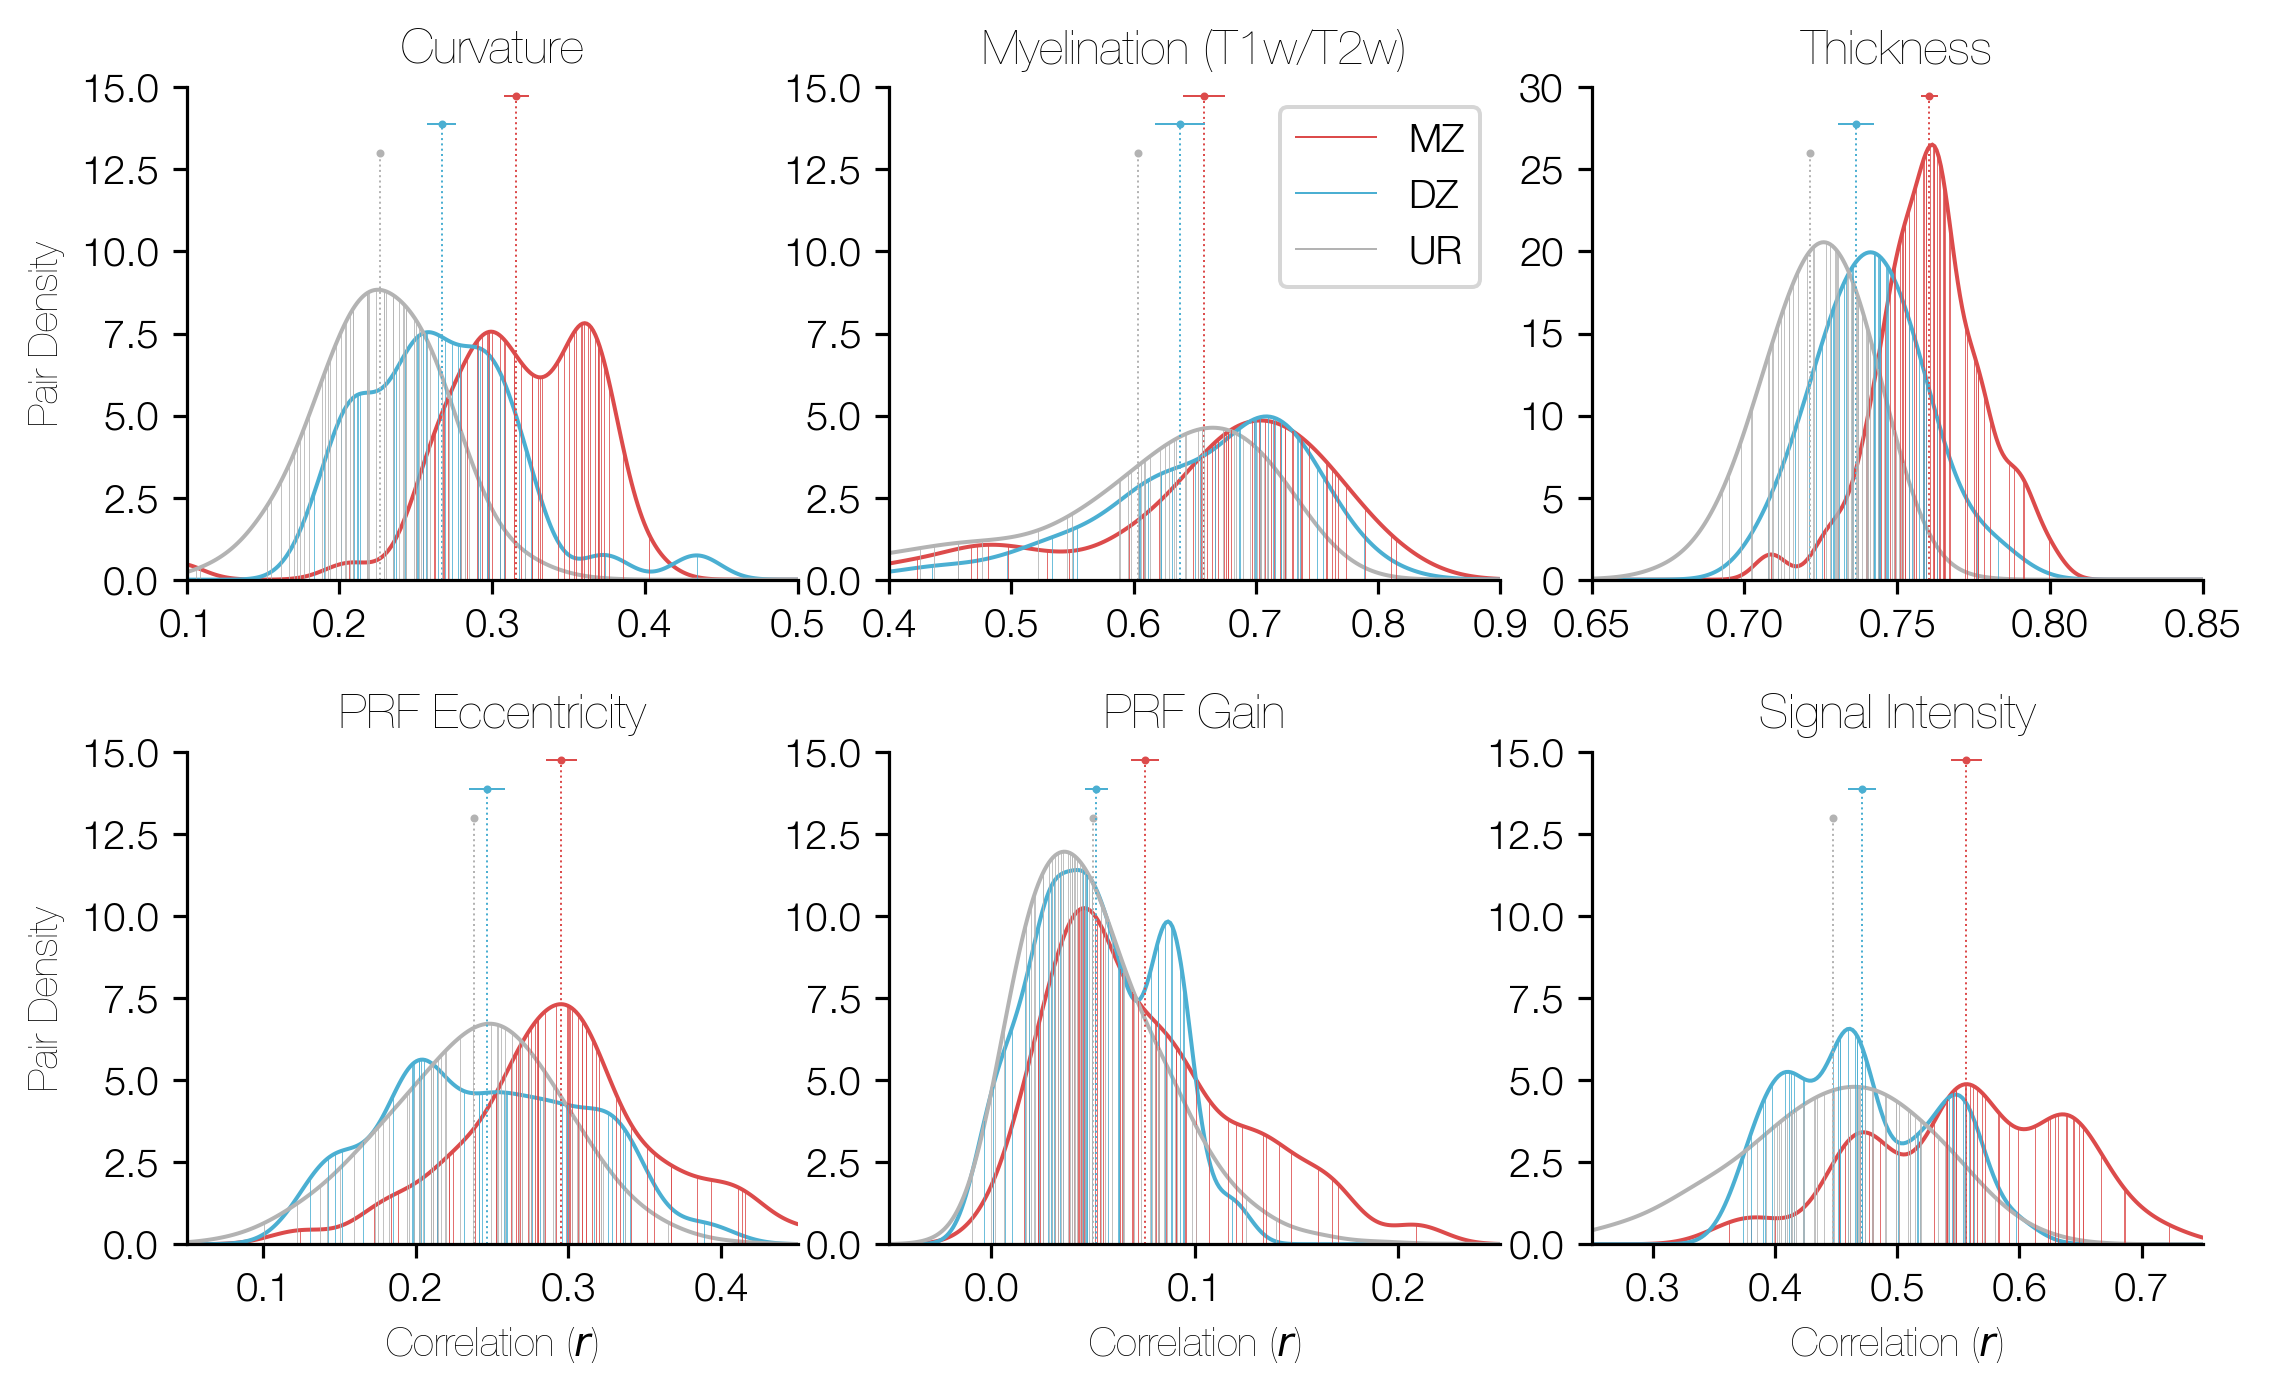

In [31]:
###### Are we going to plot the LH, RH, or combined-LR correlations?
# 0: LH,  1: RH,  2: LR
h = 2
# How do we deal with sex? Only same-sex twins or all twins included?
samesex_only = True
# If this flag is set to True, the code will print out a table of
# the 0, 2.5, 25, 50, 75, 97.5, 100] percentiles for each property
# that is plotted.
print_reports = False
# The aspect ratio (width/height) of the individual panels.
aspect_ratio = 1.1618 # approx. golden ratio
# The width of the image in inches.
width = 7
# The dots per inch
dpi = 72*4

# These are configurations for how to make the plot.
# bins is the array of bin edges to use in the histogram.
hist_bins = {'curvature': np.linspace(0.10, 0.50, 12),
             'myelin':    np.linspace(0.15, 0.90, 12),
             'thickness': np.linspace(0.65, 0.85, 12),
             'lowres-prf_eccentricity': np.linspace( 0.05, 0.45, 12), 
             'lowres-prf_gain':         np.linspace(-0.05, 0.25, 12),
             'lowres-prf_mean_signal':  np.linspace( 0.20, 0.80, 12)}
# The ax_layout tess us  which panels we should put what property in.
ax_layout = [['curvature','myelin','thickness'],
             ['lowres-prf_eccentricity', 'lowres-prf_gain',
              'lowres-prf_mean_signal']]
# The titles are what to put at the top of the panel for a label/title.
ax_titles = {'curvature':               'Curvature',
             'myelin':                  'Myelination (T1w/T2w)',
             'thickness':               'Thickness',
             'lowres-prf_eccentricity': 'PRF Eccentricity',
             'lowres-prf_gain':         'PRF Gain',
             'lowres-prf_mean_signal':  'Signal Intensity'}
# The colors of the various twin-types; we copy the twin_colors
# because we are going to edit them to have an alpha inversely
# proportional to the number of each pair.
hist_colors = {k: np.array(v) for (k,v) in six.iteritems(twin_colors)}

report_percentiles   = [0, 2.5, 25, 50, 75, 97.5, 100]
report_format        = ' '.join(['%11s'] + (['%6.3f']*len(report_percentiles)))
report_title_format  = ' '.join(['%-11s'] + (['%5.1f%%']*len(report_percentiles)))
if print_reports:
    row = ['Property'] + list(report_percentiles)
    report_title = report_title_format % tuple(row)
    print(report_title)
    print('-' * len(report_title))

# To make the figure, we need to setup the axes.
(rows,cols) = np.shape(ax_layout)
figsize     = (width, width/cols / aspect_ratio * rows)
(fig,axs)   = plt.subplots(rows, cols, dpi=dpi, figsize=figsize, sharey=False)
fig.subplots_adjust(0,0, 1, 1, 0.15, 0.35)

# Iterate through the properties and plot each for each twin type.
for (axrow,proprow) in zip(axs, ax_layout):
    for (ax,prop) in zip(axrow, proprow):
        bins = hist_bins[prop]
        for (tt,pairs) in zip(['MZ','DZ','UR'], [mzs, dzs, urs]):
            d = hist_corr_data[tt][prop][h]
            clr = hist_colors[tt]
            clr[-1] = 0.8
            # If plotting same-sex twins only, select just those twins.
            if samesex_only:
                samesex = [data.gender[t1] == data.gender[t2]
                           for (t1,t2) in pairs]
                samesex = np.array(samesex, dtype='bool')
                d = d[samesex]
            # Plot the histogram data.
            if print_reports:
                args = ([prop.split('prf_')[-1]] +
                        list(np.percentile(d, report_percentiles)))
                msg = report_format % tuple(args)
                print(msg)
            # Make a kde distribution:
            kde = stats.gaussian_kde(d, bw_method=0.3)
            # Make a polygon to plot:
            px = np.linspace(bins[0], bins[-1], dpi)
            py = kde(px)
            px = np.concatenate([[px[0]-1, px[0]-1], px, [px[-1]+1, px[-1]+1]])
            py = np.concatenate([[     -1, py[0]],   py, [py[-1]+1, -1]])
            pgon = plt.Polygon(np.transpose([px,py]), fill=False,
                               facecolor=clr, edgecolor=clr[:-1])
            ax.add_patch(pgon)
            # plot lines for each correlation also
            if tt == 'UR': dd = np.random.choice(d, 50)
            else: dd = d
            for (rval,kval) in zip(dd, kde(dd)):
                ax.plot([rval,rval], [0,kval], color=clr, lw=0.25, ms=0)
            # Finally, we plot the mean ± 95% confidence interval at the top
            y = [29.5, 27.75, 26]
            y = y[0 if tt == 'MZ' else 1 if tt == 'DZ' else 2]
            y = y if prop == 'thickness' else y/2
            mu = np.mean(d)
            #se = 1.96*np.sqrt(np.var(d) / len(d))
            se = np.sqrt(np.var(d) / len(d))
            ax.plot([mu-se,mu+se], [y,y], color=clr[:-1], ms=0, lw=0.5, label=tt)
            ax.scatter(mu, y, c=[clr[:-1]], s=1)
            ax.plot([mu,mu], [0,y], ':', color=clr[:-1], lw=0.5)
            #ax.hist(d, bins=bins, density=True, color=clr, label=tt)
        # Configure this axes object.
        ax.set_xlim([bins[0], bins[-1]])
        ymx = 30 if prop == 'thickness' else 15
        ax.set_ylim([0,ymx])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title(ax_titles[prop])
# Adjust the anges on a few of them manually:
axs[0,0].set_xlim([0.1,0.5])
axs[0,1].set_xlim([0.4,0.9])
axs[0,2].set_xlim([0.65,0.85])
axs[1,0].set_xlim([0.05,0.45])
axs[1,1].set_xlim([-0.05,0.25])
axs[1,2].set_xlim([0.25,0.75])
# Set the x-axis titles for the bottom row:
for ax in axs[-1]:  ax.set_xlabel('Correlation ($r$)')
for ax in axs[:,0]: ax.set_ylabel('Pair Density')
# Add a legend in the top middle.
axs[0,1].legend()

if figures_path is not None:
    outpath = os.path.join(figures_path, 'property_corr_histograms.pdf')
    plt.savefig(outpath, bbox_inches='tight')

### Visual Area Label Probabilities

In these cells we construct and optionally export a set of probability labels for the visual areas. These are exported as MGZ files in the neuropythy directory (but you can change this export location if you wish).

In [273]:
# We want to use the mean anatomist to calculate labels.
anat = 'mean'
# The output path can be None (don't write out files) or Ellipsis
# (put them in neuropythy's library directoy) or a path in which
# to put the probability label files.
output_path = Ellipsis

# Go ahead and grab the fsaverage subject.
fsa = ny.freesurfer_subject('fsaverage')

# We'll build up the number of labels that match each vertex as well
# as the number of labels overall to get the probability.
ns = {'lh':0, 'rh':0}
lbls = {h: {k: np.zeros(fsa.hemis[h].vertex_count)
            for k in [1,2,3]}
        for h in ['lh','rh']}
for sid in data.subject_list:
    #print(sid)
    sub = data.subjects[sid]
    for h in ['lh','rh']:
        # Skip excluded hemispherers.
        if (anat,sid,h) in data.exclusions: continue
        ns[h] += 1
        hem = sub[h]
        fsh = fsa.hemis[h]
        # Interpolate over to the fsaverage.
        ll = hem.interpolate(fsh, 'visual_area', method='nearest')
        q = lbls[h]
        for (k,v) in six.iteritems(q):
            ii = (ll == k)
            if np.sum(ii) <= 0:
                warnings.warn('Subject %s / %s has no mask for %s' % (sid,h,k))
            v += ii
# Divide by number of observations to get the percentage.
lbls = {h: {k: v/ns[h] for (k,v) in six.iteritems(u)}
        for (h,u) in six.iteritems(lbls)}

if output_path is not None: 
    if output_path is Ellipsis:
        output_path = os.path.join(ny.library_path(), 'data', 'fsaverage', 'surf')
    vas = [1,2,3]
    for h in ['lh','rh']:
        lls = lbls[h]
        ps = np.asarray([lls[va] for va in vas])
        flnm = os.path.join(output_path, '%s.benson20_fplbl.v0_1.mgz' % h)
        if not os.path.isfile(flnm): ny.save(flnm, ps.T)
        ps = np.vstack([[1 - np.sum(ps, axis=0)], ps])
        mp = np.argmax(ps, axis=0).astype('int')
        flnm = os.path.join(output_path, '%s.benson20_mplbl.v0_1.mgz' % h)
        if not os.path.isfile(flnm): ny.save(flnm, mp)

## Quality Control

There should be a precise match between the subjects/anatomists with NaN for surface area and the subjects/anatomists that are excluded.

### Checks of the Surface Areas and Labels

---

**Different methods of calculating surface area should agree.**

The calculations employed by `neuropythy` on behalf of this notebook are careful to divide individual triangles on the surface mesh into separate "inner" and "outer" components when summing up the surface area of an ROI or sector. Simply taking all the vertices with the same label and summing up their vertex areas isn't as precise, but it should strongly correlate across all ROIs and sectors.

In [168]:
# We will use <n> observations in our correlation calculations below;
# an observation is 1 subject * 1 anatomist.
n = 80

# Pick a random subset of the subjects.
sids = np.random.choice(data.full_subject_list, n, replace=True)
# And a subset of anatomists.
anats = np.random.choice(data.full_anatomist_list, n, replace=True)

# We can extract the surface areas out of the surface-area dataframe.
df = data.surface_area_dataframe
# We can speed up the below computation by cutting this down to just
# the relevant subjects.
df = df.loc[np.isin(df['sid'], sids)]

# Here, we walk through each subject/anatomist pair and do a couple
# of things. First, we exctract each subj/anat pair out of the
# dataframe and put their data in a data structure for easy use in
# calculations. Secondly, we calculate the surface areas for all
# the same ROIs using FreeSurfer's vertex area property and put
# it's data in a similar structure.
ny_roisct_data = ny.auto_dict(None, []) # the data from the dataframe
fs_roisct_data = ny.auto_dict(None, []) # the freesurfer-based areas
roisct_ids = ny.auto_dict(None, [])
for (sid,anat) in zip(sids, anats):
    # Make sure there aren't problems with this set of lines first.
    if any((anat,sid,h) in data.exclusions for h in ['lh','rh']):
        warnings.warn('skipping %s:%d (known line errors)' % (anat,sid))
        continue
    # We're going to calculate surface areas for this subject, so get
    # the appropriate data structures.
    sub = data.subjects[sid]
    (lh, rh) = (sub.lh, sub.rh)
    # Extract the relevant row from the surface-areas dataframe.
    row = df.loc[df['sid'] == sid]
    row = row.loc[row['anatomist'] == anat].iloc[0]
    # Save this sid/anatomist.
    roisct_ids['sid'].append(sid)
    roisct_ids['anatomist'].append(anat)
    # Now go through the sectors/rois and extract/calculate areas.
    for (k,v) in six.iteritems(row):
        # We don't bother with these columns for obvious reasons.
        if k in ['anatomist','sid']: continue
        # Additionally, these columns involve FreeSurfer-summed
        # vertex counts, so aren't of interest for comparison either.
        if k.startswith('lbl'): continue
        # If the dataframe value is nan, there is some line-processing
        # error and we should just ignore this one.
        if not np.isfinite(v): continue
        # Otherwise just save it in the neuropythy roi dataset.
        ny_roisct_data[k].append(v) 
        # Calculate the surface areas using the FreeSurfer vertex
        # surface area values combined with the area/sector labels
        # for those same subjects/anatomists.
        hem = lh if 'L' in k else rh
        sa = hem.prop('midgray_surface_area')
        # Was it an ROI or a sector?
        lbl = data.subject_labels[anat][sid][hem.chirality]
        if k.startswith('roi'):
            lbl = lbl['visual_area']
            idx = data.area_label_index
        else:
            lbl = lbl['visual_sector']
            idx = data.sector_label_index
        # find the sector/area name that goes with this ROI
        nm = k[4:]
        # and the index/value for this ROI
        if nm not in idx: continue
        idx = idx[nm]
        # Extract the particular ROI from FreeSurfer
        fs_roisct_data[k].append(np.sum(sa[lbl == idx]))
ny_roisct_data = {k:np.asarray(v) for (k,v) in six.iteritems(ny_roisct_data)}
fs_roisct_data = {k:np.asarray(v) for (k,v) in six.iteritems(fs_roisct_data)}

/Users/nben/Library/miniconda2/envs/nben/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: skipping A4:171633 (known line errors)
/Users/nben/Library/miniconda2/envs/nben/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: skipping mean:131722 (known line errors)
/Users/nben/Library/miniconda2/envs/nben/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: skipping A1:125525 (known line errors)
/Users/nben/Library/miniconda2/envs/nben/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: skipping A4:182436 (known line errors)
/Users/nben/Library/miniconda2/envs/nben/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: skipping mean:177645 (known line errors)
/Users/nben/Library/miniconda2/envs/nben/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: skipping mean:182436 (known line errors)
/Users/nben/Library/miniconda2/envs/nben/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: skip

In [169]:
# What are the correlations between these values?
for k in six.iterkeys(fs_roisct_data):
    if k not in ny_roisct_data: continue
    v1 = ny_roisct_data[k]
    v2 = fs_roisct_data[k]
    print(k, corr(v1,v2)**2)

roiLV1 0.9991094256668638
roiLV3 0.9989655712315683
roiLV2 0.9990952994653409
roiRV1 0.999528764683878
roiRV3 0.9991697383838789
roiRV2 0.9993950542777204
sctLV1d3 0.997120943024503
sctLV2d3 0.9972815703054841
sctLV2d1 0.9971167235977146
sctLV1v0 0.9982220459564862
sctLV1d4 0.9976699650286475
sctLV3d2 0.9972247146123286
sctLV2v4 0.9968367458225843
sctLV3d3 0.9985743234480432
sctLV1v3 0.9974075350593883
sctLV2d4 0.998099437036987
sctLV1v1 0.9971859027321887
sctLV1d0 0.9979414837477911
sctLV3v1 0.996631962304105
sctLV1v4 0.9949453066806953
sctLV2v1 0.9969477062010731
sctLV2v3 0.9971703586887691
sctLV3d1 0.9967498016775905
sctLV3v3 0.9944074464709987
sctLV2v2 0.997445349073254
sctLV3v4 0.9968909328464396
sctLV1d1 0.9955641437406387
sctLV1v2 0.9958098076714905
sctLV2d2 0.9954677785777389
sctLV3v2 0.9968861165788766
sctLV1d2 0.9967174667874106
sctLV3d4 0.9981838552824249
sctRV1d3 0.9983211610012197
sctRV2d3 0.9973245940565939
sctRV2d1 0.9971177189899777
sctRV1v0 0.9977916853494966
sctRV1d4 

### Export Plots of Errors for Examination

The cell below exports plots of the raw lines of all the subjects whose preprocessing produced errors. These errors can usually be attributed to topological defects in the lines drawn by the anatomist. For example, the following are sources of errors in multiple subjects.
* Two of the drawn iso-eccentricity lines intersect; e.g., the 4° iso-eccentricity lines intersects the 7° line.
* An iso-eccentricity line (such as the 2° line) intersects the a visual area boundary line (such as the V1 ventral line) in more than one place.
* The inner-most iso-eccentricity line does not intersect the V1 boundary lines anywhere.

In [ ]:
# Configuration for this cell:
overwrite = False # do we overwrite the images?
create_dir = True # should we create the directory if not found?
create_mode = 0o755 # what mode should we give a new directory?
verbose = True # should we print messages on the way?

# We will use this directory to store the plots of the processing errors.
outpath = os.path.join(ny.config['hcp_lines_path'],
                       'figures', 'topological_defects')

# If the directory doesn't exist, make it.
if not os.path.isdir(outpath):
    if create_dir:
        if verbose: print("Creating directory %s\n" % outpath)
        os.makedirs(outpath, mode=create_mode)
    else:
        raise ValueError('Directory (%s) does not exist!' % outpath)

# Iterate through the errors:
for (sid,err) in six.iteritems(data.subject_errors):
    # Extract the anatomists for which this subject had an error.
    anats = list(set([anat for hd in err.values() for anat in hd.keys()]))
    # Iterate through the anatomists.
    if verbose:
            print('Plotting subject %s.' % sid)
    for anat in anats:
        # Get the filename
        flnm = os.path.join(outpath, 'sub-%d_anat-%s.png' % (sid, anat))
        if overwrite or not os.path.isfile(flnm):
            # Try making the subject plot:
            print('  - Anatomist %s...' % anat)
            try:
                fig = subject_summary_plot(sid, anat, traces='raw', dpi=72*4)
            except Exception:
                if verbose:
                    print('    FAILURE: %s / %s' % (sid, anat))
                plt.close(plt.gcf())
                continue
            plt.savefig(flnm)
            plt.close(fig)
        else:
            print('  - [Anatomist %s already plotted.]' % anat)

### Check the NaNs in the surface area dataframe

The surface area dataframe should contain `NaN` values only for subjects that had errors in their lines such as intersecting iso-eccentricity curves or missing curves; other `NaN`s would indicate processing errors.

In [30]:
# We will look through the columns and collect the NaN values
sarea_nans = {}
# Additionally, we want to keep track of the NaNs that don't
# correspond to a known error in processing; these would
# indicate problems with the surface-area data.
sarea_bads = {}
for k in sarea_data.columns:
    # These columns don't have surface areas
    if k in ['sid','anatomist']: continue
    # Pick out those values that are not finite
    ii = np.where(~np.isfinite(sarea_data[k].values))
    # Note what subject/anatomist goes with these values
    nans = sarea_data[['anatomist','sid']].iloc[ii].values
    sarea_nans[k] = nans
    # Keep track of the bad subjects, specifically (the ones
    # that don't have known exclusions).
    h = 'lh' if 'L' in k else 'rh'
    bads = [(anat,sid) for (anat,sid) in nans
            if (anat,sid,h) not in data.exclusions]
    if len(bads) > 0:
        sarea_bads[k] = bads
        
# Collect, specifically, the subject IDs of any subject that had an
# unexplained NaN; if this is non-empty, it indicates problems with
# the dataset.
bad_sids = [sid for bl in six.itervalues(sarea_bads) for (anat,sid) in bl]
bad_sids = np.unique(bad_sids)
bad_sids

array([], dtype=float64)